# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os

In [2]:

emulator_path=['/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['Lockman-SWIRE']

In [3]:
# Parameters
emulator_path = [
    "/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz"
]
field = ["Lockman-SWIRE"]


In [4]:
try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[26]

In [5]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')


In [6]:
esb['S\xa0250 (mJy)']

<MaskedColumn name='S\xa0250 (mJy)' dtype='float64' length=27>
131.6
 95.7
   --
 44.2
 56.9
116.5
 65.7
   --
 81.9
   --
 66.4
 43.5
  ...
 76.1
 56.6
   --
 25.5
183.8
 75.0
   --
 35.3
 43.1
 43.5
   --
   --

In [7]:
priors,_=xidplus.load('./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'.pkl')

In [8]:
prior_list=Table.read('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'.ascii',format='ascii')


In [9]:
z_mu=np.empty((priors[1].nsrc))
z_sig=np.empty((priors[1].nsrc))

for x,i in enumerate(priors[1].ID):
    ind=prior_list['help_id']==str(i)
    z_mu[x]=prior_list['redshift'][ind]
    z_sig[x]=prior_list['redshift_unc'][ind]

    

sfr_mu=1.5*z_mu+1.0
sfr_sig=np.full(priors[1].nsrc,0.5)

agn_frac_mu=np.full(priors[1].nsrc,-1)
agn_frac_sig=np.full(priors[1].nsrc,1)

In [10]:
params_mu=np.vstack((sfr_mu,z_mu)).T
params_sig=np.vstack((sfr_sig,z_sig)).T
params_names=['log10sfr','z']
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}


In [11]:
phys_prior=xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [12]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [13]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [14]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 7.36 s, sys: 94.7 ms, total: 7.45 s
Wall time: 7.41 s


## Fit Real data

In [15]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(os.cpu_count())
from operator import attrgetter
nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel')
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors,phys_prior,hier_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:43:57,  6.24s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<1:12:37,  4.38s/it, 127 steps of size 5.32e-04. acc. prob=0.26]

warmup:   1%|          | 7/1000 [00:07<57:31,  3.48s/it, 1023 steps of size 7.88e-04. acc. prob=0.37] 

warmup:   1%|          | 8/1000 [00:08<42:00,  2.54s/it, 255 steps of size 1.32e-03. acc. prob=0.44] 

warmup:   1%|          | 9/1000 [00:08<32:44,  1.98s/it, 511 steps of size 6.13e-04. acc. prob=0.46]

warmup:   1%|          | 10/1000 [00:10<29:56,  1.81s/it, 1023 steps of size 1.14e-03. acc. prob=0.51]

warmup:   1%|          | 11/1000 [00:11<27:49,  1.69s/it, 1023 steps of size 1.70e-03. acc. prob=0.55]

warmup:   1%|          | 12/1000 [00:13<26:16,  1.60s/it, 1023 steps of size 1.24e-03. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:14<25:07,  1.53s/it, 1023 steps of size 5.96e-04. acc. prob=0.56]

warmup:   1%|▏         | 14/1000 [00:15<24:28,  1.49s/it, 1023 steps of size 1.16e-03. acc. prob=0.59]

warmup:   2%|▏         | 15/1000 [00:17<23:58,  1.46s/it, 1023 steps of size 2.22e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:18<23:21,  1.42s/it, 1023 steps of size 3.98e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:19<23:14,  1.42s/it, 1023 steps of size 7.16e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:21<23:02,  1.41s/it, 1023 steps of size 1.68e-03. acc. prob=0.64]

warmup:   2%|▏         | 19/1000 [00:22<22:51,  1.40s/it, 1023 steps of size 2.40e-03. acc. prob=0.65]

warmup:   2%|▏         | 20/1000 [00:24<22:53,  1.40s/it, 1023 steps of size 4.63e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:25<22:40,  1.39s/it, 1023 steps of size 3.96e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:26<22:35,  1.39s/it, 1023 steps of size 4.24e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:28<22:27,  1.38s/it, 1023 steps of size 3.42e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:29<22:36,  1.39s/it, 1023 steps of size 4.28e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:31<22:41,  1.40s/it, 1023 steps of size 7.72e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:32<22:29,  1.39s/it, 1023 steps of size 6.90e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:33<22:23,  1.38s/it, 1023 steps of size 6.58e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:35<22:27,  1.39s/it, 1023 steps of size 2.78e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:36<22:28,  1.39s/it, 1023 steps of size 4.82e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:37<22:30,  1.39s/it, 1023 steps of size 1.98e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:39<22:26,  1.39s/it, 1023 steps of size 3.62e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:40<22:32,  1.40s/it, 1023 steps of size 4.13e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:42<22:34,  1.40s/it, 1023 steps of size 5.67e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:43<22:40,  1.41s/it, 1023 steps of size 7.85e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:44<19:18,  1.20s/it, 511 steps of size 1.32e-03. acc. prob=0.70] 

warmup:   4%|▎         | 36/1000 [00:45<19:58,  1.24s/it, 1023 steps of size 2.24e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:47<20:47,  1.30s/it, 1023 steps of size 3.98e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:48<21:49,  1.36s/it, 1023 steps of size 6.06e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:50<22:54,  1.43s/it, 1023 steps of size 3.33e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:51<23:37,  1.48s/it, 1023 steps of size 4.79e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:53<23:56,  1.50s/it, 1023 steps of size 5.76e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:54<24:17,  1.52s/it, 1023 steps of size 3.91e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:56<24:37,  1.54s/it, 1023 steps of size 6.23e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:58<24:38,  1.55s/it, 1023 steps of size 3.01e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:59<24:42,  1.55s/it, 1023 steps of size 3.69e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [01:01<24:49,  1.56s/it, 1023 steps of size 5.93e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [01:02<24:49,  1.56s/it, 1023 steps of size 2.63e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [01:04<24:55,  1.57s/it, 1023 steps of size 4.39e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [01:05<24:53,  1.57s/it, 1023 steps of size 4.74e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:07<24:48,  1.57s/it, 1023 steps of size 7.90e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [01:08<21:02,  1.33s/it, 511 steps of size 4.04e-03. acc. prob=0.73] 

warmup:   5%|▌         | 52/1000 [01:09<22:10,  1.40s/it, 1023 steps of size 5.92e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [01:11<23:01,  1.46s/it, 1023 steps of size 2.15e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [01:13<23:37,  1.50s/it, 1023 steps of size 3.54e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:14<23:54,  1.52s/it, 1023 steps of size 4.61e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [01:16<23:57,  1.52s/it, 1023 steps of size 5.05e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:17<24:08,  1.54s/it, 1023 steps of size 4.93e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:19<24:11,  1.54s/it, 1023 steps of size 7.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:20<20:35,  1.31s/it, 511 steps of size 9.85e-03. acc. prob=0.75] 

warmup:   6%|▌         | 61/1000 [01:21<18:11,  1.16s/it, 1023 steps of size 2.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:23<20:06,  1.29s/it, 1023 steps of size 3.43e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:24<21:23,  1.37s/it, 1023 steps of size 5.28e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:26<22:17,  1.43s/it, 1023 steps of size 4.54e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:27<22:52,  1.47s/it, 1023 steps of size 2.73e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:29<22:59,  1.48s/it, 1023 steps of size 4.27e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:31<23:30,  1.51s/it, 1023 steps of size 6.33e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:32<23:44,  1.53s/it, 1023 steps of size 5.27e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:34<23:52,  1.54s/it, 1023 steps of size 3.56e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:35<23:50,  1.54s/it, 1023 steps of size 5.65e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:37<23:56,  1.55s/it, 1023 steps of size 8.50e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:38<20:24,  1.32s/it, 511 steps of size 2.53e-03. acc. prob=0.74] 

warmup:   7%|▋         | 73/1000 [01:39<21:33,  1.40s/it, 1023 steps of size 3.94e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:41<22:27,  1.45s/it, 1023 steps of size 5.87e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:42<22:50,  1.48s/it, 1023 steps of size 6.54e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:44<23:19,  1.51s/it, 1023 steps of size 7.43e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:45<23:32,  1.53s/it, 1023 steps of size 6.27e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:47<23:21,  1.52s/it, 1023 steps of size 9.05e-03. acc. prob=0.76]

warmup:   8%|▊         | 79/1000 [01:48<19:34,  1.28s/it, 511 steps of size 3.70e-03. acc. prob=0.75] 

warmup:   8%|▊         | 80/1000 [01:49<20:12,  1.32s/it, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:50<20:32,  1.34s/it, 1023 steps of size 3.87e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:52<20:46,  1.36s/it, 1023 steps of size 5.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:53<20:53,  1.37s/it, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:55<21:15,  1.39s/it, 1023 steps of size 5.78e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:56<21:14,  1.39s/it, 1023 steps of size 8.50e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:57<17:59,  1.18s/it, 511 steps of size 5.83e-03. acc. prob=0.76] 

warmup:   9%|▊         | 87/1000 [01:58<19:02,  1.25s/it, 1023 steps of size 5.50e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [02:00<19:44,  1.30s/it, 1023 steps of size 5.61e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [02:01<20:05,  1.32s/it, 1023 steps of size 5.39e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [02:02<20:22,  1.34s/it, 1023 steps of size 5.55e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [02:04<20:35,  1.36s/it, 1023 steps of size 2.47e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [02:05<20:52,  1.38s/it, 1023 steps of size 3.73e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [02:07<20:47,  1.38s/it, 1023 steps of size 5.51e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [02:08<20:51,  1.38s/it, 1023 steps of size 2.10e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [02:09<20:50,  1.38s/it, 1023 steps of size 3.13e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [02:11<20:47,  1.38s/it, 1023 steps of size 4.67e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:12<20:50,  1.38s/it, 1023 steps of size 3.81e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:13<20:43,  1.38s/it, 1023 steps of size 5.09e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:15<20:46,  1.38s/it, 1023 steps of size 3.20e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:16<20:37,  1.38s/it, 1023 steps of size 4.75e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:18<20:44,  1.38s/it, 1023 steps of size 6.82e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:18<16:04,  1.08s/it, 511 steps of size 1.40e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:19<14:22,  1.04it/s, 511 steps of size 1.81e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:19<11:34,  1.29it/s, 255 steps of size 1.90e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:20<09:40,  1.54it/s, 255 steps of size 1.19e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:20<09:51,  1.51it/s, 511 steps of size 1.90e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [02:21<08:29,  1.75it/s, 255 steps of size 1.78e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [02:21<07:32,  1.97it/s, 255 steps of size 1.04e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:22<08:24,  1.76it/s, 511 steps of size 1.53e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:22<07:24,  2.00it/s, 255 steps of size 2.11e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:22<06:43,  2.20it/s, 255 steps of size 3.46e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:23<05:29,  2.69it/s, 127 steps of size 2.58e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [02:23<05:11,  2.85it/s, 213 steps of size 1.30e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [02:24<06:43,  2.19it/s, 511 steps of size 2.11e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:25<07:49,  1.88it/s, 1023 steps of size 3.34e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:26<11:30,  1.28it/s, 1023 steps of size 6.01e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:28<14:07,  1.04it/s, 1023 steps of size 9.61e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:29<12:56,  1.13it/s, 511 steps of size 1.53e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 121/1000 [02:29<12:10,  1.20it/s, 511 steps of size 2.34e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:30<10:02,  1.46it/s, 255 steps of size 3.18e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:30<07:48,  1.87it/s, 127 steps of size 3.14e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:31<11:32,  1.27it/s, 1023 steps of size 5.64e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:33<14:13,  1.03it/s, 1023 steps of size 8.89e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:33<12:59,  1.12it/s, 511 steps of size 1.25e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 127/1000 [02:34<12:11,  1.19it/s, 511 steps of size 1.97e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [02:34<10:04,  1.44it/s, 255 steps of size 2.41e-02. acc. prob=0.77]

warmup:  13%|█▎        | 129/1000 [02:35<08:31,  1.70it/s, 255 steps of size 1.69e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:35<07:25,  1.95it/s, 255 steps of size 2.44e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [02:35<05:46,  2.51it/s, 92 steps of size 3.09e-02. acc. prob=0.77] 

warmup:  13%|█▎        | 132/1000 [02:35<04:47,  3.02it/s, 127 steps of size 4.25e-03. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [02:37<10:05,  1.43it/s, 1023 steps of size 7.08e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [02:38<13:44,  1.05it/s, 1023 steps of size 1.22e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [02:39<13:00,  1.11it/s, 511 steps of size 1.70e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 136/1000 [02:40<10:49,  1.33it/s, 255 steps of size 2.35e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [02:40<09:15,  1.55it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [02:40<08:10,  1.76it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [02:41<07:30,  1.91it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [02:42<08:34,  1.67it/s, 511 steps of size 1.95e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [02:42<07:42,  1.86it/s, 255 steps of size 1.70e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:42<07:05,  2.02it/s, 255 steps of size 1.43e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:43<08:23,  1.70it/s, 511 steps of size 2.06e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:44<07:34,  1.88it/s, 255 steps of size 5.86e-03. acc. prob=0.76]

warmup:  14%|█▍        | 145/1000 [02:45<12:01,  1.19it/s, 1023 steps of size 8.63e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:46<11:44,  1.21it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 147/1000 [02:47<11:34,  1.23it/s, 511 steps of size 1.80e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:47<09:46,  1.45it/s, 255 steps of size 2.55e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:48<08:33,  1.66it/s, 255 steps of size 1.13e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:48<09:22,  1.51it/s, 511 steps of size 7.42e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:49<09:50,  1.44it/s, 511 steps of size 1.02e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:50<07:44,  1.82it/s, 255 steps of size 1.14e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:50<08:47,  1.60it/s, 511 steps of size 1.30e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:51<09:31,  1.48it/s, 511 steps of size 2.18e-02. acc. prob=0.77]

warmup:  16%|█▌        | 156/1000 [02:52<08:21,  1.68it/s, 255 steps of size 1.40e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [02:52<07:27,  1.88it/s, 255 steps of size 1.80e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:52<06:50,  2.05it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:53<06:30,  2.16it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:53<06:12,  2.26it/s, 255 steps of size 6.85e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [02:54<07:42,  1.81it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:55<08:40,  1.61it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:56<11:00,  1.27it/s, 767 steps of size 2.28e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:56<09:14,  1.51it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:57<08:07,  1.71it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:57<07:22,  1.88it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:57<06:46,  2.05it/s, 255 steps of size 3.05e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:58<05:33,  2.49it/s, 127 steps of size 3.05e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:58<04:38,  2.99it/s, 109 steps of size 2.40e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:58<04:58,  2.78it/s, 255 steps of size 4.72e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [03:00<09:56,  1.39it/s, 1023 steps of size 8.17e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [03:00<09:49,  1.41it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [03:01<08:24,  1.64it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [03:01<07:18,  1.88it/s, 255 steps of size 2.80e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [03:01<05:50,  2.35it/s, 127 steps of size 4.39e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [03:02<04:54,  2.79it/s, 255 steps of size 2.45e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [03:02<04:56,  2.77it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:02<04:57,  2.76it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:03<04:51,  2.81it/s, 255 steps of size 1.38e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [03:04<06:08,  2.22it/s, 511 steps of size 2.11e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:04<05:45,  2.37it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:05<06:52,  1.98it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:05<06:15,  2.18it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:05<05:48,  2.34it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:06<05:30,  2.46it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:06<05:17,  2.56it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:06<05:07,  2.64it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:07<04:59,  2.71it/s, 255 steps of size 3.32e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:07<04:14,  3.19it/s, 127 steps of size 7.42e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:08<05:47,  2.33it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:08<06:48,  1.98it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [03:09<06:11,  2.17it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:09<05:46,  2.33it/s, 255 steps of size 1.51e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:09<05:29,  2.45it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:10<05:15,  2.55it/s, 255 steps of size 1.99e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:10<05:07,  2.61it/s, 255 steps of size 2.97e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:10<04:17,  3.12it/s, 127 steps of size 3.35e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:10<03:41,  3.62it/s, 127 steps of size 2.10e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:11<04:02,  3.30it/s, 255 steps of size 3.38e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [03:11<03:33,  3.75it/s, 127 steps of size 1.24e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:12<05:19,  2.49it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:12<05:05,  2.61it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:12<04:58,  2.67it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:13<04:55,  2.69it/s, 255 steps of size 1.32e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:13<04:48,  2.75it/s, 255 steps of size 1.86e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:13<04:44,  2.78it/s, 255 steps of size 2.82e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:14<04:22,  3.02it/s, 188 steps of size 1.63e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:14<04:26,  2.97it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:14<04:30,  2.93it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:15<04:29,  2.93it/s, 255 steps of size 3.24e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:15<04:36,  2.85it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:16<04:38,  2.82it/s, 255 steps of size 2.46e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:16<04:40,  2.80it/s, 255 steps of size 8.46e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:17<05:59,  2.18it/s, 511 steps of size 7.96e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:18<06:59,  1.87it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:18<07:34,  1.72it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:19<06:42,  1.94it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:20<07:24,  1.75it/s, 1023 steps of size 6.42e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:21<07:49,  1.66it/s, 511 steps of size 9.57e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 223/1000 [03:21<08:07,  1.59it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:22<08:29,  1.52it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:22<07:18,  1.77it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  23%|██▎       | 226/1000 [03:23<06:28,  1.99it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  23%|██▎       | 227/1000 [03:23<05:55,  2.17it/s, 255 steps of size 3.23e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [03:23<04:35,  2.81it/s, 78 steps of size 1.60e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 229/1000 [03:24<04:34,  2.80it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [03:24<04:38,  2.77it/s, 255 steps of size 1.29e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [03:25<05:57,  2.15it/s, 511 steps of size 8.32e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [03:25<06:56,  1.84it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [03:26<07:38,  1.67it/s, 511 steps of size 8.96e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [03:27<08:02,  1.59it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [03:28<08:21,  1.53it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [03:28<07:15,  1.75it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [03:28<06:25,  1.98it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [03:29<05:12,  2.44it/s, 127 steps of size 3.51e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [03:29<04:17,  2.96it/s, 127 steps of size 1.46e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [03:29<04:17,  2.95it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [03:29<04:20,  2.92it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [03:30<04:18,  2.94it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [03:30<04:25,  2.85it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [03:30<04:28,  2.82it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [03:31<05:52,  2.14it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [03:32<05:24,  2.32it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [03:32<05:05,  2.46it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [03:32<04:56,  2.54it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [03:33<06:00,  2.09it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [03:34<06:45,  1.85it/s, 511 steps of size 1.93e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [03:34<06:03,  2.06it/s, 255 steps of size 2.56e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [03:34<04:25,  2.82it/s, 70 steps of size 4.13e-03. acc. prob=0.77] 

warmup:  25%|██▌       | 254/1000 [03:35<08:20,  1.49it/s, 1023 steps of size 5.30e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:37<10:59,  1.13it/s, 1023 steps of size 8.10e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:38<10:14,  1.21it/s, 511 steps of size 1.12e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 257/1000 [03:38<09:43,  1.27it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [03:39<08:10,  1.51it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  26%|██▌       | 259/1000 [03:39<07:00,  1.76it/s, 255 steps of size 8.05e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [03:40<07:33,  1.63it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:40<07:49,  1.57it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [03:41<08:07,  1.52it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [03:42<08:12,  1.50it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  26%|██▋       | 264/1000 [03:42<06:57,  1.76it/s, 255 steps of size 3.39e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [03:44<07:26,  1.65it/s, 1023 steps of size 5.29e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [03:45<10:25,  1.17it/s, 1023 steps of size 9.37e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [03:46<09:49,  1.24it/s, 511 steps of size 1.61e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 269/1000 [03:46<08:09,  1.49it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [03:47<08:14,  1.47it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [03:47<07:01,  1.73it/s, 255 steps of size 6.22e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [03:48<09:59,  1.21it/s, 1023 steps of size 1.06e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [03:49<09:28,  1.28it/s, 511 steps of size 1.85e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 274/1000 [03:49<07:53,  1.53it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [03:50<06:41,  1.80it/s, 233 steps of size 2.22e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [03:50<05:56,  2.03it/s, 255 steps of size 3.37e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [03:52<09:08,  1.32it/s, 1023 steps of size 6.00e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [03:53<11:17,  1.07it/s, 1023 steps of size 1.01e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [03:54<10:30,  1.14it/s, 511 steps of size 1.48e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 280/1000 [03:54<08:35,  1.40it/s, 255 steps of size 9.68e-03. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [03:55<08:28,  1.41it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [03:55<07:08,  1.67it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [03:55<06:10,  1.94it/s, 255 steps of size 3.66e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [03:57<09:23,  1.27it/s, 1023 steps of size 6.21e-03. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [03:58<11:36,  1.03it/s, 1023 steps of size 1.05e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [03:59<10:40,  1.11it/s, 511 steps of size 1.36e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 287/1000 [03:59<08:47,  1.35it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [04:00<07:26,  1.59it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [04:00<06:28,  1.83it/s, 255 steps of size 6.51e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:01<09:31,  1.24it/s, 1023 steps of size 1.10e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [04:02<09:10,  1.29it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 292/1000 [04:03<08:53,  1.33it/s, 511 steps of size 1.84e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:03<07:29,  1.57it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:03<06:29,  1.81it/s, 255 steps of size 3.44e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [04:05<09:27,  1.24it/s, 1023 steps of size 5.72e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:06<11:24,  1.03it/s, 1023 steps of size 8.64e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [04:07<10:28,  1.12it/s, 511 steps of size 1.34e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 298/1000 [04:07<08:34,  1.36it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:08<07:16,  1.60it/s, 255 steps of size 7.49e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [04:08<07:31,  1.55it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:09<07:40,  1.52it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:10<07:51,  1.48it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [04:10<06:42,  1.73it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:10<05:58,  1.94it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [04:11<05:24,  2.14it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:12<05:05,  2.27it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:12<05:54,  1.95it/s, 511 steps of size 1.89e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [04:13<05:21,  2.15it/s, 255 steps of size 9.82e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:13<06:08,  1.87it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:14<05:36,  2.05it/s, 255 steps of size 9.31e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:14<06:18,  1.82it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:15<05:38,  2.03it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:15<05:06,  2.24it/s, 255 steps of size 8.71e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:16<05:59,  1.90it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:17<06:36,  1.73it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:17<05:47,  1.96it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:17<05:14,  2.17it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:18<04:49,  2.36it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:18<05:43,  1.98it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:19<06:19,  1.79it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:19<05:35,  2.02it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [04:20<06:13,  1.81it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [04:20<05:30,  2.04it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [04:21<04:48,  2.34it/s, 200 steps of size 8.07e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [04:21<05:41,  1.97it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [04:22<06:19,  1.77it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [04:22<05:38,  1.98it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [04:23<04:39,  2.40it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [04:23<04:28,  2.49it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [04:23<03:33,  3.13it/s, 84 steps of size 8.52e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 333/1000 [04:24<04:51,  2.29it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [04:25<05:45,  1.93it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [04:25<05:12,  2.13it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [04:25<04:45,  2.33it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [04:26<04:27,  2.48it/s, 255 steps of size 6.18e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [04:27<07:46,  1.42it/s, 1023 steps of size 8.89e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [04:28<07:45,  1.42it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 340/1000 [04:29<07:41,  1.43it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [04:29<07:45,  1.41it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [04:29<06:14,  1.76it/s, 179 steps of size 1.64e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [04:30<05:30,  1.99it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [04:31<05:04,  2.15it/s, 511 steps of size 6.72e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [04:31<05:54,  1.84it/s, 511 steps of size 9.74e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [04:32<06:27,  1.69it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [04:33<06:48,  1.60it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [04:33<05:55,  1.83it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [04:33<05:18,  2.04it/s, 253 steps of size 1.19e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [04:34<05:58,  1.81it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [04:34<05:12,  2.07it/s, 240 steps of size 5.93e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [04:36<08:10,  1.32it/s, 1023 steps of size 7.80e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [04:37<07:59,  1.35it/s, 511 steps of size 9.73e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [04:37<07:51,  1.37it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [04:37<06:05,  1.76it/s, 137 steps of size 1.59e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [04:39<06:36,  1.62it/s, 1023 steps of size 7.34e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [04:40<06:48,  1.57it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 360/1000 [04:40<07:02,  1.52it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [04:41<06:02,  1.76it/s, 255 steps of size 7.80e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [04:41<06:24,  1.66it/s, 511 steps of size 7.75e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [04:42<06:45,  1.57it/s, 511 steps of size 9.13e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [04:43<07:00,  1.51it/s, 511 steps of size 9.61e-03. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [04:43<07:06,  1.49it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [04:44<07:12,  1.47it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [04:45<07:11,  1.47it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [04:46<07:12,  1.46it/s, 511 steps of size 3.33e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [04:47<09:27,  1.11it/s, 1023 steps of size 4.56e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [04:48<11:04,  1.06s/it, 1023 steps of size 6.22e-03. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [04:49<09:57,  1.05it/s, 511 steps of size 8.59e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 372/1000 [04:50<09:10,  1.14it/s, 511 steps of size 7.95e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [04:51<08:40,  1.20it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [04:51<08:16,  1.26it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [04:52<06:55,  1.50it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [04:53<06:59,  1.48it/s, 1023 steps of size 7.28e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [04:54<07:06,  1.46it/s, 511 steps of size 9.97e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 379/1000 [04:54<07:06,  1.45it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:55<06:03,  1.70it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:55<05:19,  1.94it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [04:55<04:51,  2.12it/s, 255 steps of size 5.05e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [04:57<07:46,  1.32it/s, 1023 steps of size 7.00e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [04:58<07:34,  1.35it/s, 511 steps of size 9.69e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 385/1000 [04:58<07:27,  1.38it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:59<07:21,  1.39it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:59<05:36,  1.82it/s, 104 steps of size 9.31e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:00<06:04,  1.68it/s, 511 steps of size 9.09e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:01<06:21,  1.60it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:01<06:38,  1.53it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:02<06:48,  1.49it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [05:03<06:54,  1.46it/s, 1023 steps of size 7.74e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:04<07:05,  1.42it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  40%|███▉      | 395/1000 [05:05<07:07,  1.42it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [05:06<07:03,  1.43it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [05:06<05:58,  1.68it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:06<04:35,  2.18it/s, 95 steps of size 1.20e-02. acc. prob=0.78] 

warmup:  40%|███▉      | 399/1000 [05:07<05:21,  1.87it/s, 511 steps of size 8.72e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:07<05:54,  1.69it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:08<06:11,  1.61it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [05:09<06:29,  1.54it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:10<06:42,  1.48it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [05:10<06:47,  1.46it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:11<05:48,  1.71it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:11<04:27,  2.22it/s, 100 steps of size 7.65e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:11<05:11,  1.90it/s, 511 steps of size 9.77e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:12<05:46,  1.71it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:13<06:06,  1.61it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:14<06:18,  1.56it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:14<06:28,  1.52it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:15<05:34,  1.76it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:15<04:54,  1.99it/s, 511 steps of size 8.71e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:16<05:30,  1.77it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:17<05:53,  1.65it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:17<06:08,  1.58it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:18<05:20,  1.82it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:18<04:48,  2.01it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:19<04:22,  2.21it/s, 255 steps of size 6.51e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:19<05:07,  1.89it/s, 511 steps of size 8.04e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:20<05:35,  1.72it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:21<05:58,  1.61it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:21<06:10,  1.55it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:22<06:19,  1.51it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:23<06:29,  1.47it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [05:23<05:12,  1.83it/s, 165 steps of size 1.27e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [05:24<05:43,  1.67it/s, 511 steps of size 7.06e-03. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:24<05:59,  1.59it/s, 511 steps of size 8.85e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:25<06:12,  1.53it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:26<06:20,  1.50it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:26<05:26,  1.74it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:27<04:34,  2.07it/s, 190 steps of size 5.87e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [05:28<07:09,  1.32it/s, 1023 steps of size 6.49e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:29<08:54,  1.06it/s, 1023 steps of size 8.64e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [05:30<08:13,  1.14it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  44%|████▎     | 437/1000 [05:31<07:43,  1.21it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:31<06:23,  1.47it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:32<06:25,  1.45it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:32<06:30,  1.44it/s, 511 steps of size 8.96e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [05:33<06:30,  1.43it/s, 511 steps of size 9.34e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:34<06:25,  1.45it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:35<06:30,  1.43it/s, 511 steps of size 9.79e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:35<06:29,  1.43it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [05:36<05:30,  1.68it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [05:36<05:48,  1.59it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [05:37<05:03,  1.82it/s, 255 steps of size 9.42e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [05:37<05:32,  1.66it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [05:38<05:44,  1.60it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [05:39<05:52,  1.56it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [05:39<05:04,  1.80it/s, 255 steps of size 2.01e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [05:41<04:49,  1.88it/s, 1023 steps of size 4.17e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [05:42<07:06,  1.28it/s, 1023 steps of size 6.44e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [05:43<06:57,  1.30it/s, 511 steps of size 7.50e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [05:43<06:33,  1.38it/s, 471 steps of size 2.08e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [05:45<08:19,  1.09it/s, 1023 steps of size 3.32e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [05:46<09:42,  1.08s/it, 1023 steps of size 5.67e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [05:48<10:34,  1.17s/it, 1023 steps of size 8.04e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [05:48<09:17,  1.03s/it, 511 steps of size 1.51e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [05:50<08:25,  1.06it/s, 1023 steps of size 2.69e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [05:51<09:36,  1.08s/it, 1023 steps of size 5.12e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [05:52<10:30,  1.18s/it, 1023 steps of size 6.59e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [05:53<09:15,  1.04s/it, 511 steps of size 8.37e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [05:54<07:44,  1.15it/s, 345 steps of size 1.19e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [05:55<07:14,  1.22it/s, 1023 steps of size 3.34e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [05:56<08:43,  1.01it/s, 1023 steps of size 5.82e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [05:58<09:53,  1.12s/it, 1023 steps of size 1.03e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [05:59<08:47,  1.00s/it, 1023 steps of size 3.19e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [06:01<09:44,  1.11s/it, 1023 steps of size 5.25e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [06:02<10:35,  1.21s/it, 1023 steps of size 6.80e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [06:03<09:09,  1.05s/it, 511 steps of size 7.48e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [06:04<08:16,  1.05it/s, 511 steps of size 2.88e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:05<09:26,  1.09s/it, 1023 steps of size 5.08e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [06:06<10:16,  1.18s/it, 1023 steps of size 7.49e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [06:07<09:01,  1.04s/it, 511 steps of size 8.49e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 481/1000 [06:08<08:08,  1.06it/s, 511 steps of size 8.39e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:08<07:25,  1.16it/s, 511 steps of size 3.71e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:10<08:51,  1.03s/it, 1023 steps of size 6.46e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [06:11<08:06,  1.06it/s, 511 steps of size 9.48e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [06:11<06:27,  1.33it/s, 221 steps of size 1.24e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:11<04:58,  1.72it/s, 118 steps of size 1.64e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [06:11<04:22,  1.96it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:12<03:53,  2.19it/s, 227 steps of size 7.99e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:12<04:31,  1.88it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [06:13<04:57,  1.71it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:13<04:21,  1.95it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:14<03:38,  2.32it/s, 171 steps of size 3.77e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [06:15<06:08,  1.38it/s, 1023 steps of size 5.95e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [06:16<06:05,  1.38it/s, 511 steps of size 9.72e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 495/1000 [06:17<06:01,  1.40it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:17<06:00,  1.40it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [06:18<05:05,  1.65it/s, 255 steps of size 5.15e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:19<07:05,  1.18it/s, 1023 steps of size 7.75e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [06:20<06:42,  1.25it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  50%|█████     | 500/1000 [06:20<06:26,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:21<06:12,  1.34it/s, 511 steps of size 7.36e-03. acc. prob=0.98]

sample:  50%|█████     | 502/1000 [06:21<05:05,  1.63it/s, 221 steps of size 7.36e-03. acc. prob=0.90]

sample:  50%|█████     | 503/1000 [06:22<05:17,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.88]

sample:  50%|█████     | 504/1000 [06:23<05:27,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.87]

sample:  50%|█████     | 505/1000 [06:24<05:33,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.81]

sample:  51%|█████     | 506/1000 [06:24<05:37,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.84]

sample:  51%|█████     | 507/1000 [06:25<05:41,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.84]

sample:  51%|█████     | 508/1000 [06:26<05:43,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [06:26<05:45,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.84]

sample:  51%|█████     | 510/1000 [06:27<05:44,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.84]

sample:  51%|█████     | 511/1000 [06:28<05:43,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.85]

sample:  51%|█████     | 512/1000 [06:28<05:42,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.83]

sample:  51%|█████▏    | 513/1000 [06:29<05:04,  1.60it/s, 326 steps of size 7.36e-03. acc. prob=0.80]

sample:  51%|█████▏    | 514/1000 [06:30<05:11,  1.56it/s, 497 steps of size 7.36e-03. acc. prob=0.80]

sample:  52%|█████▏    | 515/1000 [06:30<05:17,  1.53it/s, 511 steps of size 7.36e-03. acc. prob=0.76]

sample:  52%|█████▏    | 516/1000 [06:31<05:23,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.77]

sample:  52%|█████▏    | 517/1000 [06:31<04:52,  1.65it/s, 349 steps of size 7.36e-03. acc. prob=0.76]

sample:  52%|█████▏    | 518/1000 [06:32<05:10,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.74]

sample:  52%|█████▏    | 519/1000 [06:33<05:17,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.75]

sample:  52%|█████▏    | 520/1000 [06:34<05:23,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.76]

sample:  52%|█████▏    | 521/1000 [06:34<04:03,  1.97it/s, 85 steps of size 7.36e-03. acc. prob=0.75] 

sample:  52%|█████▏    | 522/1000 [06:34<03:11,  2.49it/s, 128 steps of size 7.36e-03. acc. prob=0.73]

sample:  52%|█████▏    | 523/1000 [06:34<02:40,  2.97it/s, 136 steps of size 7.36e-03. acc. prob=0.73]

sample:  52%|█████▏    | 524/1000 [06:35<03:30,  2.26it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  52%|█████▎    | 525/1000 [06:35<04:04,  1.95it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  53%|█████▎    | 526/1000 [06:36<03:46,  2.09it/s, 275 steps of size 7.36e-03. acc. prob=0.68]

sample:  53%|█████▎    | 527/1000 [06:37<04:19,  1.83it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  53%|█████▎    | 528/1000 [06:37<04:42,  1.67it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  53%|█████▎    | 529/1000 [06:38<04:53,  1.61it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  53%|█████▎    | 530/1000 [06:39<05:03,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  53%|█████▎    | 531/1000 [06:39<05:08,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  53%|█████▎    | 532/1000 [06:40<05:16,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.73]

sample:  53%|█████▎    | 533/1000 [06:41<05:20,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  53%|█████▎    | 534/1000 [06:41<05:22,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  54%|█████▎    | 535/1000 [06:42<05:21,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  54%|█████▎    | 536/1000 [06:43<05:22,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  54%|█████▎    | 537/1000 [06:44<05:21,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  54%|█████▍    | 538/1000 [06:44<05:15,  1.47it/s, 473 steps of size 7.36e-03. acc. prob=0.73]

sample:  54%|█████▍    | 539/1000 [06:45<05:16,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  54%|█████▍    | 540/1000 [06:46<05:17,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  54%|█████▍    | 541/1000 [06:46<05:17,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  54%|█████▍    | 542/1000 [06:47<05:16,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  54%|█████▍    | 543/1000 [06:48<05:17,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  54%|█████▍    | 544/1000 [06:48<05:14,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  55%|█████▍    | 545/1000 [06:49<04:29,  1.69it/s, 247 steps of size 7.36e-03. acc. prob=0.71]

sample:  55%|█████▍    | 546/1000 [06:49<03:21,  2.25it/s, 66 steps of size 7.36e-03. acc. prob=0.70] 

sample:  55%|█████▍    | 547/1000 [06:49<03:26,  2.20it/s, 342 steps of size 7.36e-03. acc. prob=0.70]

sample:  55%|█████▍    | 549/1000 [06:50<03:11,  2.35it/s, 440 steps of size 7.36e-03. acc. prob=0.69]

sample:  55%|█████▌    | 550/1000 [06:50<02:37,  2.86it/s, 125 steps of size 7.36e-03. acc. prob=0.69]

sample:  55%|█████▌    | 551/1000 [06:51<03:20,  2.24it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  55%|█████▌    | 552/1000 [06:52<03:54,  1.91it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  55%|█████▌    | 553/1000 [06:52<03:31,  2.11it/s, 249 steps of size 7.36e-03. acc. prob=0.68]

sample:  55%|█████▌    | 554/1000 [06:53<03:57,  1.87it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  56%|█████▌    | 555/1000 [06:53<04:21,  1.70it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  56%|█████▌    | 556/1000 [06:54<04:35,  1.61it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  56%|█████▌    | 557/1000 [06:55<04:48,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  56%|█████▌    | 558/1000 [06:55<04:50,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▌    | 559/1000 [06:56<04:57,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▌    | 560/1000 [06:57<05:02,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▌    | 561/1000 [06:58<05:02,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▌    | 562/1000 [06:58<05:04,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▋    | 563/1000 [06:59<05:01,  1.45it/s, 446 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▋    | 564/1000 [07:00<05:13,  1.39it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  56%|█████▋    | 565/1000 [07:00<04:05,  1.77it/s, 130 steps of size 7.36e-03. acc. prob=0.70]

sample:  57%|█████▋    | 567/1000 [07:00<03:13,  2.24it/s, 199 steps of size 7.36e-03. acc. prob=0.68]

sample:  57%|█████▋    | 569/1000 [07:01<02:50,  2.52it/s, 346 steps of size 7.36e-03. acc. prob=0.67]

sample:  57%|█████▋    | 570/1000 [07:02<03:42,  1.93it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  57%|█████▋    | 571/1000 [07:02<04:14,  1.69it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  57%|█████▋    | 572/1000 [07:03<04:35,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  57%|█████▋    | 573/1000 [07:04<04:41,  1.51it/s, 451 steps of size 7.36e-03. acc. prob=0.68]

sample:  57%|█████▋    | 574/1000 [07:05<04:56,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  57%|█████▊    | 575/1000 [07:05<05:09,  1.37it/s, 507 steps of size 7.36e-03. acc. prob=0.67]

sample:  58%|█████▊    | 576/1000 [07:06<04:39,  1.52it/s, 323 steps of size 7.36e-03. acc. prob=0.67]

sample:  58%|█████▊    | 577/1000 [07:06<04:05,  1.72it/s, 314 steps of size 7.36e-03. acc. prob=0.67]

sample:  58%|█████▊    | 578/1000 [07:07<04:30,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  58%|█████▊    | 579/1000 [07:08<04:48,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  58%|█████▊    | 580/1000 [07:09<04:58,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  58%|█████▊    | 581/1000 [07:09<04:18,  1.62it/s, 260 steps of size 7.36e-03. acc. prob=0.67]

sample:  58%|█████▊    | 583/1000 [07:10<03:53,  1.78it/s, 511 steps of size 7.36e-03. acc. prob=0.66]

sample:  58%|█████▊    | 584/1000 [07:10<03:51,  1.79it/s, 364 steps of size 7.36e-03. acc. prob=0.65]

sample:  58%|█████▊    | 585/1000 [07:11<04:18,  1.60it/s, 511 steps of size 7.36e-03. acc. prob=0.65]

sample:  59%|█████▊    | 586/1000 [07:12<04:38,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.66]

sample:  59%|█████▊    | 587/1000 [07:13<04:51,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.66]

sample:  59%|█████▉    | 588/1000 [07:14<04:56,  1.39it/s, 511 steps of size 7.36e-03. acc. prob=0.66]

sample:  59%|█████▉    | 589/1000 [07:14<05:03,  1.36it/s, 511 steps of size 7.36e-03. acc. prob=0.66]

sample:  59%|█████▉    | 590/1000 [07:15<05:12,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  59%|█████▉    | 591/1000 [07:16<05:13,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  59%|█████▉    | 592/1000 [07:17<05:17,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  59%|█████▉    | 593/1000 [07:18<05:18,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  59%|█████▉    | 594/1000 [07:18<05:18,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|█████▉    | 595/1000 [07:18<04:00,  1.69it/s, 98 steps of size 7.36e-03. acc. prob=0.67] 

sample:  60%|█████▉    | 596/1000 [07:19<04:23,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|█████▉    | 597/1000 [07:20<04:37,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|█████▉    | 598/1000 [07:21<04:54,  1.36it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|█████▉    | 599/1000 [07:22<05:01,  1.33it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|██████    | 600/1000 [07:22<05:05,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  60%|██████    | 601/1000 [07:23<05:04,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  60%|██████    | 602/1000 [07:24<05:07,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  60%|██████    | 603/1000 [07:25<05:08,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  60%|██████    | 604/1000 [07:26<05:10,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  60%|██████    | 605/1000 [07:26<05:11,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  61%|██████    | 606/1000 [07:27<05:10,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  61%|██████    | 607/1000 [07:28<05:08,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  61%|██████    | 608/1000 [07:29<05:08,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  61%|██████    | 609/1000 [07:30<05:09,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  61%|██████    | 610/1000 [07:30<04:50,  1.34it/s, 416 steps of size 7.36e-03. acc. prob=0.70]

sample:  61%|██████    | 611/1000 [07:31<04:54,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  61%|██████▏   | 613/1000 [07:32<04:12,  1.53it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  61%|██████▏   | 614/1000 [07:32<03:42,  1.74it/s, 262 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 615/1000 [07:33<04:04,  1.57it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 616/1000 [07:34<04:23,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 617/1000 [07:35<04:35,  1.39it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 618/1000 [07:35<04:40,  1.36it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 619/1000 [07:36<04:47,  1.33it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  62%|██████▏   | 620/1000 [07:37<04:43,  1.34it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  62%|██████▏   | 621/1000 [07:38<04:46,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  62%|██████▏   | 622/1000 [07:38<04:49,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  62%|██████▏   | 623/1000 [07:39<04:49,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  62%|██████▏   | 624/1000 [07:40<04:50,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  62%|██████▎   | 625/1000 [07:41<04:50,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  63%|██████▎   | 626/1000 [07:42<04:53,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  63%|██████▎   | 627/1000 [07:42<04:51,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  63%|██████▎   | 628/1000 [07:43<04:53,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  63%|██████▎   | 629/1000 [07:44<04:54,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  63%|██████▎   | 630/1000 [07:45<04:54,  1.25it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  63%|██████▎   | 631/1000 [07:46<04:53,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  63%|██████▎   | 632/1000 [07:46<04:53,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  63%|██████▎   | 633/1000 [07:47<04:52,  1.25it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  63%|██████▎   | 634/1000 [07:48<04:50,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  64%|██████▎   | 635/1000 [07:49<04:46,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  64%|██████▎   | 636/1000 [07:50<04:49,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  64%|██████▎   | 637/1000 [07:50<04:33,  1.33it/s, 429 steps of size 7.36e-03. acc. prob=0.72]

sample:  64%|██████▍   | 638/1000 [07:51<04:36,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  64%|██████▍   | 639/1000 [07:52<04:37,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  64%|██████▍   | 640/1000 [07:53<04:39,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  64%|██████▍   | 641/1000 [07:53<04:04,  1.47it/s, 297 steps of size 7.36e-03. acc. prob=0.71]

sample:  64%|██████▍   | 642/1000 [07:54<04:12,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  64%|██████▍   | 643/1000 [07:55<04:23,  1.35it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  64%|██████▍   | 644/1000 [07:55<04:28,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  64%|██████▍   | 645/1000 [07:56<04:29,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  65%|██████▍   | 646/1000 [07:57<04:31,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  65%|██████▍   | 647/1000 [07:58<04:30,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  65%|██████▍   | 648/1000 [07:58<04:32,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  65%|██████▍   | 649/1000 [07:59<04:30,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  65%|██████▌   | 650/1000 [08:00<04:33,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  65%|██████▌   | 652/1000 [08:00<03:30,  1.66it/s, 222 steps of size 7.36e-03. acc. prob=0.70]

sample:  65%|██████▌   | 653/1000 [08:01<02:43,  2.12it/s, 100 steps of size 7.36e-03. acc. prob=0.70]

sample:  65%|██████▌   | 654/1000 [08:01<02:13,  2.59it/s, 120 steps of size 7.36e-03. acc. prob=0.70]

sample:  66%|██████▌   | 655/1000 [08:01<01:46,  3.25it/s, 76 steps of size 7.36e-03. acc. prob=0.69] 

sample:  66%|██████▌   | 657/1000 [08:01<01:23,  4.13it/s, 80 steps of size 7.36e-03. acc. prob=0.69]

sample:  66%|██████▌   | 659/1000 [08:02<01:41,  3.35it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  66%|██████▌   | 660/1000 [08:02<01:21,  4.15it/s, 67 steps of size 7.36e-03. acc. prob=0.68] 

sample:  66%|██████▌   | 662/1000 [08:02<01:09,  4.87it/s, 94 steps of size 7.36e-03. acc. prob=0.68]

sample:  66%|██████▋   | 663/1000 [08:03<01:21,  4.11it/s, 220 steps of size 7.36e-03. acc. prob=0.68]

sample:  66%|██████▋   | 665/1000 [08:03<01:13,  4.56it/s, 167 steps of size 7.36e-03. acc. prob=0.67]

sample:  67%|██████▋   | 666/1000 [08:03<01:29,  3.73it/s, 251 steps of size 7.36e-03. acc. prob=0.67]

sample:  67%|██████▋   | 667/1000 [08:04<02:21,  2.36it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 668/1000 [08:05<02:56,  1.88it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 669/1000 [08:06<03:07,  1.76it/s, 425 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 670/1000 [08:06<03:27,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 671/1000 [08:07<03:29,  1.57it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 672/1000 [08:08<03:42,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 673/1000 [08:09<03:53,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  67%|██████▋   | 674/1000 [08:09<03:58,  1.37it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  68%|██████▊   | 675/1000 [08:10<04:02,  1.34it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  68%|██████▊   | 676/1000 [08:11<04:06,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 677/1000 [08:12<04:08,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 678/1000 [08:12<04:08,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 679/1000 [08:13<04:10,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 680/1000 [08:14<04:13,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 681/1000 [08:15<04:13,  1.26it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  68%|██████▊   | 682/1000 [08:16<04:11,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  68%|██████▊   | 683/1000 [08:16<04:10,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  68%|██████▊   | 684/1000 [08:17<04:08,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  68%|██████▊   | 685/1000 [08:18<03:59,  1.31it/s, 453 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▊   | 686/1000 [08:19<04:02,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▊   | 687/1000 [08:19<04:01,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▉   | 688/1000 [08:20<04:01,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▉   | 689/1000 [08:21<04:00,  1.29it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▉   | 690/1000 [08:22<04:02,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  69%|██████▉   | 691/1000 [08:23<04:01,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  69%|██████▉   | 692/1000 [08:23<04:01,  1.27it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  69%|██████▉   | 693/1000 [08:24<04:00,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  69%|██████▉   | 694/1000 [08:25<03:59,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|██████▉   | 695/1000 [08:25<03:11,  1.59it/s, 167 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|██████▉   | 696/1000 [08:26<02:44,  1.85it/s, 200 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|██████▉   | 697/1000 [08:26<02:31,  2.00it/s, 262 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|██████▉   | 698/1000 [08:27<02:56,  1.71it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|██████▉   | 699/1000 [08:27<02:53,  1.73it/s, 368 steps of size 7.36e-03. acc. prob=0.69]

sample:  70%|███████   | 701/1000 [08:28<02:37,  1.90it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  70%|███████   | 702/1000 [08:28<02:11,  2.27it/s, 160 steps of size 7.36e-03. acc. prob=0.68]

sample:  70%|███████   | 703/1000 [08:29<02:03,  2.40it/s, 232 steps of size 7.36e-03. acc. prob=0.67]

sample:  70%|███████   | 704/1000 [08:30<02:35,  1.90it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  70%|███████   | 705/1000 [08:30<02:58,  1.65it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  71%|███████   | 706/1000 [08:31<03:14,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  71%|███████   | 707/1000 [08:32<03:25,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.67]

sample:  71%|███████   | 708/1000 [08:32<02:53,  1.68it/s, 224 steps of size 7.36e-03. acc. prob=0.67]

sample:  71%|███████   | 709/1000 [08:33<03:08,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  71%|███████   | 710/1000 [08:34<03:16,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  71%|███████   | 711/1000 [08:35<03:23,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  71%|███████   | 712/1000 [08:35<03:30,  1.37it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  71%|███████▏  | 713/1000 [08:36<03:36,  1.32it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  71%|███████▏  | 714/1000 [08:37<03:38,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 715/1000 [08:38<03:27,  1.38it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 716/1000 [08:38<03:31,  1.34it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 717/1000 [08:39<03:35,  1.31it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 718/1000 [08:40<03:37,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 719/1000 [08:41<03:36,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 720/1000 [08:41<03:35,  1.30it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 721/1000 [08:42<03:37,  1.28it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 722/1000 [08:43<03:05,  1.49it/s, 270 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 723/1000 [08:43<03:14,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▏  | 724/1000 [08:44<03:13,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  72%|███████▎  | 725/1000 [08:45<03:10,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 726/1000 [08:46<03:06,  1.47it/s, 488 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 727/1000 [08:46<03:05,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 728/1000 [08:47<03:05,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 729/1000 [08:48<03:06,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 730/1000 [08:48<03:06,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.68]

sample:  73%|███████▎  | 731/1000 [08:49<03:07,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  73%|███████▎  | 732/1000 [08:50<03:07,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  73%|███████▎  | 733/1000 [08:50<03:07,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  73%|███████▎  | 734/1000 [08:51<03:05,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▎  | 735/1000 [08:52<03:03,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▎  | 736/1000 [08:52<03:01,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▎  | 737/1000 [08:53<03:01,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 738/1000 [08:53<02:30,  1.74it/s, 210 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 739/1000 [08:54<02:39,  1.64it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 740/1000 [08:55<02:43,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 741/1000 [08:55<02:47,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 742/1000 [08:56<02:50,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 743/1000 [08:57<02:54,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 744/1000 [08:57<02:13,  1.92it/s, 106 steps of size 7.36e-03. acc. prob=0.69]

sample:  74%|███████▍  | 745/1000 [08:58<02:25,  1.75it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▍  | 746/1000 [08:58<02:05,  2.03it/s, 242 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▍  | 747/1000 [08:59<02:11,  1.93it/s, 425 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▍  | 748/1000 [08:59<02:24,  1.74it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▍  | 749/1000 [09:00<02:34,  1.62it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▌  | 751/1000 [09:00<02:00,  2.06it/s, 219 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▌  | 752/1000 [09:01<01:35,  2.58it/s, 112 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▌  | 753/1000 [09:01<02:00,  2.05it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  75%|███████▌  | 754/1000 [09:02<01:39,  2.47it/s, 147 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 755/1000 [09:02<01:19,  3.09it/s, 100 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 756/1000 [09:02<01:46,  2.28it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 757/1000 [09:03<02:04,  1.96it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 758/1000 [09:04<02:17,  1.76it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 759/1000 [09:04<02:18,  1.73it/s, 421 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 760/1000 [09:05<02:27,  1.63it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 761/1000 [09:05<02:15,  1.77it/s, 329 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▌  | 762/1000 [09:06<02:11,  1.81it/s, 379 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▋  | 763/1000 [09:07<02:23,  1.65it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▋  | 764/1000 [09:07<02:29,  1.57it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  76%|███████▋  | 765/1000 [09:08<02:32,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 766/1000 [09:09<02:35,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 767/1000 [09:10<02:37,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 768/1000 [09:10<02:37,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 769/1000 [09:11<02:37,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 770/1000 [09:12<02:34,  1.49it/s, 455 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 771/1000 [09:12<02:34,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 772/1000 [09:13<02:34,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 773/1000 [09:14<02:35,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.69]

sample:  77%|███████▋  | 774/1000 [09:14<02:18,  1.63it/s, 312 steps of size 7.36e-03. acc. prob=0.69]

sample:  78%|███████▊  | 775/1000 [09:15<02:23,  1.57it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 776/1000 [09:15<02:27,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 777/1000 [09:16<02:30,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 778/1000 [09:17<02:29,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 779/1000 [09:18<02:30,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 780/1000 [09:18<02:29,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 781/1000 [09:19<02:30,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 782/1000 [09:20<02:30,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 783/1000 [09:20<02:31,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 784/1000 [09:21<02:30,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  78%|███████▊  | 785/1000 [09:22<02:30,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▊  | 786/1000 [09:22<02:29,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▊  | 787/1000 [09:23<02:29,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 788/1000 [09:24<02:30,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 789/1000 [09:25<02:30,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 790/1000 [09:25<02:29,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 791/1000 [09:26<02:28,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 792/1000 [09:27<02:27,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 793/1000 [09:27<02:26,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  79%|███████▉  | 794/1000 [09:28<02:26,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|███████▉  | 795/1000 [09:29<02:24,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|███████▉  | 796/1000 [09:30<02:22,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|███████▉  | 797/1000 [09:30<02:21,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|███████▉  | 798/1000 [09:31<02:21,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|███████▉  | 799/1000 [09:32<02:20,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 800/1000 [09:32<02:20,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 801/1000 [09:33<02:20,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 802/1000 [09:34<02:21,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 803/1000 [09:34<02:20,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 804/1000 [09:35<02:18,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  80%|████████  | 805/1000 [09:36<02:18,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 806/1000 [09:37<02:17,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 807/1000 [09:37<02:17,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 808/1000 [09:38<02:16,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 809/1000 [09:38<01:44,  1.84it/s, 101 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 810/1000 [09:39<01:51,  1.71it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 811/1000 [09:40<01:58,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████  | 812/1000 [09:40<02:01,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████▏ | 813/1000 [09:41<02:02,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  81%|████████▏ | 814/1000 [09:42<02:01,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 815/1000 [09:42<02:03,  1.50it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 816/1000 [09:43<02:03,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 817/1000 [09:44<02:04,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 818/1000 [09:44<02:04,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 819/1000 [09:45<02:03,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 820/1000 [09:46<02:04,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 821/1000 [09:46<02:03,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 822/1000 [09:47<02:03,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 823/1000 [09:48<02:03,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▏ | 824/1000 [09:49<02:02,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  82%|████████▎ | 825/1000 [09:49<02:02,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  83%|████████▎ | 826/1000 [09:50<02:02,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  83%|████████▎ | 827/1000 [09:51<02:00,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  83%|████████▎ | 828/1000 [09:51<01:59,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  83%|████████▎ | 829/1000 [09:52<01:46,  1.60it/s, 345 steps of size 7.36e-03. acc. prob=0.71]

sample:  83%|████████▎ | 830/1000 [09:53<01:50,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  83%|████████▎ | 831/1000 [09:53<01:52,  1.50it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  83%|████████▎ | 833/1000 [09:54<01:36,  1.74it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  83%|████████▎ | 834/1000 [09:55<01:42,  1.62it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▎ | 835/1000 [09:55<01:45,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  84%|████████▎ | 836/1000 [09:56<01:47,  1.53it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  84%|████████▍ | 838/1000 [09:56<01:19,  2.04it/s, 101 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 839/1000 [09:57<01:07,  2.40it/s, 185 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 840/1000 [09:57<01:20,  1.98it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 841/1000 [09:58<01:14,  2.12it/s, 298 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 842/1000 [09:58<01:11,  2.20it/s, 304 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 844/1000 [09:59<01:07,  2.30it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  84%|████████▍ | 845/1000 [09:59<00:56,  2.75it/s, 165 steps of size 7.36e-03. acc. prob=0.71]

sample:  85%|████████▍ | 847/1000 [09:59<00:48,  3.17it/s, 266 steps of size 7.36e-03. acc. prob=0.71]

sample:  85%|████████▍ | 849/1000 [10:00<00:50,  2.97it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  85%|████████▌ | 850/1000 [10:01<01:07,  2.23it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  85%|████████▌ | 851/1000 [10:02<01:17,  1.92it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  85%|████████▌ | 852/1000 [10:02<01:24,  1.74it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  85%|████████▌ | 853/1000 [10:03<01:30,  1.62it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  85%|████████▌ | 854/1000 [10:04<01:34,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.70]

sample:  86%|████████▌ | 855/1000 [10:04<01:36,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 856/1000 [10:05<01:35,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 857/1000 [10:06<01:36,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 858/1000 [10:06<01:25,  1.66it/s, 317 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 859/1000 [10:07<01:29,  1.57it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 860/1000 [10:08<01:32,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 861/1000 [10:08<01:33,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▌ | 862/1000 [10:09<01:34,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▋ | 863/1000 [10:10<01:36,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▋ | 864/1000 [10:11<01:35,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  86%|████████▋ | 865/1000 [10:11<01:35,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 866/1000 [10:12<01:35,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 867/1000 [10:13<01:33,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 868/1000 [10:13<01:32,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 869/1000 [10:13<01:09,  1.89it/s, 98 steps of size 7.36e-03. acc. prob=0.71] 

sample:  87%|████████▋ | 870/1000 [10:14<01:15,  1.72it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 871/1000 [10:14<00:58,  2.19it/s, 111 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 872/1000 [10:15<00:48,  2.63it/s, 133 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 873/1000 [10:15<00:50,  2.52it/s, 324 steps of size 7.36e-03. acc. prob=0.71]

sample:  87%|████████▋ | 874/1000 [10:15<00:42,  2.97it/s, 134 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 875/1000 [10:15<00:34,  3.63it/s, 90 steps of size 7.36e-03. acc. prob=0.70] 

sample:  88%|████████▊ | 876/1000 [10:16<00:49,  2.50it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 877/1000 [10:17<01:00,  2.04it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 878/1000 [10:17<01:07,  1.80it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 879/1000 [10:18<01:12,  1.68it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 880/1000 [10:19<01:15,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 881/1000 [10:19<01:01,  1.94it/s, 186 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 882/1000 [10:20<01:07,  1.75it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 883/1000 [10:20<01:11,  1.64it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 884/1000 [10:21<01:14,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  88%|████████▊ | 885/1000 [10:22<01:16,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▊ | 886/1000 [10:23<01:16,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▊ | 887/1000 [10:23<01:16,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 888/1000 [10:24<01:17,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 889/1000 [10:25<01:17,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 890/1000 [10:25<01:05,  1.68it/s, 247 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 891/1000 [10:26<01:08,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 892/1000 [10:26<01:10,  1.53it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 893/1000 [10:27<01:12,  1.48it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  89%|████████▉ | 894/1000 [10:28<01:12,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|████████▉ | 895/1000 [10:29<01:12,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|████████▉ | 896/1000 [10:29<01:11,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|████████▉ | 897/1000 [10:30<01:12,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|████████▉ | 898/1000 [10:31<01:11,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|████████▉ | 899/1000 [10:31<01:10,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|█████████ | 900/1000 [10:32<01:09,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|█████████ | 901/1000 [10:33<01:08,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|█████████ | 902/1000 [10:33<01:07,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  90%|█████████ | 903/1000 [10:34<01:06,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  90%|█████████ | 904/1000 [10:35<01:06,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  90%|█████████ | 905/1000 [10:36<01:06,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 906/1000 [10:36<01:05,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 907/1000 [10:37<01:04,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 908/1000 [10:38<01:04,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 909/1000 [10:38<01:04,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 910/1000 [10:39<01:03,  1.41it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 911/1000 [10:40<01:03,  1.40it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████ | 912/1000 [10:41<01:01,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████▏| 913/1000 [10:41<01:01,  1.42it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  91%|█████████▏| 914/1000 [10:42<01:00,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 915/1000 [10:43<00:59,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 916/1000 [10:43<00:58,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 917/1000 [10:44<00:57,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 918/1000 [10:45<00:56,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 919/1000 [10:45<00:46,  1.73it/s, 229 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 920/1000 [10:45<00:44,  1.82it/s, 352 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 921/1000 [10:46<00:46,  1.70it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 922/1000 [10:47<00:48,  1.60it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▏| 923/1000 [10:47<00:47,  1.62it/s, 441 steps of size 7.36e-03. acc. prob=0.72]

sample:  92%|█████████▎| 925/1000 [10:48<00:38,  1.94it/s, 340 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 926/1000 [10:49<00:42,  1.75it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 927/1000 [10:49<00:44,  1.66it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 928/1000 [10:50<00:45,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 929/1000 [10:51<00:46,  1.53it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 930/1000 [10:51<00:46,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 931/1000 [10:52<00:46,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 932/1000 [10:53<00:46,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 933/1000 [10:53<00:42,  1.59it/s, 360 steps of size 7.36e-03. acc. prob=0.72]

sample:  93%|█████████▎| 934/1000 [10:54<00:42,  1.54it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▎| 935/1000 [10:55<00:43,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▎| 936/1000 [10:55<00:43,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▎| 937/1000 [10:56<00:43,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 938/1000 [10:57<00:43,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 939/1000 [10:57<00:38,  1.57it/s, 360 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 940/1000 [10:58<00:39,  1.52it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 941/1000 [10:59<00:39,  1.49it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 942/1000 [11:00<00:39,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 943/1000 [11:00<00:38,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 944/1000 [11:01<00:37,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  94%|█████████▍| 945/1000 [11:02<00:37,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▍| 946/1000 [11:02<00:37,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▍| 947/1000 [11:03<00:36,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▍| 948/1000 [11:04<00:36,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▍| 949/1000 [11:04<00:35,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▌| 950/1000 [11:05<00:34,  1.43it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▌| 951/1000 [11:06<00:33,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▌| 952/1000 [11:06<00:33,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▌| 953/1000 [11:07<00:32,  1.44it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  95%|█████████▌| 954/1000 [11:07<00:26,  1.73it/s, 213 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 955/1000 [11:08<00:27,  1.62it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 956/1000 [11:09<00:28,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 957/1000 [11:10<00:28,  1.50it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 958/1000 [11:10<00:24,  1.68it/s, 286 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 959/1000 [11:10<00:21,  1.91it/s, 253 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 960/1000 [11:11<00:22,  1.75it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 961/1000 [11:12<00:23,  1.67it/s, 481 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▌| 962/1000 [11:12<00:23,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▋| 963/1000 [11:13<00:23,  1.56it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▋| 964/1000 [11:14<00:23,  1.51it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  96%|█████████▋| 965/1000 [11:14<00:23,  1.50it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 966/1000 [11:15<00:23,  1.46it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 968/1000 [11:16<00:18,  1.69it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 969/1000 [11:17<00:19,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 970/1000 [11:17<00:15,  1.89it/s, 202 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 971/1000 [11:18<00:17,  1.70it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 972/1000 [11:18<00:12,  2.19it/s, 108 steps of size 7.36e-03. acc. prob=0.72]

sample:  97%|█████████▋| 973/1000 [11:19<00:14,  1.90it/s, 511 steps of size 7.36e-03. acc. prob=0.72]

sample:  98%|█████████▊| 975/1000 [11:19<00:11,  2.16it/s, 409 steps of size 7.36e-03. acc. prob=0.72]

sample:  98%|█████████▊| 976/1000 [11:19<00:08,  2.81it/s, 75 steps of size 7.36e-03. acc. prob=0.72] 

sample:  98%|█████████▊| 977/1000 [11:19<00:07,  3.19it/s, 154 steps of size 7.36e-03. acc. prob=0.72]

sample:  98%|█████████▊| 978/1000 [11:20<00:05,  3.76it/s, 107 steps of size 7.36e-03. acc. prob=0.72]

sample:  98%|█████████▊| 979/1000 [11:20<00:04,  4.45it/s, 87 steps of size 7.36e-03. acc. prob=0.72] 

sample:  98%|█████████▊| 981/1000 [11:20<00:03,  5.04it/s, 146 steps of size 7.36e-03. acc. prob=0.72]

sample:  98%|█████████▊| 982/1000 [11:20<00:03,  4.94it/s, 159 steps of size 7.36e-03. acc. prob=0.71]

sample:  98%|█████████▊| 983/1000 [11:21<00:05,  2.84it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  98%|█████████▊| 984/1000 [11:22<00:07,  2.19it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  98%|█████████▊| 985/1000 [11:22<00:05,  2.60it/s, 160 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▊| 986/1000 [11:23<00:06,  2.13it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▊| 987/1000 [11:23<00:06,  1.88it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 988/1000 [11:24<00:06,  1.74it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 989/1000 [11:24<00:04,  2.23it/s, 112 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 990/1000 [11:25<00:05,  1.90it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 991/1000 [11:25<00:05,  1.76it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 992/1000 [11:26<00:04,  1.64it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 993/1000 [11:27<00:04,  1.60it/s, 485 steps of size 7.36e-03. acc. prob=0.71]

sample:  99%|█████████▉| 994/1000 [11:27<00:03,  1.87it/s, 239 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|█████████▉| 995/1000 [11:27<00:02,  2.08it/s, 257 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|█████████▉| 996/1000 [11:28<00:02,  1.86it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|█████████▉| 997/1000 [11:29<00:01,  1.73it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|█████████▉| 998/1000 [11:30<00:01,  1.64it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|█████████▉| 999/1000 [11:30<00:00,  1.59it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|██████████| 1000/1000 [11:31<00:00,  1.55it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

sample: 100%|██████████| 1000/1000 [11:31<00:00,  1.45it/s, 511 steps of size 7.36e-03. acc. prob=0.71]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:46:13,  6.38s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<1:14:13,  4.48s/it, 127 steps of size 3.29e-03. acc. prob=0.36]

warmup:   1%|          | 7/1000 [00:07<55:23,  3.35s/it, 511 steps of size 1.63e-03. acc. prob=0.40]  

warmup:   1%|          | 8/1000 [00:08<45:38,  2.76s/it, 1023 steps of size 1.70e-04. acc. prob=0.36]

warmup:   1%|          | 9/1000 [00:10<39:12,  2.37s/it, 1023 steps of size 3.02e-04. acc. prob=0.43]

warmup:   1%|          | 10/1000 [00:11<34:18,  2.08s/it, 1023 steps of size 4.68e-04. acc. prob=0.48]

warmup:   1%|          | 11/1000 [00:12<30:55,  1.88s/it, 1023 steps of size 8.13e-04. acc. prob=0.53]

warmup:   1%|          | 12/1000 [00:14<28:39,  1.74s/it, 1023 steps of size 1.27e-03. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:15<27:01,  1.64s/it, 1023 steps of size 2.30e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:17<25:48,  1.57s/it, 1023 steps of size 4.39e-03. acc. prob=0.62]

warmup:   2%|▏         | 15/1000 [00:18<24:53,  1.52s/it, 1023 steps of size 4.38e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:20<24:19,  1.48s/it, 1023 steps of size 5.10e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:21<23:57,  1.46s/it, 1023 steps of size 6.71e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:22<23:29,  1.44s/it, 1023 steps of size 2.12e-03. acc. prob=0.64]

warmup:   2%|▏         | 19/1000 [00:24<23:29,  1.44s/it, 1023 steps of size 3.25e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:25<23:13,  1.42s/it, 1023 steps of size 6.01e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:27<23:04,  1.41s/it, 1023 steps of size 1.00e-02. acc. prob=0.69]

warmup:   2%|▏         | 22/1000 [00:27<17:24,  1.07s/it, 208 steps of size 2.14e-03. acc. prob=0.67] 

warmup:   2%|▏         | 23/1000 [00:28<18:59,  1.17s/it, 1023 steps of size 2.48e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:30<20:05,  1.24s/it, 1023 steps of size 4.12e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:31<20:56,  1.29s/it, 1023 steps of size 3.94e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:32<21:36,  1.33s/it, 1023 steps of size 4.34e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:34<22:07,  1.36s/it, 1023 steps of size 7.54e-03. acc. prob=0.71]

warmup:   3%|▎         | 28/1000 [00:35<18:48,  1.16s/it, 511 steps of size 9.31e-03. acc. prob=0.71] 

warmup:   3%|▎         | 29/1000 [00:35<14:45,  1.10it/s, 249 steps of size 3.43e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:36<17:05,  1.06s/it, 1023 steps of size 4.47e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:38<18:48,  1.16s/it, 1023 steps of size 5.73e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:39<19:52,  1.23s/it, 1023 steps of size 6.92e-03. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:40<20:43,  1.29s/it, 1023 steps of size 1.03e-02. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:42<18:20,  1.14s/it, 1023 steps of size 2.14e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:44<20:33,  1.28s/it, 1023 steps of size 3.86e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:45<21:50,  1.36s/it, 1023 steps of size 5.65e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:47<22:48,  1.42s/it, 1023 steps of size 7.93e-03. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:48<19:45,  1.23s/it, 511 steps of size 4.71e-03. acc. prob=0.72] 

warmup:   4%|▍         | 40/1000 [00:49<21:29,  1.34s/it, 1023 steps of size 5.53e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:51<22:31,  1.41s/it, 1023 steps of size 9.24e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:52<19:36,  1.23s/it, 511 steps of size 2.49e-03. acc. prob=0.72] 

warmup:   4%|▍         | 43/1000 [00:53<21:13,  1.33s/it, 1023 steps of size 3.83e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:55<22:14,  1.40s/it, 1023 steps of size 6.18e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:56<22:57,  1.44s/it, 1023 steps of size 8.68e-03. acc. prob=0.74]

warmup:   5%|▍         | 46/1000 [00:57<19:49,  1.25s/it, 511 steps of size 3.24e-03. acc. prob=0.73] 

warmup:   5%|▍         | 47/1000 [00:59<21:22,  1.35s/it, 1023 steps of size 4.83e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [01:00<22:34,  1.42s/it, 1023 steps of size 6.39e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [01:02<23:11,  1.46s/it, 1023 steps of size 5.00e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:03<23:38,  1.49s/it, 1023 steps of size 8.19e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [01:04<20:23,  1.29s/it, 511 steps of size 3.29e-03. acc. prob=0.73] 

warmup:   5%|▌         | 52/1000 [01:06<21:50,  1.38s/it, 1023 steps of size 3.93e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [01:07<22:51,  1.45s/it, 1023 steps of size 5.72e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:09<23:18,  1.48s/it, 1023 steps of size 4.88e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:10<23:50,  1.51s/it, 1023 steps of size 6.41e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [01:12<23:45,  1.51s/it, 1023 steps of size 7.87e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:13<20:22,  1.30s/it, 511 steps of size 4.07e-03. acc. prob=0.74] 

warmup:   6%|▌         | 58/1000 [01:14<21:48,  1.39s/it, 1023 steps of size 6.68e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:16<22:37,  1.44s/it, 1023 steps of size 7.92e-03. acc. prob=0.75]

warmup:   6%|▌         | 60/1000 [01:17<19:29,  1.24s/it, 511 steps of size 3.59e-03. acc. prob=0.74] 

warmup:   6%|▌         | 61/1000 [01:18<21:00,  1.34s/it, 1023 steps of size 4.61e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:20<22:14,  1.42s/it, 1023 steps of size 3.71e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:22<23:05,  1.48s/it, 1023 steps of size 2.85e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:23<23:19,  1.50s/it, 1023 steps of size 4.50e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:25<23:36,  1.51s/it, 1023 steps of size 4.20e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:26<23:54,  1.54s/it, 1023 steps of size 5.77e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:28<23:57,  1.54s/it, 1023 steps of size 3.16e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:29<24:05,  1.55s/it, 1023 steps of size 4.82e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:31<24:02,  1.55s/it, 1023 steps of size 3.67e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:32<24:11,  1.56s/it, 1023 steps of size 3.07e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:34<24:17,  1.57s/it, 1023 steps of size 3.51e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:36<24:18,  1.57s/it, 1023 steps of size 5.43e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:37<24:22,  1.58s/it, 1023 steps of size 3.69e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:39<24:25,  1.58s/it, 1023 steps of size 4.10e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:40<24:27,  1.59s/it, 1023 steps of size 5.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:42<24:25,  1.59s/it, 1023 steps of size 7.43e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:43<23:37,  1.54s/it, 1023 steps of size 3.33e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:45<23:53,  1.56s/it, 1023 steps of size 3.46e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:47<24:01,  1.56s/it, 1023 steps of size 4.43e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:48<24:06,  1.57s/it, 1023 steps of size 4.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:50<24:11,  1.58s/it, 1023 steps of size 3.97e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:51<24:15,  1.59s/it, 1023 steps of size 5.63e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:53<24:15,  1.59s/it, 1023 steps of size 7.13e-03. acc. prob=0.76]

warmup:   8%|▊         | 84/1000 [01:55<24:11,  1.59s/it, 1023 steps of size 4.35e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:56<24:07,  1.58s/it, 1023 steps of size 4.99e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:58<24:15,  1.59s/it, 1023 steps of size 4.11e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:59<24:05,  1.58s/it, 1023 steps of size 5.95e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [02:01<23:58,  1.58s/it, 1023 steps of size 4.94e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [02:02<23:49,  1.57s/it, 1023 steps of size 5.60e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [02:04<23:49,  1.57s/it, 1023 steps of size 2.58e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [02:06<23:42,  1.57s/it, 1023 steps of size 3.20e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [02:07<23:37,  1.56s/it, 1023 steps of size 4.79e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [02:09<23:31,  1.56s/it, 1023 steps of size 5.80e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [02:10<23:39,  1.57s/it, 1023 steps of size 4.59e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [02:12<23:34,  1.56s/it, 1023 steps of size 4.70e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [02:13<23:45,  1.58s/it, 1023 steps of size 5.40e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:15<23:08,  1.54s/it, 1023 steps of size 2.32e-03. acc. prob=0.75]

warmup:  10%|▉         | 98/1000 [02:16<23:20,  1.55s/it, 1023 steps of size 3.26e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:18<23:27,  1.56s/it, 1023 steps of size 4.08e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:20<23:29,  1.57s/it, 1023 steps of size 4.33e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:21<23:38,  1.58s/it, 1023 steps of size 5.99e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:22<18:16,  1.22s/it, 511 steps of size 1.08e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:23<16:20,  1.09s/it, 511 steps of size 1.51e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:23<13:10,  1.13it/s, 255 steps of size 2.48e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:24<10:55,  1.36it/s, 255 steps of size 6.45e-03. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [02:25<14:52,  1.00it/s, 1023 steps of size 9.37e-03. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [02:26<13:56,  1.07it/s, 511 steps of size 1.22e-02. acc. prob=0.76] 

warmup:  11%|█         | 109/1000 [02:27<13:24,  1.11it/s, 511 steps of size 2.08e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:27<11:04,  1.34it/s, 255 steps of size 9.06e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:28<11:18,  1.31it/s, 511 steps of size 1.69e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:28<09:41,  1.53it/s, 255 steps of size 1.95e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:29<08:36,  1.72it/s, 255 steps of size 2.83e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [02:29<07:47,  1.89it/s, 255 steps of size 5.04e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [02:31<08:58,  1.64it/s, 1023 steps of size 7.91e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:32<09:52,  1.49it/s, 511 steps of size 1.24e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [02:32<10:21,  1.42it/s, 511 steps of size 1.94e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:33<08:58,  1.64it/s, 255 steps of size 3.33e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:33<07:08,  2.05it/s, 127 steps of size 1.92e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:33<06:44,  2.17it/s, 255 steps of size 2.26e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:34<06:29,  2.25it/s, 255 steps of size 3.23e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:35<06:25,  2.27it/s, 511 steps of size 2.01e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:35<06:11,  2.35it/s, 255 steps of size 2.66e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:35<06:06,  2.39it/s, 255 steps of size 2.14e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [02:36<05:59,  2.43it/s, 255 steps of size 1.15e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [02:37<07:40,  1.89it/s, 511 steps of size 1.75e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:37<07:01,  2.06it/s, 255 steps of size 3.04e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [02:37<05:34,  2.60it/s, 99 steps of size 4.36e-03. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [02:39<10:47,  1.34it/s, 1023 steps of size 7.11e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [02:40<14:25,  1.00it/s, 1023 steps of size 1.22e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [02:41<13:32,  1.07it/s, 511 steps of size 1.73e-02. acc. prob=0.77] 

warmup:  13%|█▎        | 134/1000 [02:42<11:13,  1.29it/s, 255 steps of size 1.86e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [02:42<09:35,  1.50it/s, 255 steps of size 1.09e-02. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [02:43<10:03,  1.43it/s, 511 steps of size 1.85e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [02:43<08:42,  1.65it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [02:45<09:33,  1.50it/s, 1023 steps of size 7.77e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [02:45<09:44,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 141/1000 [02:46<10:15,  1.40it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:47<10:32,  1.36it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:48<10:23,  1.37it/s, 511 steps of size 2.14e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:48<08:20,  1.71it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:48<06:51,  2.08it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:49<06:58,  2.04it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:49<07:04,  2.01it/s, 511 steps of size 2.07e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:50<06:03,  2.34it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:50<05:21,  2.65it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:50<04:49,  2.93it/s, 255 steps of size 2.44e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:50<04:31,  3.13it/s, 255 steps of size 3.30e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [02:51<03:50,  3.66it/s, 511 steps of size 1.26e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:51<04:49,  2.92it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  16%|█▌        | 156/1000 [02:52<04:27,  3.16it/s, 255 steps of size 3.12e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:52<04:56,  2.84it/s, 1023 steps of size 5.02e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [02:53<06:49,  2.05it/s, 1023 steps of size 9.23e-03. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:54<06:29,  2.16it/s, 511 steps of size 1.67e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 161/1000 [02:54<05:22,  2.60it/s, 255 steps of size 1.14e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:54<05:37,  2.48it/s, 511 steps of size 9.47e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:55<05:58,  2.33it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:55<05:12,  2.68it/s, 255 steps of size 2.93e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:55<04:35,  3.03it/s, 255 steps of size 2.84e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:55<04:02,  3.44it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:56<03:39,  3.79it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:56<03:23,  4.09it/s, 255 steps of size 2.89e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:56<02:47,  4.96it/s, 127 steps of size 4.75e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:56<02:48,  4.93it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:57<02:48,  4.93it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:57<02:47,  4.92it/s, 255 steps of size 2.13e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:57<02:47,  4.92it/s, 255 steps of size 3.71e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:57<02:22,  5.78it/s, 127 steps of size 1.19e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:57<03:16,  4.18it/s, 511 steps of size 2.11e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:58<04:01,  3.41it/s, 1023 steps of size 3.87e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:59<06:06,  2.24it/s, 1023 steps of size 6.24e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:00<07:46,  1.76it/s, 1023 steps of size 9.47e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [03:00<07:34,  1.80it/s, 511 steps of size 1.59e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 182/1000 [03:01<06:17,  2.17it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:01<05:27,  2.50it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:01<04:43,  2.88it/s, 255 steps of size 8.21e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:02<05:13,  2.60it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:02<04:42,  2.88it/s, 255 steps of size 1.96e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:02<04:22,  3.09it/s, 255 steps of size 1.51e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:02<04:06,  3.29it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:03<03:52,  3.48it/s, 255 steps of size 3.58e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:03<03:15,  4.14it/s, 127 steps of size 5.85e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:04<06:13,  2.17it/s, 1023 steps of size 7.76e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:04<06:15,  2.15it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 193/1000 [03:05<06:29,  2.07it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:05<06:28,  2.07it/s, 511 steps of size 1.68e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:06<05:29,  2.44it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:06<04:32,  2.95it/s, 191 steps of size 1.08e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:06<05:04,  2.63it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:06<04:32,  2.94it/s, 255 steps of size 2.10e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:07<04:11,  3.18it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:07<03:58,  3.35it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [03:07<03:43,  3.57it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:07<03:30,  3.78it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:08<03:19,  4.00it/s, 255 steps of size 1.61e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:08<03:07,  4.24it/s, 255 steps of size 2.32e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:08<03:05,  4.28it/s, 255 steps of size 7.72e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:09<04:03,  3.26it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:09<04:49,  2.74it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:09<04:21,  3.03it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:10<03:52,  3.40it/s, 255 steps of size 3.25e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:10<03:15,  4.03it/s, 127 steps of size 3.89e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:10<02:53,  4.53it/s, 255 steps of size 2.41e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:10<03:01,  4.34it/s, 255 steps of size 2.43e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:10<03:00,  4.35it/s, 255 steps of size 1.07e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:11<03:52,  3.38it/s, 511 steps of size 1.56e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:11<03:41,  3.54it/s, 255 steps of size 1.51e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:11<03:28,  3.75it/s, 255 steps of size 7.66e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:12<04:16,  3.05it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:12<04:58,  2.61it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:13<05:23,  2.41it/s, 511 steps of size 8.03e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:13<05:45,  2.25it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:14<05:53,  2.20it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:14<05:00,  2.59it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:14<04:27,  2.90it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:15<04:08,  3.12it/s, 255 steps of size 1.03e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [03:15<04:45,  2.71it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [03:15<04:12,  3.07it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [03:16<03:45,  3.43it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  23%|██▎       | 229/1000 [03:16<03:00,  4.26it/s, 127 steps of size 3.23e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [03:16<03:02,  4.20it/s, 511 steps of size 9.55e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [03:16<03:37,  3.53it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [03:17<03:17,  3.89it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [03:17<03:05,  4.12it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [03:17<02:55,  4.36it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [03:17<02:47,  4.55it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [03:17<02:46,  4.59it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [03:18<02:41,  4.72it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [03:18<02:37,  4.82it/s, 255 steps of size 5.20e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [03:19<04:54,  2.58it/s, 1023 steps of size 7.60e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [03:19<05:00,  2.52it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 242/1000 [03:20<05:04,  2.49it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [03:20<04:20,  2.91it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [03:20<03:53,  3.24it/s, 255 steps of size 6.40e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [03:21<05:42,  2.20it/s, 1023 steps of size 9.11e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [03:21<05:52,  2.14it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  25%|██▍       | 247/1000 [03:22<05:46,  2.17it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [03:22<04:48,  2.60it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [03:22<04:08,  3.03it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [03:22<03:39,  3.42it/s, 255 steps of size 6.46e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [03:23<05:36,  2.23it/s, 1023 steps of size 9.22e-02. acc. prob=0.77]

warmup:  25%|██▌       | 253/1000 [03:23<04:17,  2.90it/s, 255 steps of size 1.86e-02. acc. prob=0.77] 

warmup:  25%|██▌       | 254/1000 [03:24<03:50,  3.24it/s, 255 steps of size 2.05e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:24<03:25,  3.62it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:24<03:08,  3.95it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:24<03:38,  3.40it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [03:25<03:16,  3.77it/s, 255 steps of size 2.47e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [03:25<03:01,  4.08it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [03:25<02:53,  4.25it/s, 255 steps of size 2.58e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:25<02:24,  5.12it/s, 127 steps of size 1.51e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [03:25<02:25,  5.08it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [03:25<02:25,  5.06it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [03:26<02:26,  5.04it/s, 255 steps of size 2.58e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [03:26<02:25,  5.04it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [03:26<02:30,  4.89it/s, 255 steps of size 1.17e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [03:26<03:12,  3.81it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [03:27<02:59,  4.09it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [03:27<02:55,  4.17it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [03:27<02:53,  4.22it/s, 255 steps of size 2.63e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [03:27<02:23,  5.08it/s, 127 steps of size 2.67e-02. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [03:27<02:02,  5.94it/s, 127 steps of size 2.02e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [03:28<02:08,  5.66it/s, 255 steps of size 1.11e-02. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [03:28<02:54,  4.15it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [03:28<02:45,  4.39it/s, 255 steps of size 2.84e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [03:29<03:01,  3.98it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [03:29<02:59,  4.02it/s, 255 steps of size 1.21e-02. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [03:29<03:45,  3.19it/s, 511 steps of size 1.68e-02. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [03:30<03:24,  3.52it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [03:30<03:16,  3.66it/s, 255 steps of size 3.56e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [03:30<02:44,  4.36it/s, 127 steps of size 4.49e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [03:31<05:31,  2.16it/s, 1023 steps of size 7.72e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [03:31<05:25,  2.20it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 285/1000 [03:32<05:11,  2.29it/s, 511 steps of size 2.04e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [03:32<04:20,  2.74it/s, 255 steps of size 2.97e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [03:32<03:23,  3.50it/s, 127 steps of size 8.79e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [03:33<03:49,  3.10it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:33<04:13,  2.81it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [03:33<04:21,  2.72it/s, 511 steps of size 1.92e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [03:34<03:44,  3.16it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:34<03:19,  3.54it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:34<03:01,  3.89it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:34<02:49,  4.17it/s, 255 steps of size 3.22e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:34<02:20,  5.03it/s, 127 steps of size 2.40e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:35<02:20,  5.02it/s, 255 steps of size 3.79e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:35<02:21,  4.98it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:35<03:05,  3.78it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:36<02:52,  4.07it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:36<02:42,  4.31it/s, 255 steps of size 3.33e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:36<02:43,  4.25it/s, 511 steps of size 9.61e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:37<03:16,  3.54it/s, 511 steps of size 7.50e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:37<03:38,  3.17it/s, 511 steps of size 9.09e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:37<03:55,  2.95it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:38<04:05,  2.83it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:38<03:31,  3.26it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:38<03:08,  3.66it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:39<03:32,  3.25it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:39<03:09,  3.64it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:39<02:54,  3.95it/s, 255 steps of size 8.05e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:39<03:25,  3.35it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:40<03:44,  3.05it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:40<03:18,  3.46it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:40<03:00,  3.79it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:40<02:51,  3.99it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:41<02:40,  4.25it/s, 255 steps of size 9.38e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:41<03:12,  3.54it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:41<02:54,  3.90it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:41<02:41,  4.19it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:42<02:32,  4.43it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:42<02:26,  4.61it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:42<02:12,  5.11it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:42<02:54,  3.86it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:43<03:23,  3.30it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:43<03:02,  3.67it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:43<02:47,  4.00it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:44<03:18,  3.37it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:44<03:38,  3.06it/s, 511 steps of size 1.83e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:44<03:13,  3.46it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:44<02:54,  3.82it/s, 255 steps of size 2.85e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:45<02:22,  4.69it/s, 127 steps of size 3.21e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:45<02:00,  5.54it/s, 127 steps of size 2.82e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:45<01:44,  6.35it/s, 127 steps of size 2.61e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:45<01:33,  7.07it/s, 127 steps of size 2.51e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:45<01:46,  6.22it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:45<01:54,  5.79it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:46<02:01,  5.42it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:46<02:08,  5.13it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:46<01:52,  5.84it/s, 127 steps of size 2.21e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:46<01:58,  5.56it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:46<02:01,  5.40it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:47<02:41,  4.05it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:47<02:31,  4.31it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:47<02:24,  4.51it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:47<03:00,  3.61it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:48<02:47,  3.89it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:48<02:36,  4.15it/s, 255 steps of size 4.54e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:49<04:23,  2.46it/s, 1023 steps of size 5.68e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:49<05:37,  1.92it/s, 1023 steps of size 6.25e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:50<06:34,  1.64it/s, 1023 steps of size 8.69e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:51<05:51,  1.84it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [03:51<05:24,  1.99it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:51<05:06,  2.10it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:52<04:18,  2.48it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:52<03:55,  2.73it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:52<03:30,  3.05it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:52<02:49,  3.79it/s, 127 steps of size 3.25e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:52<02:25,  4.40it/s, 127 steps of size 3.55e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:53<02:01,  5.26it/s, 127 steps of size 1.14e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:53<03:06,  3.42it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:53<02:52,  3.69it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:54<03:33,  2.97it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:54<03:17,  3.21it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:55<03:46,  2.79it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:55<03:26,  3.06it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:55<03:56,  2.66it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:56<04:21,  2.41it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:56<04:35,  2.28it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:56<03:55,  2.67it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:57<03:31,  2.96it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:57<03:13,  3.23it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:57<03:02,  3.42it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:57<02:52,  3.62it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:58<02:50,  3.65it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:58<02:43,  3.80it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:58<02:38,  3.91it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:58<02:38,  3.91it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:59<02:35,  3.99it/s, 255 steps of size 3.12e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:59<02:10,  4.75it/s, 127 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:59<02:57,  3.47it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [04:00<02:48,  3.65it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [04:00<02:43,  3.75it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:00<02:38,  3.87it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:00<02:40,  3.82it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:01<02:36,  3.90it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:01<02:35,  3.92it/s, 255 steps of size 2.89e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:01<02:09,  4.71it/s, 127 steps of size 3.86e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:01<02:16,  4.44it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:02<02:19,  4.34it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:02<02:17,  4.41it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:02<02:59,  3.37it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:03<02:40,  3.76it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:03<02:28,  4.06it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [04:03<02:19,  4.30it/s, 255 steps of size 3.17e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:03<01:56,  5.16it/s, 127 steps of size 1.42e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:03<01:56,  5.13it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:03<01:57,  5.11it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [04:04<01:57,  5.07it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:04<01:58,  5.02it/s, 255 steps of size 2.97e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:04<01:41,  5.87it/s, 127 steps of size 1.32e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:04<01:48,  5.47it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:04<01:50,  5.36it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:05<01:54,  5.16it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:05<01:56,  5.09it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:05<01:56,  5.06it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:05<01:56,  5.08it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:05<01:57,  5.01it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:06<01:57,  5.02it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:06<02:08,  4.57it/s, 255 steps of size 2.82e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:06<01:52,  5.22it/s, 127 steps of size 2.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:06<02:01,  4.82it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:06<02:08,  4.54it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:07<02:05,  4.66it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:07<02:01,  4.78it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:07<01:59,  4.86it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:07<01:58,  4.90it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:07<01:57,  4.91it/s, 255 steps of size 2.81e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:08<01:40,  5.75it/s, 127 steps of size 2.34e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:08<01:45,  5.49it/s, 255 steps of size 2.98e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:08<01:31,  6.28it/s, 127 steps of size 1.57e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:08<01:38,  5.85it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:08<01:43,  5.56it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:08<01:46,  5.38it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:09<01:48,  5.27it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:09<01:50,  5.18it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:09<01:52,  5.09it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:09<01:53,  5.00it/s, 255 steps of size 2.75e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:09<01:36,  5.88it/s, 127 steps of size 2.10e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:10<01:41,  5.61it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:10<01:27,  6.46it/s, 127 steps of size 3.60e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:10<01:18,  7.18it/s, 127 steps of size 4.10e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:10<01:21,  6.89it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:10<01:34,  5.97it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:11<01:50,  5.07it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:11<02:01,  4.60it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:11<02:12,  4.21it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:11<02:19,  4.00it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:12<02:22,  3.92it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:12<02:21,  3.94it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:12<02:19,  3.98it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:12<02:16,  4.06it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:13<02:13,  4.14it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:13<02:09,  4.26it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:13<02:11,  4.18it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:13<02:15,  4.06it/s, 255 steps of size 3.14e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:13<01:54,  4.78it/s, 127 steps of size 9.87e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [04:14<02:00,  4.55it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:14<02:40,  3.40it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:15<03:09,  2.88it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:15<03:18,  2.74it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:16<02:58,  3.04it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:16<02:46,  3.27it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:16<02:34,  3.49it/s, 255 steps of size 6.93e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:17<03:00,  3.00it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:17<02:38,  3.41it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:17<02:22,  3.77it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:17<01:56,  4.60it/s, 127 steps of size 3.06e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:17<01:38,  5.42it/s, 127 steps of size 2.39e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:17<01:43,  5.15it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:18<01:44,  5.10it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:18<01:29,  5.94it/s, 127 steps of size 3.69e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:18<03:13,  2.75it/s, 1023 steps of size 6.24e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:19<04:24,  2.01it/s, 1023 steps of size 6.63e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:20<04:09,  2.13it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [04:20<03:58,  2.21it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:20<03:18,  2.66it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:20<02:51,  3.08it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:21<02:16,  3.86it/s, 127 steps of size 4.04e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:21<02:39,  3.28it/s, 1023 steps of size 7.81e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:22<02:53,  3.01it/s, 511 steps of size 1.40e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 478/1000 [04:22<02:32,  3.43it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:22<02:17,  3.80it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:22<02:07,  4.08it/s, 255 steps of size 3.03e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:23<01:51,  4.64it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:23<01:33,  5.50it/s, 127 steps of size 3.98e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:24<02:07,  4.04it/s, 1023 steps of size 8.36e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:24<02:31,  3.39it/s, 511 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [04:24<02:16,  3.76it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:24<02:07,  4.03it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:25<01:44,  4.89it/s, 127 steps of size 2.08e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:25<01:45,  4.85it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:25<01:44,  4.87it/s, 255 steps of size 3.39e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:25<01:46,  4.76it/s, 511 steps of size 9.75e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:26<02:16,  3.72it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:26<03:22,  2.49it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:27<04:20,  1.93it/s, 511 steps of size 1.87e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:28<04:01,  2.09it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:28<03:45,  2.23it/s, 255 steps of size 3.14e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:29<03:36,  2.31it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:29<03:31,  2.36it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  50%|█████     | 502/1000 [04:30<03:27,  2.40it/s, 255 steps of size 1.54e-02. acc. prob=0.84]

sample:  50%|█████     | 503/1000 [04:30<03:25,  2.42it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  50%|█████     | 504/1000 [04:30<03:23,  2.43it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  50%|█████     | 505/1000 [04:31<03:22,  2.45it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  51%|█████     | 506/1000 [04:31<03:21,  2.45it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

sample:  51%|█████     | 507/1000 [04:32<03:18,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.81]

sample:  51%|█████     | 508/1000 [04:32<03:17,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.80]

sample:  51%|█████     | 509/1000 [04:32<03:16,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.81]

sample:  51%|█████     | 510/1000 [04:33<03:15,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.83]

sample:  51%|█████     | 511/1000 [04:33<03:16,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.83]

sample:  51%|█████     | 512/1000 [04:34<03:17,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.83]

sample:  51%|█████▏    | 513/1000 [04:34<03:13,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.84]

sample:  51%|█████▏    | 514/1000 [04:34<03:14,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 515/1000 [04:35<03:14,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 516/1000 [04:35<03:13,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 517/1000 [04:36<03:11,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 518/1000 [04:36<03:11,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 519/1000 [04:36<03:11,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  52%|█████▏    | 520/1000 [04:37<03:13,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  52%|█████▏    | 521/1000 [04:37<03:13,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  52%|█████▏    | 522/1000 [04:38<03:13,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  52%|█████▏    | 523/1000 [04:38<03:10,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▏    | 524/1000 [04:38<03:07,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  52%|█████▎    | 525/1000 [04:39<03:05,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 526/1000 [04:39<03:05,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 527/1000 [04:40<03:09,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 528/1000 [04:40<03:08,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 529/1000 [04:40<03:07,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 530/1000 [04:41<03:06,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  53%|█████▎    | 531/1000 [04:41<03:08,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.85]

sample:  53%|█████▎    | 532/1000 [04:42<03:09,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 533/1000 [04:42<03:06,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  53%|█████▎    | 534/1000 [04:42<03:06,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▎    | 535/1000 [04:43<03:05,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▎    | 536/1000 [04:43<03:03,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▎    | 537/1000 [04:44<03:02,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▍    | 538/1000 [04:44<03:02,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▍    | 539/1000 [04:44<03:02,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.86]

sample:  54%|█████▍    | 540/1000 [04:45<03:00,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  54%|█████▍    | 541/1000 [04:45<02:59,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  54%|█████▍    | 542/1000 [04:46<03:00,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  54%|█████▍    | 543/1000 [04:46<02:58,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  54%|█████▍    | 544/1000 [04:46<02:58,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▍    | 545/1000 [04:47<03:00,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▍    | 546/1000 [04:47<02:35,  2.92it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  55%|█████▍    | 547/1000 [04:47<02:29,  3.03it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  55%|█████▍    | 548/1000 [04:48<02:37,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  55%|█████▍    | 549/1000 [04:48<02:41,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  55%|█████▌    | 550/1000 [04:48<02:45,  2.72it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [04:49<02:49,  2.65it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [04:49<02:51,  2.61it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [04:50<02:56,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [04:50<02:54,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 555/1000 [04:50<02:54,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 556/1000 [04:51<02:56,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 557/1000 [04:51<02:58,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 558/1000 [04:52<02:56,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  56%|█████▌    | 559/1000 [04:52<02:54,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 560/1000 [04:52<02:52,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  56%|█████▌    | 561/1000 [04:53<02:52,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  56%|█████▌    | 562/1000 [04:53<02:52,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  56%|█████▋    | 563/1000 [04:54<02:53,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  56%|█████▋    | 564/1000 [04:54<02:52,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [04:54<02:51,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [04:55<02:50,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [04:55<02:51,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  57%|█████▋    | 568/1000 [04:56<02:51,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  57%|█████▋    | 569/1000 [04:56<02:51,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [04:56<02:49,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▋    | 571/1000 [04:57<02:47,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▋    | 572/1000 [04:57<02:47,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▋    | 573/1000 [04:58<02:47,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▋    | 574/1000 [04:58<02:48,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  57%|█████▊    | 575/1000 [04:58<02:50,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  58%|█████▊    | 576/1000 [04:59<02:48,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  58%|█████▊    | 577/1000 [04:59<02:47,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  58%|█████▊    | 578/1000 [05:00<02:47,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 579/1000 [05:00<02:47,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.87]

sample:  58%|█████▊    | 580/1000 [05:00<02:47,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 581/1000 [05:01<02:45,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 582/1000 [05:01<02:45,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 583/1000 [05:02<02:45,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 584/1000 [05:02<02:44,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  58%|█████▊    | 585/1000 [05:02<02:42,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▊    | 586/1000 [05:03<02:41,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [05:03<02:41,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 588/1000 [05:03<02:41,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 589/1000 [05:04<02:41,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 590/1000 [05:04<02:41,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 591/1000 [05:05<02:43,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 592/1000 [05:05<02:43,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 593/1000 [05:05<02:42,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [05:06<02:41,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|█████▉    | 595/1000 [05:06<02:42,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|█████▉    | 596/1000 [05:07<02:41,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|█████▉    | 597/1000 [05:07<02:39,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|█████▉    | 598/1000 [05:07<02:41,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|█████▉    | 599/1000 [05:08<02:40,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 600/1000 [05:08<02:41,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 601/1000 [05:09<02:40,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 602/1000 [05:09<02:36,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 603/1000 [05:09<02:36,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 604/1000 [05:10<02:36,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  60%|██████    | 605/1000 [05:10<02:36,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [05:11<02:37,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [05:11<02:36,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████    | 608/1000 [05:11<02:36,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████    | 609/1000 [05:12<02:36,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████    | 610/1000 [05:12<02:36,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████    | 611/1000 [05:13<02:28,  2.62it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████    | 612/1000 [05:13<02:22,  2.72it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████▏   | 613/1000 [05:13<02:21,  2.73it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  61%|██████▏   | 614/1000 [05:14<02:18,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 615/1000 [05:14<02:18,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 616/1000 [05:14<02:18,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 617/1000 [05:15<02:14,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 618/1000 [05:15<02:15,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 619/1000 [05:15<02:13,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 620/1000 [05:16<02:12,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 621/1000 [05:16<02:11,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 622/1000 [05:16<02:12,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 623/1000 [05:17<02:13,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▏   | 624/1000 [05:17<02:12,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  62%|██████▎   | 625/1000 [05:18<02:15,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 626/1000 [05:18<02:14,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 627/1000 [05:18<02:12,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 628/1000 [05:19<02:11,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 629/1000 [05:19<02:10,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 630/1000 [05:19<02:09,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 631/1000 [05:20<02:10,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 632/1000 [05:20<02:09,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 633/1000 [05:20<02:11,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  63%|██████▎   | 634/1000 [05:21<02:10,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▎   | 635/1000 [05:21<02:10,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▎   | 636/1000 [05:21<02:09,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [05:22<02:09,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▍   | 638/1000 [05:22<02:07,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  64%|██████▍   | 639/1000 [05:22<02:04,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  64%|██████▍   | 640/1000 [05:23<02:04,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  64%|██████▍   | 641/1000 [05:23<02:06,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▍   | 642/1000 [05:24<02:04,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  64%|██████▍   | 643/1000 [05:24<02:06,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▍   | 644/1000 [05:24<02:04,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  64%|██████▍   | 645/1000 [05:25<02:05,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▍   | 646/1000 [05:25<02:04,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▍   | 647/1000 [05:25<02:04,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▍   | 648/1000 [05:26<02:03,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▍   | 649/1000 [05:26<02:01,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▌   | 650/1000 [05:26<02:01,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▌   | 651/1000 [05:27<02:01,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▌   | 652/1000 [05:27<02:01,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  65%|██████▌   | 653/1000 [05:27<02:01,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  65%|██████▌   | 654/1000 [05:28<02:01,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 655/1000 [05:28<02:01,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 656/1000 [05:28<02:00,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  66%|██████▌   | 657/1000 [05:29<01:58,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 658/1000 [05:29<02:00,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 659/1000 [05:29<02:01,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 660/1000 [05:30<01:59,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  66%|██████▌   | 661/1000 [05:30<01:58,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  66%|██████▌   | 662/1000 [05:31<01:59,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  66%|██████▋   | 663/1000 [05:31<01:57,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  66%|██████▋   | 664/1000 [05:31<01:55,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  66%|██████▋   | 665/1000 [05:32<01:55,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 666/1000 [05:32<01:57,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 667/1000 [05:32<01:56,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 668/1000 [05:33<01:57,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 669/1000 [05:33<01:56,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 670/1000 [05:33<01:55,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 671/1000 [05:34<01:54,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 672/1000 [05:34<01:53,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 673/1000 [05:34<01:54,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  67%|██████▋   | 674/1000 [05:35<01:55,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 675/1000 [05:35<01:56,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 676/1000 [05:35<01:54,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 677/1000 [05:36<01:54,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 678/1000 [05:36<01:53,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 679/1000 [05:37<01:53,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 680/1000 [05:37<01:53,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 681/1000 [05:37<01:52,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 682/1000 [05:38<01:53,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 683/1000 [05:38<01:51,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 684/1000 [05:38<01:52,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  68%|██████▊   | 685/1000 [05:39<01:50,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▊   | 686/1000 [05:39<01:48,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▊   | 687/1000 [05:39<01:49,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 688/1000 [05:40<01:49,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 689/1000 [05:40<01:50,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 690/1000 [05:40<01:50,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [05:41<01:50,  2.79it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 692/1000 [05:41<01:49,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 693/1000 [05:41<01:48,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  69%|██████▉   | 694/1000 [05:42<01:47,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  70%|██████▉   | 695/1000 [05:42<01:47,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  70%|██████▉   | 696/1000 [05:42<01:46,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [05:43<01:48,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [05:43<01:49,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [05:44<01:47,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [05:44<01:46,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [05:44<01:45,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  70%|███████   | 702/1000 [05:45<01:45,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|███████   | 703/1000 [05:45<01:45,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|███████   | 704/1000 [05:45<01:44,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.89]

sample:  70%|███████   | 705/1000 [05:46<01:44,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 706/1000 [05:46<01:44,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 707/1000 [05:46<01:44,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 708/1000 [05:47<01:42,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 709/1000 [05:47<01:41,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 710/1000 [05:47<01:39,  2.92it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 711/1000 [05:48<01:39,  2.92it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [05:48<01:42,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [05:49<01:41,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  71%|███████▏  | 714/1000 [05:49<01:39,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 715/1000 [05:49<01:36,  2.95it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 716/1000 [05:50<01:37,  2.92it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 717/1000 [05:50<01:37,  2.91it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 718/1000 [05:50<01:36,  2.92it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 719/1000 [05:51<01:34,  2.97it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 720/1000 [05:51<01:35,  2.93it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 721/1000 [05:51<01:36,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 722/1000 [05:52<01:35,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 723/1000 [05:52<01:36,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▏  | 724/1000 [05:52<01:35,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  72%|███████▎  | 725/1000 [05:53<01:36,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 726/1000 [05:53<01:35,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 727/1000 [05:53<01:34,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 728/1000 [05:54<01:34,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 729/1000 [05:54<01:35,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 730/1000 [05:54<01:34,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 731/1000 [05:55<01:33,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 732/1000 [05:55<01:34,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 733/1000 [05:55<01:33,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [05:56<01:33,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [05:56<01:33,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [05:57<01:33,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [05:57<01:32,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [05:57<01:33,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [05:58<01:32,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [05:58<01:32,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 741/1000 [05:58<01:30,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [05:59<01:31,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [05:59<01:31,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [05:59<01:31,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [06:00<01:31,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [06:00<01:30,  2.79it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [06:00<01:29,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [06:01<01:28,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [06:01<01:29,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [06:01<01:28,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [06:02<01:29,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [06:02<01:29,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [06:03<01:28,  2.79it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  75%|███████▌  | 754/1000 [06:03<01:28,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [06:03<01:27,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [06:04<01:28,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [06:04<01:27,  2.77it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [06:04<01:27,  2.76it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [06:05<01:27,  2.75it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [06:05<01:27,  2.75it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [06:05<01:26,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [06:06<01:25,  2.79it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [06:06<01:25,  2.78it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [06:07<01:24,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [06:07<01:23,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [06:07<01:22,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [06:08<01:23,  2.80it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [06:08<01:22,  2.81it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [06:08<01:20,  2.86it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [06:09<01:21,  2.84it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [06:09<01:19,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [06:09<01:18,  2.90it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [06:10<01:18,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [06:10<01:19,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [06:10<01:19,  2.85it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [06:11<01:17,  2.87it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [06:11<01:17,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [06:11<01:16,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [06:12<01:18,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [06:12<01:19,  2.75it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [06:13<01:21,  2.68it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [06:13<01:23,  2.63it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [06:13<01:24,  2.58it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [06:14<01:25,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [06:14<01:25,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [06:15<01:26,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [06:15<01:25,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [06:15<01:24,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [06:16<01:23,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [06:16<01:24,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [06:17<01:24,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [06:17<01:23,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [06:17<01:23,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [06:18<01:21,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [06:18<01:19,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [06:18<01:10,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [06:19<01:07,  2.99it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [06:19<01:11,  2.82it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [06:20<01:14,  2.70it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [06:20<01:15,  2.66it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [06:20<01:15,  2.63it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [06:21<01:16,  2.60it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [06:21<01:17,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [06:21<01:16,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [06:22<01:16,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [06:22<01:15,  2.58it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [06:23<01:15,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [06:23<01:15,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [06:23<01:15,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [06:24<01:15,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [06:24<01:15,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [06:25<01:15,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [06:25<01:14,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [06:25<01:14,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [06:26<01:13,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [06:26<01:12,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [06:27<01:12,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [06:27<01:11,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [06:27<01:12,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [06:28<01:11,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [06:28<01:11,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [06:29<01:10,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [06:29<01:08,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [06:29<01:08,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [06:30<01:08,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [06:30<01:08,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [06:31<01:08,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [06:31<01:08,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [06:31<01:07,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [06:32<01:07,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [06:32<01:06,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [06:33<01:06,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [06:33<01:05,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [06:33<01:05,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [06:34<01:05,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [06:34<01:05,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [06:35<01:04,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [06:35<01:04,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [06:35<01:03,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [06:36<01:03,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [06:36<01:03,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [06:37<01:02,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [06:37<01:02,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [06:37<01:01,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [06:38<01:01,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [06:38<01:01,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [06:39<01:01,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [06:39<01:01,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [06:39<01:00,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [06:40<00:59,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [06:40<00:59,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [06:40<00:57,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [06:41<00:57,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [06:41<00:56,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [06:42<00:56,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [06:42<00:56,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [06:42<00:56,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [06:43<00:56,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [06:43<00:55,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [06:44<00:55,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [06:44<00:54,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [06:44<00:53,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [06:45<00:53,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [06:45<00:53,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [06:46<00:53,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [06:46<00:53,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [06:46<00:53,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [06:47<00:54,  2.44it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [06:47<00:53,  2.44it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [06:48<00:53,  2.43it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [06:48<00:52,  2.44it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [06:48<00:51,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [06:49<00:51,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [06:49<00:45,  2.76it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [06:49<00:43,  2.88it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [06:50<00:45,  2.75it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [06:50<00:46,  2.67it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [06:51<00:45,  2.66it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [06:51<00:46,  2.62it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [06:51<00:46,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [06:52<00:46,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [06:52<00:46,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [06:53<00:46,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [06:53<00:46,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [06:53<00:45,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [06:54<00:45,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [06:54<00:45,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [06:55<00:45,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [06:55<00:44,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [06:55<00:44,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [06:56<00:43,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [06:56<00:42,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [06:57<00:42,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [06:57<00:42,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [06:57<00:41,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [06:58<00:41,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [06:58<00:40,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|████████▉ | 898/1000 [06:59<00:40,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|████████▉ | 899/1000 [06:59<00:40,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [06:59<00:39,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [07:00<00:38,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [07:00<00:38,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [07:01<00:38,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 904/1000 [07:01<00:37,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  90%|█████████ | 905/1000 [07:01<00:37,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 906/1000 [07:02<00:36,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 907/1000 [07:02<00:36,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 908/1000 [07:03<00:36,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 909/1000 [07:03<00:35,  2.60it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 910/1000 [07:03<00:34,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 911/1000 [07:04<00:34,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████ | 912/1000 [07:04<00:34,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████▏| 913/1000 [07:04<00:34,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  91%|█████████▏| 914/1000 [07:05<00:34,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 915/1000 [07:05<00:34,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 916/1000 [07:06<00:33,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 917/1000 [07:06<00:33,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 918/1000 [07:07<00:33,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 919/1000 [07:07<00:32,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 920/1000 [07:07<00:32,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 921/1000 [07:08<00:31,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 922/1000 [07:08<00:31,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 923/1000 [07:08<00:30,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▏| 924/1000 [07:09<00:29,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  92%|█████████▎| 925/1000 [07:09<00:29,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 926/1000 [07:10<00:29,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 927/1000 [07:10<00:29,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 928/1000 [07:10<00:28,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 929/1000 [07:11<00:27,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 930/1000 [07:11<00:27,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 931/1000 [07:12<00:27,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 932/1000 [07:12<00:27,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 933/1000 [07:12<00:26,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  93%|█████████▎| 934/1000 [07:13<00:26,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▎| 935/1000 [07:13<00:26,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▎| 936/1000 [07:14<00:25,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▎| 937/1000 [07:14<00:25,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 938/1000 [07:14<00:24,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 939/1000 [07:15<00:24,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 940/1000 [07:15<00:24,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 941/1000 [07:16<00:23,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 942/1000 [07:16<00:23,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 943/1000 [07:16<00:22,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 944/1000 [07:17<00:22,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  94%|█████████▍| 945/1000 [07:17<00:21,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▍| 946/1000 [07:18<00:21,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▍| 947/1000 [07:18<00:21,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▍| 948/1000 [07:18<00:20,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▍| 949/1000 [07:19<00:20,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▌| 950/1000 [07:19<00:20,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▌| 951/1000 [07:20<00:17,  2.76it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▌| 952/1000 [07:20<00:16,  2.89it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▌| 953/1000 [07:20<00:17,  2.75it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  95%|█████████▌| 954/1000 [07:21<00:17,  2.63it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 955/1000 [07:21<00:17,  2.61it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 956/1000 [07:21<00:17,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 957/1000 [07:22<00:16,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 958/1000 [07:22<00:16,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 959/1000 [07:23<00:16,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 960/1000 [07:23<00:15,  2.56it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 961/1000 [07:23<00:15,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▌| 962/1000 [07:24<00:14,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▋| 963/1000 [07:24<00:14,  2.57it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▋| 964/1000 [07:25<00:14,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  96%|█████████▋| 965/1000 [07:25<00:13,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 966/1000 [07:25<00:13,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 967/1000 [07:26<00:13,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 968/1000 [07:26<00:12,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 969/1000 [07:27<00:12,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 970/1000 [07:27<00:11,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 971/1000 [07:27<00:11,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 972/1000 [07:28<00:11,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 973/1000 [07:28<00:10,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  97%|█████████▋| 974/1000 [07:29<00:10,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 975/1000 [07:29<00:09,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 976/1000 [07:29<00:09,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 977/1000 [07:30<00:09,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 978/1000 [07:30<00:08,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 979/1000 [07:31<00:08,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 980/1000 [07:31<00:08,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 981/1000 [07:31<00:07,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 982/1000 [07:32<00:07,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 983/1000 [07:32<00:06,  2.58it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 984/1000 [07:33<00:06,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  98%|█████████▊| 985/1000 [07:33<00:05,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▊| 986/1000 [07:33<00:05,  2.51it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▊| 987/1000 [07:34<00:05,  2.53it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 988/1000 [07:34<00:04,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 989/1000 [07:35<00:04,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 990/1000 [07:35<00:03,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 991/1000 [07:35<00:03,  2.55it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 992/1000 [07:36<00:03,  2.54it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 993/1000 [07:36<00:02,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample:  99%|█████████▉| 994/1000 [07:37<00:02,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|█████████▉| 995/1000 [07:37<00:02,  2.48it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|█████████▉| 996/1000 [07:37<00:01,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|█████████▉| 997/1000 [07:38<00:01,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|█████████▉| 998/1000 [07:38<00:00,  2.52it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|█████████▉| 999/1000 [07:39<00:00,  2.49it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [07:39<00:00,  2.50it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [07:39<00:00,  2.18it/s, 255 steps of size 1.54e-02. acc. prob=0.88]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:42:35,  6.16s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:06<1:11:31,  4.32s/it, 63 steps of size 2.34e-03. acc. prob=0.42]

warmup:   1%|          | 9/1000 [00:06<51:03,  3.09s/it, 31 steps of size 6.48e-03. acc. prob=0.54]  

warmup:   1%|          | 10/1000 [00:06<36:42,  2.22s/it, 127 steps of size 7.83e-03. acc. prob=0.57]

warmup:   1%|          | 11/1000 [00:08<33:04,  2.01s/it, 966 steps of size 2.64e-03. acc. prob=0.56]

warmup:   1%|          | 12/1000 [00:10<30:59,  1.88s/it, 1023 steps of size 1.44e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:11<29:30,  1.79s/it, 1023 steps of size 2.69e-03. acc. prob=0.60]

warmup:   1%|▏         | 14/1000 [00:13<27:19,  1.66s/it, 1023 steps of size 1.88e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:14<26:58,  1.64s/it, 1023 steps of size 3.66e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:16<26:33,  1.62s/it, 1023 steps of size 5.80e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:17<26:19,  1.61s/it, 1023 steps of size 2.88e-03. acc. prob=0.64]

warmup:   2%|▏         | 18/1000 [00:19<26:15,  1.60s/it, 1023 steps of size 4.64e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:20<25:57,  1.59s/it, 1023 steps of size 7.76e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:21<21:57,  1.34s/it, 511 steps of size 1.35e-03. acc. prob=0.65] 

warmup:   2%|▏         | 21/1000 [00:23<23:02,  1.41s/it, 1023 steps of size 2.62e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:24<24:00,  1.47s/it, 1023 steps of size 3.97e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:26<24:29,  1.50s/it, 1023 steps of size 7.55e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:27<21:01,  1.29s/it, 511 steps of size 5.23e-03. acc. prob=0.69] 

warmup:   2%|▎         | 25/1000 [00:28<22:22,  1.38s/it, 1023 steps of size 2.63e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:30<23:20,  1.44s/it, 1023 steps of size 4.72e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:31<23:58,  1.48s/it, 1023 steps of size 4.81e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:33<24:15,  1.50s/it, 1023 steps of size 7.17e-03. acc. prob=0.71]

warmup:   3%|▎         | 29/1000 [00:35<24:28,  1.51s/it, 1023 steps of size 2.32e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:36<24:45,  1.53s/it, 1023 steps of size 2.48e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:38<25:05,  1.55s/it, 1023 steps of size 4.20e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:39<25:14,  1.56s/it, 1023 steps of size 6.37e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:41<25:22,  1.57s/it, 1023 steps of size 1.07e-02. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:41<19:24,  1.21s/it, 220 steps of size 2.70e-03. acc. prob=0.71] 

warmup:   4%|▎         | 35/1000 [00:43<21:05,  1.31s/it, 1023 steps of size 4.17e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:44<21:15,  1.32s/it, 1023 steps of size 6.18e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:46<22:29,  1.40s/it, 1023 steps of size 2.16e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:47<23:31,  1.47s/it, 1023 steps of size 1.67e-03. acc. prob=0.71]

warmup:   4%|▍         | 39/1000 [00:49<23:53,  1.49s/it, 1023 steps of size 2.90e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:51<24:17,  1.52s/it, 1023 steps of size 2.98e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:52<24:24,  1.53s/it, 1023 steps of size 4.28e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:54<24:26,  1.53s/it, 1023 steps of size 5.61e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:55<24:37,  1.54s/it, 1023 steps of size 5.11e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:57<24:39,  1.55s/it, 1023 steps of size 6.32e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:58<24:40,  1.55s/it, 1023 steps of size 5.84e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [01:00<24:50,  1.56s/it, 1023 steps of size 8.88e-03. acc. prob=0.74]

warmup:   5%|▍         | 47/1000 [01:01<21:03,  1.33s/it, 511 steps of size 4.48e-03. acc. prob=0.73] 

warmup:   5%|▍         | 48/1000 [01:02<22:10,  1.40s/it, 1023 steps of size 6.33e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [01:04<22:56,  1.45s/it, 1023 steps of size 1.78e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:05<23:34,  1.49s/it, 1023 steps of size 2.86e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [01:07<23:46,  1.50s/it, 1023 steps of size 4.68e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [01:08<24:09,  1.53s/it, 1023 steps of size 3.78e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [01:10<24:15,  1.54s/it, 1023 steps of size 6.05e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:12<24:32,  1.56s/it, 1023 steps of size 2.70e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [01:13<24:40,  1.57s/it, 1023 steps of size 4.14e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [01:15<23:16,  1.48s/it, 1023 steps of size 5.35e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:16<23:49,  1.52s/it, 1023 steps of size 4.62e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:18<24:04,  1.53s/it, 1023 steps of size 3.31e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:19<24:14,  1.55s/it, 1023 steps of size 5.11e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:21<24:18,  1.55s/it, 1023 steps of size 7.01e-03. acc. prob=0.75]

warmup:   6%|▌         | 61/1000 [01:22<24:28,  1.56s/it, 1023 steps of size 3.41e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:24<24:26,  1.56s/it, 1023 steps of size 5.02e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:26<24:37,  1.58s/it, 1023 steps of size 4.99e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:27<24:42,  1.58s/it, 1023 steps of size 6.33e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [01:29<24:36,  1.58s/it, 1023 steps of size 9.42e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:30<20:52,  1.34s/it, 511 steps of size 9.56e-03. acc. prob=0.75] 

warmup:   7%|▋         | 67/1000 [01:30<18:17,  1.18s/it, 511 steps of size 2.84e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:32<20:08,  1.30s/it, 1023 steps of size 4.32e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:33<21:24,  1.38s/it, 1023 steps of size 6.43e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:35<22:23,  1.44s/it, 1023 steps of size 4.42e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:37<23:02,  1.49s/it, 1023 steps of size 6.22e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:38<23:35,  1.53s/it, 1023 steps of size 6.27e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:40<23:55,  1.55s/it, 1023 steps of size 5.26e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:41<24:09,  1.57s/it, 1023 steps of size 5.15e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:43<24:11,  1.57s/it, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:45<24:18,  1.58s/it, 1023 steps of size 5.87e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:46<23:20,  1.52s/it, 1023 steps of size 4.82e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:48<23:31,  1.53s/it, 1023 steps of size 6.28e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:49<23:52,  1.56s/it, 1023 steps of size 3.38e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:51<23:50,  1.55s/it, 1023 steps of size 4.83e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:52<23:59,  1.57s/it, 1023 steps of size 7.12e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:54<24:15,  1.59s/it, 1023 steps of size 1.03e-02. acc. prob=0.76]

warmup:   8%|▊         | 83/1000 [01:55<20:40,  1.35s/it, 511 steps of size 2.93e-03. acc. prob=0.75] 

warmup:   8%|▊         | 84/1000 [01:56<21:34,  1.41s/it, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:58<22:10,  1.45s/it, 1023 steps of size 2.38e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:59<22:42,  1.49s/it, 1023 steps of size 3.61e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [02:01<23:08,  1.52s/it, 1023 steps of size 5.37e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [02:03<23:11,  1.53s/it, 1023 steps of size 6.52e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [02:04<23:23,  1.54s/it, 1023 steps of size 3.51e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [02:06<23:32,  1.55s/it, 1023 steps of size 4.15e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [02:07<23:42,  1.57s/it, 1023 steps of size 3.16e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [02:09<23:43,  1.57s/it, 1023 steps of size 4.17e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [02:11<23:48,  1.58s/it, 1023 steps of size 4.62e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [02:12<23:48,  1.58s/it, 1023 steps of size 5.23e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [02:14<23:49,  1.58s/it, 1023 steps of size 5.75e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [02:15<23:41,  1.57s/it, 1023 steps of size 4.59e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:17<22:37,  1.50s/it, 1023 steps of size 6.77e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:18<22:54,  1.52s/it, 1023 steps of size 4.06e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:20<23:18,  1.55s/it, 1023 steps of size 4.55e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:21<23:22,  1.56s/it, 1023 steps of size 6.00e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:23<23:19,  1.56s/it, 1023 steps of size 8.22e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:24<18:02,  1.21s/it, 511 steps of size 1.05e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:24<16:04,  1.08s/it, 511 steps of size 1.58e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:25<12:59,  1.15it/s, 255 steps of size 1.65e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:25<10:53,  1.37it/s, 255 steps of size 1.99e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:26<09:22,  1.59it/s, 255 steps of size 2.80e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [02:27<10:08,  1.47it/s, 1023 steps of size 4.47e-03. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:29<14:15,  1.04it/s, 1023 steps of size 8.35e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:30<13:23,  1.11it/s, 511 steps of size 1.56e-02. acc. prob=0.76] 

warmup:  11%|█         | 112/1000 [02:30<11:06,  1.33it/s, 255 steps of size 1.54e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:30<09:29,  1.56it/s, 255 steps of size 1.59e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [02:31<08:25,  1.75it/s, 255 steps of size 2.88e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [02:32<09:20,  1.58it/s, 1023 steps of size 4.58e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:34<13:24,  1.10it/s, 1023 steps of size 8.12e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:35<12:48,  1.15it/s, 511 steps of size 1.27e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [02:35<12:22,  1.19it/s, 511 steps of size 2.02e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:36<10:22,  1.41it/s, 255 steps of size 2.11e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:37<14:09,  1.03it/s, 1023 steps of size 3.92e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:39<16:44,  1.14s/it, 1023 steps of size 7.21e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:40<15:14,  1.04s/it, 511 steps of size 1.29e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 124/1000 [02:41<14:02,  1.04it/s, 511 steps of size 1.98e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:42<13:28,  1.08it/s, 1023 steps of size 7.27e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [02:43<12:49,  1.13it/s, 511 steps of size 1.15e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 128/1000 [02:44<12:13,  1.19it/s, 511 steps of size 1.66e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:44<10:19,  1.41it/s, 255 steps of size 1.59e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:45<08:56,  1.62it/s, 255 steps of size 5.34e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [02:46<13:03,  1.11it/s, 1023 steps of size 7.42e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [02:47<10:57,  1.32it/s, 511 steps of size 1.27e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 133/1000 [02:47<11:04,  1.31it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [02:48<09:26,  1.53it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [02:48<08:19,  1.73it/s, 255 steps of size 2.88e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [02:50<12:35,  1.14it/s, 1023 steps of size 4.70e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [02:51<15:32,  1.08s/it, 1023 steps of size 8.02e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [02:52<14:16,  1.01it/s, 511 steps of size 9.59e-03. acc. prob=0.77] 

warmup:  14%|█▍        | 139/1000 [02:53<13:20,  1.08it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [02:54<12:44,  1.12it/s, 511 steps of size 1.00e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [02:54<12:18,  1.16it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:55<12:01,  1.19it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:56<11:49,  1.21it/s, 511 steps of size 7.54e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:57<11:41,  1.22it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:58<11:41,  1.22it/s, 511 steps of size 1.97e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:58<09:52,  1.44it/s, 255 steps of size 5.92e-03. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [03:00<13:33,  1.05it/s, 1023 steps of size 9.64e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [03:00<12:54,  1.10it/s, 511 steps of size 1.33e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 149/1000 [03:01<12:23,  1.14it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [03:02<10:20,  1.37it/s, 255 steps of size 4.24e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [03:03<13:53,  1.02it/s, 1023 steps of size 5.61e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [03:04<11:23,  1.24it/s, 511 steps of size 1.01e-02. acc. prob=0.76] 

warmup:  15%|█▌        | 154/1000 [03:05<11:11,  1.26it/s, 511 steps of size 1.48e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [03:05<09:25,  1.49it/s, 255 steps of size 1.70e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [03:06<08:18,  1.69it/s, 255 steps of size 1.68e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [03:06<07:31,  1.87it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [03:06<07:00,  2.00it/s, 255 steps of size 8.26e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [03:07<08:10,  1.71it/s, 511 steps of size 1.20e-02. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [03:08<09:03,  1.54it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [03:08<07:56,  1.76it/s, 255 steps of size 2.94e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [03:09<07:12,  1.94it/s, 255 steps of size 5.09e-03. acc. prob=0.76]

warmup:  16%|█▋        | 163/1000 [03:10<11:39,  1.20it/s, 1023 steps of size 9.61e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [03:11<11:36,  1.20it/s, 511 steps of size 1.74e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 165/1000 [03:12<09:46,  1.42it/s, 255 steps of size 3.08e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [03:13<10:09,  1.37it/s, 1023 steps of size 4.95e-03. acc. prob=0.76]

warmup:  17%|█▋        | 168/1000 [03:15<13:41,  1.01it/s, 1023 steps of size 8.70e-03. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [03:16<12:54,  1.07it/s, 511 steps of size 7.40e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 170/1000 [03:16<12:18,  1.12it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [03:17<11:57,  1.15it/s, 511 steps of size 2.28e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [03:17<09:19,  1.48it/s, 255 steps of size 2.45e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [03:18<07:45,  1.78it/s, 255 steps of size 5.02e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [03:19<11:58,  1.15it/s, 1023 steps of size 8.55e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [03:20<11:35,  1.19it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 176/1000 [03:21<11:17,  1.22it/s, 511 steps of size 1.85e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [03:21<09:30,  1.44it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [03:22<09:52,  1.39it/s, 511 steps of size 4.28e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:24<13:17,  1.03it/s, 1023 steps of size 7.58e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:24<12:27,  1.10it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 181/1000 [03:25<12:01,  1.14it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:25<10:04,  1.35it/s, 255 steps of size 1.81e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:26<08:40,  1.57it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:26<07:43,  1.76it/s, 255 steps of size 1.11e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:27<08:43,  1.56it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:28<09:20,  1.45it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:28<08:09,  1.66it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:29<07:17,  1.85it/s, 255 steps of size 1.36e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:29<08:16,  1.63it/s, 511 steps of size 9.07e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:30<09:02,  1.49it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:31<07:57,  1.69it/s, 255 steps of size 1.89e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:31<07:11,  1.87it/s, 255 steps of size 3.02e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [03:31<05:48,  2.32it/s, 121 steps of size 4.29e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:33<10:21,  1.30it/s, 1023 steps of size 6.99e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:34<13:30,  1.01s/it, 1023 steps of size 8.75e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:35<12:39,  1.06it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 197/1000 [03:36<11:59,  1.12it/s, 511 steps of size 1.83e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:36<09:59,  1.34it/s, 255 steps of size 5.48e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:38<13:21,  1.00s/it, 1023 steps of size 8.46e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:39<12:27,  1.07it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  20%|██        | 201/1000 [03:40<11:50,  1.12it/s, 511 steps of size 2.06e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:40<09:51,  1.35it/s, 255 steps of size 2.10e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:40<08:29,  1.56it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:41<07:34,  1.75it/s, 255 steps of size 7.88e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:42<08:28,  1.56it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:42<08:59,  1.47it/s, 511 steps of size 1.90e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:43<07:49,  1.69it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:43<07:03,  1.87it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:44<06:30,  2.03it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:44<06:07,  2.15it/s, 255 steps of size 3.50e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:44<05:12,  2.52it/s, 255 steps of size 1.37e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:45<06:45,  1.94it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:46<06:17,  2.08it/s, 255 steps of size 2.13e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:46<05:57,  2.20it/s, 255 steps of size 2.22e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:46<05:42,  2.29it/s, 255 steps of size 2.39e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:47<05:29,  2.38it/s, 255 steps of size 9.77e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:48<06:55,  1.88it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:48<06:57,  1.87it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:48<06:22,  2.04it/s, 255 steps of size 6.03e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:50<10:20,  1.26it/s, 1023 steps of size 9.21e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:51<10:16,  1.26it/s, 511 steps of size 8.55e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 223/1000 [03:52<10:14,  1.27it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:52<10:08,  1.28it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:53<08:34,  1.51it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  23%|██▎       | 226/1000 [03:53<07:31,  1.72it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  23%|██▎       | 227/1000 [03:54<06:47,  1.90it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [03:54<06:17,  2.05it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  23%|██▎       | 229/1000 [03:54<05:55,  2.17it/s, 255 steps of size 9.79e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [03:55<07:10,  1.79it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [03:55<06:34,  1.95it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [03:56<06:04,  2.11it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [03:57<07:16,  1.76it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [03:57<08:16,  1.54it/s, 511 steps of size 2.03e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [03:58<07:17,  1.75it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [03:58<06:38,  1.92it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [03:59<06:11,  2.05it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [03:59<05:45,  2.20it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [03:59<05:21,  2.37it/s, 222 steps of size 2.46e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [04:00<05:15,  2.41it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [04:01<06:38,  1.90it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [04:01<07:35,  1.67it/s, 511 steps of size 2.07e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [04:02<06:46,  1.86it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [04:02<06:16,  2.01it/s, 255 steps of size 2.71e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [04:03<05:52,  2.14it/s, 255 steps of size 1.11e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [04:03<07:04,  1.78it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [04:04<06:28,  1.94it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [04:04<06:01,  2.08it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [04:05<05:41,  2.20it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [04:05<05:26,  2.29it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [04:05<04:18,  2.89it/s, 83 steps of size 2.04e-01. acc. prob=0.78] 

warmup:  25%|██▌       | 253/1000 [04:05<03:24,  3.66it/s, 127 steps of size 2.80e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [04:07<08:19,  1.49it/s, 1023 steps of size 3.57e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [04:08<11:39,  1.06it/s, 1023 steps of size 4.87e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [04:10<13:56,  1.12s/it, 1023 steps of size 8.04e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [04:11<12:38,  1.02s/it, 511 steps of size 6.39e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [04:12<11:46,  1.05it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [04:12<11:11,  1.10it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  26%|██▌       | 260/1000 [04:13<09:16,  1.33it/s, 255 steps of size 2.89e-02. acc. prob=0.78]

warmup:  26%|██▌       | 261/1000 [04:13<07:10,  1.72it/s, 127 steps of size 3.42e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [04:15<10:49,  1.14it/s, 1023 steps of size 6.47e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [04:15<10:34,  1.16it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  26%|██▋       | 264/1000 [04:16<10:15,  1.20it/s, 511 steps of size 4.64e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [04:18<12:58,  1.06s/it, 1023 steps of size 5.32e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [04:19<14:40,  1.20s/it, 1023 steps of size 9.39e-03. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [04:20<11:59,  1.02it/s, 511 steps of size 1.46e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 268/1000 [04:20<09:51,  1.24it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [04:22<09:46,  1.24it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [04:23<12:41,  1.04s/it, 1023 steps of size 1.07e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [04:24<11:37,  1.04it/s, 511 steps of size 1.82e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 273/1000 [04:24<09:34,  1.26it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [04:25<08:09,  1.48it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [04:25<07:07,  1.69it/s, 255 steps of size 8.62e-03. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [04:26<07:51,  1.54it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [04:26<06:53,  1.75it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [04:27<06:13,  1.93it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [04:27<05:45,  2.09it/s, 255 steps of size 7.48e-03. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [04:28<06:49,  1.76it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [04:28<06:13,  1.93it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [04:29<05:46,  2.07it/s, 255 steps of size 2.69e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [04:30<09:41,  1.23it/s, 1023 steps of size 4.72e-03. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [04:32<12:28,  1.05s/it, 1023 steps of size 7.18e-03. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [04:33<11:29,  1.04it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 286/1000 [04:34<10:50,  1.10it/s, 511 steps of size 1.75e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [04:34<08:59,  1.32it/s, 255 steps of size 2.58e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [04:35<11:49,  1.00it/s, 1023 steps of size 4.45e-03. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [04:37<13:50,  1.17s/it, 1023 steps of size 7.61e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:38<12:25,  1.05s/it, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 291/1000 [04:39<11:30,  1.03it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [04:39<09:28,  1.25it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:39<08:03,  1.46it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:40<07:02,  1.67it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [04:40<06:20,  1.85it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:41<05:50,  2.01it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [04:41<05:29,  2.14it/s, 255 steps of size 4.19e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [04:43<09:24,  1.24it/s, 1023 steps of size 6.94e-03. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:43<09:22,  1.25it/s, 511 steps of size 9.78e-03. acc. prob=0.78] 

warmup:  30%|███       | 300/1000 [04:44<09:23,  1.24it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:45<07:59,  1.46it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:45<06:59,  1.66it/s, 255 steps of size 3.75e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [04:47<10:20,  1.12it/s, 1023 steps of size 6.10e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:47<09:58,  1.16it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  30%|███       | 305/1000 [04:48<09:44,  1.19it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [04:49<08:09,  1.42it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:49<07:07,  1.62it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:49<06:23,  1.81it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [04:50<05:51,  1.96it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:50<04:45,  2.42it/s, 255 steps of size 8.70e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:50<04:56,  2.32it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:51<06:10,  1.86it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:52<05:37,  2.04it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:52<05:15,  2.17it/s, 255 steps of size 8.93e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:53<06:26,  1.77it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:54<07:14,  1.57it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:54<06:29,  1.75it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:54<05:58,  1.90it/s, 255 steps of size 5.28e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:56<09:32,  1.19it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:57<09:17,  1.22it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 321/1000 [04:58<09:08,  1.24it/s, 511 steps of size 9.67e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:58<09:00,  1.25it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [04:59<07:40,  1.47it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [04:59<06:42,  1.68it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [05:00<06:04,  1.85it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [05:00<06:52,  1.63it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [05:01<07:24,  1.51it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [05:02<06:30,  1.72it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [05:02<05:35,  2.00it/s, 198 steps of size 1.45e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [05:02<05:14,  2.13it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [05:03<04:56,  2.25it/s, 255 steps of size 5.67e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [05:04<08:51,  1.26it/s, 1023 steps of size 7.90e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [05:05<08:55,  1.24it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 334/1000 [05:06<08:50,  1.25it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [05:06<07:31,  1.47it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [05:07<06:36,  1.68it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [05:08<07:16,  1.52it/s, 1023 steps of size 8.49e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [05:09<07:40,  1.44it/s, 511 steps of size 8.82e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 340/1000 [05:10<07:58,  1.38it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [05:10<06:52,  1.60it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [05:11<06:05,  1.80it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [05:11<05:34,  1.96it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [05:12<06:29,  1.68it/s, 511 steps of size 5.49e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [05:13<09:47,  1.11it/s, 1023 steps of size 5.93e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [05:15<12:04,  1.11s/it, 1023 steps of size 8.66e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [05:16<11:01,  1.01s/it, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  35%|███▍      | 348/1000 [05:17<10:23,  1.05it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [05:17<08:34,  1.26it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [05:18<08:35,  1.26it/s, 511 steps of size 8.87e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [05:19<08:32,  1.27it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [05:19<08:31,  1.27it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [05:20<08:32,  1.26it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [05:21<07:16,  1.48it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [05:21<05:58,  1.80it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [05:21<05:05,  2.11it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [05:21<04:30,  2.38it/s, 187 steps of size 1.51e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [05:22<04:27,  2.40it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [05:22<04:21,  2.45it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [05:23<04:19,  2.46it/s, 255 steps of size 6.37e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [05:23<05:33,  1.91it/s, 511 steps of size 8.75e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [05:24<06:24,  1.66it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [05:25<06:56,  1.53it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [05:25<06:07,  1.73it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [05:26<05:30,  1.92it/s, 255 steps of size 6.66e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [05:27<06:18,  1.67it/s, 511 steps of size 8.99e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [05:27<06:53,  1.53it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [05:28<07:21,  1.43it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [05:29<07:36,  1.38it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [05:29<06:32,  1.60it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [05:30<07:06,  1.48it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [05:31<06:14,  1.68it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [05:31<05:37,  1.86it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [05:31<05:11,  2.01it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [05:32<04:53,  2.13it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [05:32<04:39,  2.24it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [05:33<05:42,  1.82it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [05:33<05:10,  2.00it/s, 255 steps of size 9.40e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [05:34<06:01,  1.72it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [05:35<06:44,  1.53it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [05:35<05:54,  1.75it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [05:36<05:23,  1.91it/s, 255 steps of size 6.19e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [05:37<08:40,  1.19it/s, 1023 steps of size 8.10e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [05:38<08:30,  1.21it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 385/1000 [05:39<08:26,  1.21it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [05:40<08:17,  1.23it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [05:40<07:01,  1.45it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:41<06:09,  1.66it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:41<05:33,  1.83it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:41<05:04,  2.01it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:42<06:00,  1.69it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [05:43<05:25,  1.87it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [05:43<04:57,  2.04it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:43<04:36,  2.19it/s, 255 steps of size 7.21e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [05:44<05:36,  1.80it/s, 511 steps of size 9.45e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [05:45<06:17,  1.60it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [05:46<06:48,  1.48it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:46<05:56,  1.69it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [05:46<05:18,  1.88it/s, 255 steps of size 7.54e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:47<06:10,  1.62it/s, 511 steps of size 9.32e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:48<06:39,  1.50it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [05:49<06:58,  1.43it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:49<06:02,  1.65it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [05:50<05:25,  1.83it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:50<05:02,  1.97it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:50<04:43,  2.09it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:51<05:33,  1.78it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:51<04:39,  2.12it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:52<04:00,  2.46it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:52<03:59,  2.46it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:52<03:41,  2.66it/s, 188 steps of size 1.62e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:53<03:40,  2.67it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:53<03:43,  2.62it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:54<03:45,  2.60it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:54<03:47,  2.57it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:54<03:45,  2.59it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:55<03:45,  2.58it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:55<03:47,  2.56it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:56<03:46,  2.56it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:56<04:53,  1.98it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:57<04:31,  2.13it/s, 255 steps of size 1.10e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:57<05:25,  1.77it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:58<06:01,  1.59it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:59<05:21,  1.79it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:59<04:53,  1.96it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:59<04:32,  2.11it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [06:00<05:24,  1.77it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [06:01<04:53,  1.95it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [06:01<04:36,  2.06it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [06:01<04:21,  2.18it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [06:02<04:14,  2.23it/s, 255 steps of size 8.77e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [06:03<05:14,  1.80it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [06:03<05:53,  1.60it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [06:04<06:23,  1.48it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [06:05<05:34,  1.69it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [06:05<04:57,  1.90it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [06:05<04:35,  2.04it/s, 255 steps of size 8.35e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [06:06<05:24,  1.73it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [06:07<05:59,  1.56it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [06:08<06:27,  1.44it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [06:08<05:36,  1.66it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [06:09<05:00,  1.86it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [06:09<04:37,  2.01it/s, 255 steps of size 7.90e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [06:10<05:25,  1.71it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [06:11<06:01,  1.53it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [06:11<06:25,  1.44it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [06:12<06:39,  1.39it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [06:13<05:46,  1.59it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [06:13<05:08,  1.79it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [06:14<05:49,  1.58it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [06:14<05:12,  1.76it/s, 255 steps of size 1.68e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [06:14<03:54,  2.33it/s, 127 steps of size 1.42e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [06:15<03:46,  2.41it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [06:15<03:41,  2.46it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [06:16<03:38,  2.49it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [06:16<03:35,  2.52it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [06:16<03:30,  2.58it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [06:17<03:28,  2.59it/s, 255 steps of size 2.73e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [06:17<03:00,  3.00it/s, 127 steps of size 1.14e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [06:18<04:12,  2.14it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [06:18<03:58,  2.25it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [06:18<03:51,  2.32it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [06:19<03:46,  2.37it/s, 255 steps of size 3.23e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [06:19<03:10,  2.81it/s, 127 steps of size 1.80e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [06:19<03:15,  2.73it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [06:20<02:49,  3.14it/s, 127 steps of size 4.96e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [06:21<06:16,  1.41it/s, 1023 steps of size 9.28e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [06:22<06:28,  1.37it/s, 511 steps of size 1.63e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 470/1000 [06:22<05:04,  1.74it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [06:22<04:04,  2.17it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [06:23<03:46,  2.33it/s, 255 steps of size 2.43e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [06:23<03:05,  2.84it/s, 113 steps of size 3.39e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [06:25<06:14,  1.40it/s, 1023 steps of size 5.85e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [06:25<06:23,  1.37it/s, 511 steps of size 1.00e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 476/1000 [06:26<06:32,  1.33it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [06:27<06:37,  1.31it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:27<05:39,  1.54it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [06:28<04:30,  1.93it/s, 127 steps of size 4.47e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [06:28<03:39,  2.36it/s, 127 steps of size 1.44e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [06:28<03:35,  2.40it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:28<03:02,  2.84it/s, 127 steps of size 4.23e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:28<02:24,  3.58it/s, 72 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 484/1000 [06:29<02:43,  3.16it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [06:29<02:52,  2.99it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:30<03:00,  2.85it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [06:30<02:37,  3.25it/s, 127 steps of size 2.97e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:30<02:22,  3.60it/s, 127 steps of size 2.33e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:30<02:43,  3.13it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [06:31<02:25,  3.50it/s, 127 steps of size 2.43e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:31<02:10,  3.90it/s, 127 steps of size 1.14e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:32<03:30,  2.41it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [06:32<03:25,  2.47it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [06:32<03:22,  2.50it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [06:33<03:19,  2.53it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:33<03:21,  2.50it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [06:33<02:51,  2.93it/s, 127 steps of size 1.68e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:34<03:00,  2.78it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [06:34<03:06,  2.68it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [06:35<03:09,  2.64it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:35<03:14,  2.57it/s, 255 steps of size 1.84e-02. acc. prob=0.92]

sample:  50%|█████     | 502/1000 [06:35<03:16,  2.54it/s, 255 steps of size 1.84e-02. acc. prob=0.94]

sample:  50%|█████     | 503/1000 [06:36<03:16,  2.53it/s, 255 steps of size 1.84e-02. acc. prob=0.93]

sample:  50%|█████     | 504/1000 [06:36<03:17,  2.51it/s, 255 steps of size 1.84e-02. acc. prob=0.94]

sample:  50%|█████     | 505/1000 [06:37<03:19,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  51%|█████     | 506/1000 [06:37<03:19,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.95]

sample:  51%|█████     | 507/1000 [06:37<03:18,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.94]

sample:  51%|█████     | 508/1000 [06:38<03:17,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.93]

sample:  51%|█████     | 509/1000 [06:38<03:16,  2.50it/s, 255 steps of size 1.84e-02. acc. prob=0.92]

sample:  51%|█████     | 510/1000 [06:39<03:18,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.93]

sample:  51%|█████     | 511/1000 [06:39<03:16,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.93]

sample:  51%|█████     | 512/1000 [06:39<03:16,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.93]

sample:  51%|█████▏    | 513/1000 [06:40<03:17,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.89]

sample:  51%|█████▏    | 514/1000 [06:40<03:17,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▏    | 515/1000 [06:41<03:18,  2.45it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  52%|█████▏    | 516/1000 [06:41<03:17,  2.45it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  52%|█████▏    | 517/1000 [06:41<03:16,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  52%|█████▏    | 518/1000 [06:42<03:16,  2.45it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  52%|█████▏    | 519/1000 [06:42<03:12,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▏    | 520/1000 [06:43<03:11,  2.51it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▏    | 521/1000 [06:43<03:11,  2.51it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▏    | 522/1000 [06:43<03:10,  2.51it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  52%|█████▏    | 523/1000 [06:44<03:10,  2.50it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▏    | 524/1000 [06:44<03:13,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  52%|█████▎    | 525/1000 [06:45<03:11,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  53%|█████▎    | 526/1000 [06:45<03:12,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  53%|█████▎    | 527/1000 [06:46<03:11,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  53%|█████▎    | 528/1000 [06:46<03:10,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [06:46<03:09,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  53%|█████▎    | 530/1000 [06:47<03:08,  2.50it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  53%|█████▎    | 531/1000 [06:47<03:08,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  53%|█████▎    | 532/1000 [06:48<03:08,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  53%|█████▎    | 533/1000 [06:48<03:09,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  53%|█████▎    | 534/1000 [06:48<03:10,  2.45it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▎    | 535/1000 [06:49<03:08,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▎    | 536/1000 [06:49<03:09,  2.45it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▎    | 537/1000 [06:50<03:08,  2.46it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 538/1000 [06:50<03:06,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 539/1000 [06:50<03:04,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 540/1000 [06:51<03:05,  2.48it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 541/1000 [06:51<03:04,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [06:52<03:03,  2.49it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 543/1000 [06:52<02:58,  2.55it/s, 255 steps of size 1.84e-02. acc. prob=0.88]

sample:  54%|█████▍    | 544/1000 [06:52<02:53,  2.63it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  55%|█████▍    | 545/1000 [06:53<02:50,  2.67it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  55%|█████▍    | 546/1000 [06:53<02:53,  2.61it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  55%|█████▍    | 547/1000 [06:53<02:53,  2.61it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [06:54<02:53,  2.61it/s, 255 steps of size 1.84e-02. acc. prob=0.87]

sample:  55%|█████▍    | 549/1000 [06:54<02:50,  2.65it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  55%|█████▌    | 551/1000 [06:55<02:25,  3.09it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  55%|█████▌    | 552/1000 [06:55<02:28,  3.01it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  55%|█████▌    | 553/1000 [06:55<02:31,  2.95it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  55%|█████▌    | 554/1000 [06:56<02:20,  3.18it/s, 172 steps of size 1.84e-02. acc. prob=0.82]

sample:  56%|█████▌    | 555/1000 [06:56<02:24,  3.08it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 556/1000 [06:56<02:31,  2.93it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 557/1000 [06:57<02:34,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 558/1000 [06:57<02:36,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 559/1000 [06:57<02:37,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 560/1000 [06:58<02:37,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 561/1000 [06:58<02:35,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▌    | 562/1000 [06:58<02:31,  2.89it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  56%|█████▋    | 563/1000 [06:59<02:32,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  56%|█████▋    | 564/1000 [06:59<02:32,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  56%|█████▋    | 565/1000 [06:59<02:30,  2.90it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  57%|█████▋    | 566/1000 [07:00<02:32,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  57%|█████▋    | 567/1000 [07:00<02:33,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  57%|█████▋    | 568/1000 [07:01<02:32,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▋    | 569/1000 [07:01<02:33,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▋    | 570/1000 [07:01<02:33,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▋    | 571/1000 [07:02<02:35,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  57%|█████▋    | 572/1000 [07:02<02:31,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▋    | 573/1000 [07:02<02:30,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▋    | 574/1000 [07:03<02:29,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  57%|█████▊    | 575/1000 [07:03<02:28,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  58%|█████▊    | 576/1000 [07:03<02:28,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 577/1000 [07:04<02:26,  2.89it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 578/1000 [07:04<02:28,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 579/1000 [07:04<02:29,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 580/1000 [07:05<02:27,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 581/1000 [07:05<02:25,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 582/1000 [07:05<02:25,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 583/1000 [07:06<02:27,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 584/1000 [07:06<02:24,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  58%|█████▊    | 585/1000 [07:06<02:23,  2.90it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▊    | 586/1000 [07:07<02:24,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▊    | 587/1000 [07:07<02:24,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 588/1000 [07:08<02:23,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 589/1000 [07:08<02:24,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 590/1000 [07:08<02:25,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 591/1000 [07:09<02:25,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 592/1000 [07:09<02:24,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  59%|█████▉    | 593/1000 [07:09<02:25,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  59%|█████▉    | 594/1000 [07:10<02:24,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  60%|█████▉    | 595/1000 [07:10<02:24,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  60%|█████▉    | 596/1000 [07:10<02:23,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  60%|█████▉    | 597/1000 [07:11<02:23,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  60%|█████▉    | 598/1000 [07:11<02:21,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|█████▉    | 599/1000 [07:11<02:21,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 600/1000 [07:12<02:22,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 601/1000 [07:12<02:22,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 602/1000 [07:13<02:21,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 603/1000 [07:13<02:20,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 604/1000 [07:13<02:21,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  60%|██████    | 605/1000 [07:14<02:20,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 606/1000 [07:14<02:20,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 607/1000 [07:14<02:19,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 608/1000 [07:15<02:20,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 609/1000 [07:15<02:19,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 610/1000 [07:15<02:17,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 611/1000 [07:16<02:14,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████    | 612/1000 [07:16<02:15,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████▏   | 613/1000 [07:16<02:15,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  61%|██████▏   | 614/1000 [07:17<02:13,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  62%|██████▏   | 615/1000 [07:17<02:16,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 616/1000 [07:17<02:16,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 617/1000 [07:18<02:17,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 618/1000 [07:18<02:13,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  62%|██████▏   | 619/1000 [07:19<02:13,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  62%|██████▏   | 620/1000 [07:19<02:13,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 621/1000 [07:19<02:12,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 622/1000 [07:20<02:14,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 623/1000 [07:20<02:13,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▏   | 624/1000 [07:20<02:08,  2.93it/s, 218 steps of size 1.84e-02. acc. prob=0.84]

sample:  62%|██████▎   | 625/1000 [07:21<02:10,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 626/1000 [07:21<02:11,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 627/1000 [07:21<02:11,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 628/1000 [07:22<02:11,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 629/1000 [07:22<02:09,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 630/1000 [07:22<02:09,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 631/1000 [07:23<02:08,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 632/1000 [07:23<02:08,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 633/1000 [07:23<02:08,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  63%|██████▎   | 634/1000 [07:24<02:14,  2.72it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▎   | 635/1000 [07:24<02:12,  2.74it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▎   | 636/1000 [07:25<02:11,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▎   | 637/1000 [07:25<02:10,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 638/1000 [07:25<02:10,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 639/1000 [07:26<02:10,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 640/1000 [07:26<02:08,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 641/1000 [07:26<02:08,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 642/1000 [07:27<02:08,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 643/1000 [07:27<02:07,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 644/1000 [07:27<02:08,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  64%|██████▍   | 645/1000 [07:28<02:07,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▍   | 646/1000 [07:28<02:03,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▍   | 647/1000 [07:28<02:05,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▍   | 648/1000 [07:29<02:04,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▍   | 649/1000 [07:29<02:02,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▌   | 650/1000 [07:29<02:02,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▌   | 651/1000 [07:30<02:01,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▌   | 652/1000 [07:30<02:01,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▌   | 653/1000 [07:31<02:04,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  65%|██████▌   | 654/1000 [07:31<02:03,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 655/1000 [07:31<02:01,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 656/1000 [07:32<02:01,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 657/1000 [07:32<02:02,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 658/1000 [07:32<01:59,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 659/1000 [07:33<02:00,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 660/1000 [07:33<01:59,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 661/1000 [07:33<01:59,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▌   | 662/1000 [07:34<02:00,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▋   | 663/1000 [07:34<01:59,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▋   | 664/1000 [07:34<01:59,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  66%|██████▋   | 665/1000 [07:35<01:58,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 666/1000 [07:35<01:58,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 667/1000 [07:36<01:58,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 668/1000 [07:36<01:58,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 669/1000 [07:36<01:58,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 670/1000 [07:37<01:56,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 671/1000 [07:37<01:55,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 672/1000 [07:37<01:55,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 673/1000 [07:38<01:56,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  67%|██████▋   | 674/1000 [07:38<01:55,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 675/1000 [07:38<01:55,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 676/1000 [07:39<01:56,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 677/1000 [07:39<01:54,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 678/1000 [07:39<01:53,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 679/1000 [07:40<01:52,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  68%|██████▊   | 680/1000 [07:40<01:49,  2.92it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 681/1000 [07:40<01:48,  2.93it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  68%|██████▊   | 682/1000 [07:41<01:49,  2.90it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 683/1000 [07:41<01:50,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 684/1000 [07:41<01:51,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  68%|██████▊   | 685/1000 [07:42<01:50,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▊   | 686/1000 [07:42<01:51,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▊   | 687/1000 [07:43<01:50,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▉   | 688/1000 [07:43<01:50,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▉   | 689/1000 [07:43<01:50,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▉   | 690/1000 [07:44<01:49,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▉   | 691/1000 [07:44<01:50,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  69%|██████▉   | 692/1000 [07:44<01:51,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  69%|██████▉   | 693/1000 [07:45<01:49,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  69%|██████▉   | 694/1000 [07:45<01:49,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  70%|██████▉   | 695/1000 [07:45<01:50,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  70%|██████▉   | 696/1000 [07:46<01:47,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|██████▉   | 697/1000 [07:46<01:47,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  70%|██████▉   | 698/1000 [07:46<01:33,  3.24it/s, 139 steps of size 1.84e-02. acc. prob=0.85]

sample:  70%|██████▉   | 699/1000 [07:47<01:36,  3.11it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 700/1000 [07:47<01:30,  3.33it/s, 178 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 701/1000 [07:47<01:33,  3.18it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 702/1000 [07:48<01:35,  3.11it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 703/1000 [07:48<01:38,  3.03it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 704/1000 [07:48<01:39,  2.97it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  70%|███████   | 705/1000 [07:49<01:41,  2.91it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 706/1000 [07:49<01:41,  2.91it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 707/1000 [07:49<01:42,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 708/1000 [07:50<01:42,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 709/1000 [07:50<01:42,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 710/1000 [07:50<01:40,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 711/1000 [07:51<01:40,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████   | 712/1000 [07:51<01:40,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.84]

sample:  71%|███████▏  | 713/1000 [07:51<01:40,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  71%|███████▏  | 714/1000 [07:52<01:40,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 715/1000 [07:52<01:40,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 716/1000 [07:53<01:39,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 717/1000 [07:53<01:39,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 718/1000 [07:53<01:39,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 719/1000 [07:54<01:38,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 720/1000 [07:54<01:38,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 721/1000 [07:54<01:42,  2.72it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 722/1000 [07:55<01:42,  2.72it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 723/1000 [07:55<01:42,  2.71it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▏  | 724/1000 [07:55<01:39,  2.76it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  72%|███████▎  | 725/1000 [07:56<01:39,  2.76it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 726/1000 [07:56<01:37,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 727/1000 [07:56<01:36,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 728/1000 [07:57<01:34,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 729/1000 [07:57<01:35,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 730/1000 [07:58<01:36,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 731/1000 [07:58<01:35,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 732/1000 [07:58<01:35,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 733/1000 [07:59<01:34,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  73%|███████▎  | 734/1000 [07:59<01:33,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▎  | 735/1000 [07:59<01:32,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▎  | 736/1000 [08:00<01:31,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▎  | 737/1000 [08:00<01:32,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 738/1000 [08:00<01:32,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 739/1000 [08:01<01:31,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 740/1000 [08:01<01:31,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 741/1000 [08:01<01:32,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 742/1000 [08:02<01:31,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 743/1000 [08:02<01:31,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 744/1000 [08:03<01:32,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  74%|███████▍  | 745/1000 [08:03<01:31,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▍  | 746/1000 [08:03<01:29,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▍  | 747/1000 [08:04<01:28,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▍  | 748/1000 [08:04<01:28,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▍  | 749/1000 [08:04<01:29,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▌  | 750/1000 [08:05<01:28,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▌  | 751/1000 [08:05<01:27,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▌  | 752/1000 [08:05<01:27,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▌  | 753/1000 [08:06<01:27,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  75%|███████▌  | 754/1000 [08:06<01:26,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 755/1000 [08:06<01:25,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [08:07<01:25,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [08:07<01:25,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [08:07<01:24,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [08:08<01:25,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [08:08<01:24,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [08:09<01:24,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [08:09<01:24,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [08:09<01:23,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [08:10<01:24,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  76%|███████▋  | 765/1000 [08:10<01:22,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [08:10<01:22,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [08:11<01:22,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [08:11<01:22,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [08:11<01:22,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [08:12<01:22,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [08:12<01:21,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  77%|███████▋  | 772/1000 [08:12<01:22,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [08:13<01:20,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  77%|███████▋  | 774/1000 [08:13<01:19,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 775/1000 [08:13<01:19,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 776/1000 [08:14<01:18,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 777/1000 [08:14<01:18,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 778/1000 [08:15<01:18,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 779/1000 [08:15<01:18,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 780/1000 [08:15<01:16,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [08:16<01:16,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 782/1000 [08:16<01:16,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 783/1000 [08:16<01:16,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 784/1000 [08:17<01:15,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  78%|███████▊  | 785/1000 [08:17<01:15,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▊  | 786/1000 [08:17<01:15,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [08:18<01:15,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 788/1000 [08:18<01:14,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [08:18<01:14,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 790/1000 [08:19<01:14,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 791/1000 [08:19<01:14,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 792/1000 [08:19<01:14,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 793/1000 [08:20<01:15,  2.76it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  79%|███████▉  | 794/1000 [08:20<01:13,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|███████▉  | 795/1000 [08:21<01:13,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|███████▉  | 796/1000 [08:21<01:12,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|███████▉  | 797/1000 [08:21<01:11,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|███████▉  | 798/1000 [08:22<01:11,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|███████▉  | 799/1000 [08:22<01:10,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 800/1000 [08:22<01:10,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 801/1000 [08:23<01:11,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 802/1000 [08:23<01:09,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 803/1000 [08:23<01:09,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 804/1000 [08:24<01:09,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  80%|████████  | 805/1000 [08:24<01:09,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 806/1000 [08:24<01:08,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 807/1000 [08:25<01:08,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 808/1000 [08:25<01:10,  2.72it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 809/1000 [08:26<01:10,  2.69it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 810/1000 [08:26<01:09,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 811/1000 [08:26<01:08,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████  | 812/1000 [08:27<01:07,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████▏ | 813/1000 [08:27<01:07,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  81%|████████▏ | 814/1000 [08:27<01:06,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 815/1000 [08:28<01:05,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 816/1000 [08:28<01:04,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 817/1000 [08:28<01:04,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 818/1000 [08:29<01:04,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 819/1000 [08:29<01:03,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 820/1000 [08:29<01:03,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 821/1000 [08:30<01:02,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 822/1000 [08:30<01:02,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 823/1000 [08:30<01:01,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▏ | 824/1000 [08:31<01:01,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  82%|████████▎ | 825/1000 [08:31<01:00,  2.89it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 826/1000 [08:32<01:00,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 827/1000 [08:32<01:01,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 828/1000 [08:32<00:59,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 829/1000 [08:33<00:59,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 830/1000 [08:33<00:59,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 831/1000 [08:33<01:00,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 832/1000 [08:34<00:59,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 833/1000 [08:34<01:00,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  83%|████████▎ | 834/1000 [08:34<01:00,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▎ | 835/1000 [08:35<00:59,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▎ | 836/1000 [08:35<00:58,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▎ | 837/1000 [08:35<00:57,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 838/1000 [08:36<00:58,  2.76it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 839/1000 [08:36<00:57,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 840/1000 [08:37<00:57,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 841/1000 [08:37<00:56,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 842/1000 [08:37<00:55,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  84%|████████▍ | 843/1000 [08:38<00:55,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  84%|████████▍ | 844/1000 [08:38<00:54,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  84%|████████▍ | 845/1000 [08:38<00:54,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▍ | 846/1000 [08:39<00:54,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▍ | 847/1000 [08:39<00:54,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▍ | 848/1000 [08:39<00:54,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▍ | 849/1000 [08:40<00:54,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▌ | 850/1000 [08:40<00:53,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▌ | 851/1000 [08:40<00:54,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▌ | 852/1000 [08:41<00:53,  2.75it/s, 255 steps of size 1.84e-02. acc. prob=0.86]

sample:  85%|████████▌ | 853/1000 [08:41<00:53,  2.76it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  85%|████████▌ | 854/1000 [08:42<00:52,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 855/1000 [08:42<00:51,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 856/1000 [08:42<00:51,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 858/1000 [08:43<00:44,  3.16it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 859/1000 [08:43<00:46,  3.01it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 860/1000 [08:43<00:47,  2.96it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 861/1000 [08:44<00:47,  2.94it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▌ | 862/1000 [08:44<00:48,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▋ | 863/1000 [08:44<00:47,  2.88it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▋ | 864/1000 [08:45<00:46,  2.91it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  86%|████████▋ | 865/1000 [08:45<00:46,  2.90it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  87%|████████▋ | 866/1000 [08:46<00:46,  2.89it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  87%|████████▋ | 867/1000 [08:46<00:37,  3.59it/s, 88 steps of size 1.84e-02. acc. prob=0.85] 

sample:  87%|████████▋ | 868/1000 [08:46<00:39,  3.31it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  87%|████████▋ | 870/1000 [08:46<00:35,  3.65it/s, 255 steps of size 1.84e-02. acc. prob=0.85]

sample:  87%|████████▋ | 872/1000 [08:47<00:27,  4.69it/s, 34 steps of size 1.84e-02. acc. prob=0.84] 

sample:  88%|████████▊ | 875/1000 [08:47<00:20,  6.16it/s, 37 steps of size 1.84e-02. acc. prob=0.84]

sample:  88%|████████▊ | 877/1000 [08:47<00:22,  5.45it/s, 76 steps of size 1.84e-02. acc. prob=0.84]

sample:  88%|████████▊ | 878/1000 [08:47<00:21,  5.73it/s, 104 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 879/1000 [08:47<00:21,  5.60it/s, 135 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 880/1000 [08:48<00:20,  5.81it/s, 119 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 881/1000 [08:48<00:23,  5.12it/s, 181 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 882/1000 [08:48<00:27,  4.27it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 883/1000 [08:48<00:28,  4.11it/s, 203 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 884/1000 [08:49<00:32,  3.59it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  88%|████████▊ | 885/1000 [08:49<00:34,  3.31it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  89%|████████▊ | 886/1000 [08:50<00:36,  3.15it/s, 255 steps of size 1.84e-02. acc. prob=0.83]

sample:  89%|████████▉ | 888/1000 [08:50<00:29,  3.80it/s, 127 steps of size 1.84e-02. acc. prob=0.82]

sample:  89%|████████▉ | 889/1000 [08:50<00:26,  4.25it/s, 118 steps of size 1.84e-02. acc. prob=0.82]

sample:  89%|████████▉ | 891/1000 [08:50<00:19,  5.50it/s, 13 steps of size 1.84e-02. acc. prob=0.82] 

sample:  89%|████████▉ | 893/1000 [08:50<00:15,  6.96it/s, 63 steps of size 1.84e-02. acc. prob=0.82]

sample:  90%|████████▉ | 895/1000 [08:51<00:21,  4.93it/s, 255 steps of size 1.84e-02. acc. prob=0.82]

sample:  90%|████████▉ | 896/1000 [08:51<00:25,  4.04it/s, 255 steps of size 1.84e-02. acc. prob=0.81]

sample:  90%|████████▉ | 897/1000 [08:51<00:21,  4.75it/s, 86 steps of size 1.84e-02. acc. prob=0.81] 

sample:  90%|████████▉ | 899/1000 [08:52<00:19,  5.20it/s, 204 steps of size 1.84e-02. acc. prob=0.81]

sample:  90%|█████████ | 900/1000 [08:52<00:17,  5.74it/s, 89 steps of size 1.84e-02. acc. prob=0.81] 

sample:  90%|█████████ | 901/1000 [08:52<00:16,  5.88it/s, 112 steps of size 1.84e-02. acc. prob=0.81]

sample:  90%|█████████ | 904/1000 [08:52<00:13,  7.12it/s, 91 steps of size 1.84e-02. acc. prob=0.80] 

sample:  90%|█████████ | 905/1000 [08:53<00:19,  4.82it/s, 255 steps of size 1.84e-02. acc. prob=0.80]

sample:  91%|█████████ | 906/1000 [08:53<00:23,  3.92it/s, 255 steps of size 1.84e-02. acc. prob=0.80]

sample:  91%|█████████ | 908/1000 [08:53<00:18,  5.00it/s, 46 steps of size 1.84e-02. acc. prob=0.80] 

sample:  91%|█████████ | 910/1000 [08:53<00:15,  5.74it/s, 131 steps of size 1.84e-02. acc. prob=0.80]

sample:  91%|█████████ | 911/1000 [08:54<00:20,  4.38it/s, 255 steps of size 1.84e-02. acc. prob=0.80]

sample:  91%|█████████▏| 913/1000 [08:54<00:19,  4.48it/s, 244 steps of size 1.84e-02. acc. prob=0.79]

sample:  91%|█████████▏| 914/1000 [08:54<00:17,  4.81it/s, 115 steps of size 1.84e-02. acc. prob=0.79]

sample:  92%|█████████▏| 916/1000 [08:54<00:15,  5.43it/s, 126 steps of size 1.84e-02. acc. prob=0.79]

sample:  92%|█████████▏| 917/1000 [08:55<00:18,  4.55it/s, 225 steps of size 1.84e-02. acc. prob=0.79]

sample:  92%|█████████▏| 918/1000 [08:55<00:18,  4.44it/s, 174 steps of size 1.84e-02. acc. prob=0.79]

sample:  92%|█████████▏| 919/1000 [08:55<00:15,  5.27it/s, 74 steps of size 1.84e-02. acc. prob=0.79] 

sample:  92%|█████████▏| 921/1000 [08:55<00:12,  6.47it/s, 65 steps of size 1.84e-02. acc. prob=0.79]

sample:  92%|█████████▏| 922/1000 [08:55<00:10,  7.14it/s, 71 steps of size 1.84e-02. acc. prob=0.78]

sample:  92%|█████████▏| 923/1000 [08:56<00:10,  7.52it/s, 74 steps of size 1.84e-02. acc. prob=0.78]

sample:  92%|█████████▏| 924/1000 [08:56<00:16,  4.66it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

sample:  92%|█████████▎| 925/1000 [08:56<00:15,  4.83it/s, 121 steps of size 1.84e-02. acc. prob=0.78]

sample:  93%|█████████▎| 926/1000 [08:56<00:13,  5.40it/s, 94 steps of size 1.84e-02. acc. prob=0.78] 

sample:  93%|█████████▎| 928/1000 [08:56<00:11,  6.51it/s, 63 steps of size 1.84e-02. acc. prob=0.78]

sample:  93%|█████████▎| 930/1000 [08:56<00:08,  8.15it/s, 40 steps of size 1.84e-02. acc. prob=0.77]

sample:  93%|█████████▎| 932/1000 [08:57<00:13,  5.21it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

sample:  93%|█████████▎| 933/1000 [08:58<00:16,  4.05it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

sample:  93%|█████████▎| 934/1000 [08:58<00:18,  3.57it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▎| 935/1000 [08:58<00:14,  4.39it/s, 76 steps of size 1.84e-02. acc. prob=0.77] 

sample:  94%|█████████▎| 937/1000 [08:58<00:13,  4.54it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 939/1000 [08:59<00:12,  4.71it/s, 245 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 940/1000 [08:59<00:13,  4.49it/s, 178 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 941/1000 [08:59<00:12,  4.71it/s, 129 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 942/1000 [08:59<00:11,  4.93it/s, 134 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 943/1000 [09:00<00:10,  5.32it/s, 109 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 944/1000 [09:00<00:13,  4.17it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

sample:  94%|█████████▍| 945/1000 [09:00<00:11,  4.66it/s, 108 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▍| 946/1000 [09:00<00:13,  3.86it/s, 255 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▍| 947/1000 [09:01<00:15,  3.52it/s, 255 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▍| 948/1000 [09:01<00:14,  3.64it/s, 188 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▌| 950/1000 [09:01<00:10,  4.63it/s, 59 steps of size 1.84e-02. acc. prob=0.76] 

sample:  95%|█████████▌| 951/1000 [09:01<00:09,  5.04it/s, 105 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▌| 952/1000 [09:02<00:11,  4.07it/s, 255 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▌| 953/1000 [09:02<00:10,  4.55it/s, 119 steps of size 1.84e-02. acc. prob=0.76]

sample:  95%|█████████▌| 954/1000 [09:02<00:12,  3.79it/s, 255 steps of size 1.84e-02. acc. prob=0.76]

sample:  96%|█████████▌| 955/1000 [09:03<00:13,  3.40it/s, 255 steps of size 1.84e-02. acc. prob=0.76]

sample:  96%|█████████▌| 956/1000 [09:03<00:13,  3.24it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▌| 957/1000 [09:03<00:13,  3.09it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▌| 958/1000 [09:04<00:11,  3.55it/s, 125 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▌| 959/1000 [09:04<00:12,  3.28it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▌| 960/1000 [09:04<00:12,  3.16it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▌| 961/1000 [09:04<00:09,  3.91it/s, 76 steps of size 1.84e-02. acc. prob=0.75] 

sample:  96%|█████████▌| 962/1000 [09:05<00:10,  3.53it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▋| 963/1000 [09:05<00:11,  3.29it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▋| 964/1000 [09:05<00:10,  3.39it/s, 194 steps of size 1.84e-02. acc. prob=0.75]

sample:  96%|█████████▋| 965/1000 [09:05<00:08,  4.00it/s, 96 steps of size 1.84e-02. acc. prob=0.75] 

sample:  97%|█████████▋| 966/1000 [09:06<00:09,  3.48it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 967/1000 [09:06<00:07,  4.29it/s, 72 steps of size 1.84e-02. acc. prob=0.75] 

sample:  97%|█████████▋| 968/1000 [09:06<00:08,  3.68it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 969/1000 [09:07<00:08,  3.71it/s, 204 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 970/1000 [09:07<00:08,  3.47it/s, 232 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 971/1000 [09:07<00:08,  3.27it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 972/1000 [09:08<00:09,  3.08it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 973/1000 [09:08<00:08,  3.00it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  97%|█████████▋| 974/1000 [09:08<00:08,  2.93it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 975/1000 [09:09<00:08,  2.89it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 976/1000 [09:09<00:08,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 977/1000 [09:09<00:08,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 978/1000 [09:10<00:07,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 979/1000 [09:10<00:07,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 980/1000 [09:10<00:07,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 981/1000 [09:11<00:06,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 982/1000 [09:11<00:06,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 983/1000 [09:12<00:06,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 984/1000 [09:12<00:05,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  98%|█████████▊| 985/1000 [09:12<00:05,  2.74it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▊| 986/1000 [09:13<00:05,  2.77it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▊| 987/1000 [09:13<00:04,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 988/1000 [09:13<00:04,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 989/1000 [09:14<00:03,  2.87it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 990/1000 [09:14<00:03,  2.83it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 991/1000 [09:14<00:03,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 992/1000 [09:15<00:02,  2.85it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 993/1000 [09:15<00:02,  2.86it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample:  99%|█████████▉| 994/1000 [09:15<00:02,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|█████████▉| 995/1000 [09:16<00:01,  2.79it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|█████████▉| 996/1000 [09:16<00:01,  2.80it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|█████████▉| 997/1000 [09:17<00:01,  2.82it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|█████████▉| 998/1000 [09:17<00:00,  2.81it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|█████████▉| 999/1000 [09:17<00:00,  2.84it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|██████████| 1000/1000 [09:18<00:00,  2.78it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

sample: 100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s, 255 steps of size 1.84e-02. acc. prob=0.75]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:43:28,  6.21s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<1:12:11,  4.36s/it, 39 steps of size 1.79e-03. acc. prob=0.33]

warmup:   1%|          | 8/1000 [00:06<50:55,  3.08s/it, 15 steps of size 1.62e-03. acc. prob=0.45]  

warmup:   1%|          | 10/1000 [00:08<41:01,  2.49s/it, 1023 steps of size 3.17e-04. acc. prob=0.47]

warmup:   1%|          | 11/1000 [00:10<36:08,  2.19s/it, 1023 steps of size 1.99e-04. acc. prob=0.49]

warmup:   1%|          | 12/1000 [00:11<32:23,  1.97s/it, 1023 steps of size 2.37e-04. acc. prob=0.52]

warmup:   1%|▏         | 13/1000 [00:13<29:25,  1.79s/it, 1023 steps of size 4.44e-04. acc. prob=0.55]

warmup:   1%|▏         | 14/1000 [00:14<27:44,  1.69s/it, 1023 steps of size 7.18e-04. acc. prob=0.58]

warmup:   2%|▏         | 15/1000 [00:15<26:06,  1.59s/it, 1023 steps of size 1.39e-03. acc. prob=0.61]

warmup:   2%|▏         | 16/1000 [00:17<25:10,  1.53s/it, 1023 steps of size 2.72e-03. acc. prob=0.63]

warmup:   2%|▏         | 17/1000 [00:18<24:15,  1.48s/it, 1023 steps of size 4.96e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:20<23:45,  1.45s/it, 1023 steps of size 2.71e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:21<23:32,  1.44s/it, 1023 steps of size 3.27e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:22<23:31,  1.44s/it, 1023 steps of size 5.75e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:24<23:20,  1.43s/it, 1023 steps of size 1.03e-02. acc. prob=0.69]

warmup:   2%|▏         | 22/1000 [00:24<17:29,  1.07s/it, 170 steps of size 1.35e-03. acc. prob=0.66] 

warmup:   2%|▏         | 23/1000 [00:25<19:06,  1.17s/it, 1023 steps of size 2.26e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:27<20:08,  1.24s/it, 1023 steps of size 4.11e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:28<20:47,  1.28s/it, 1023 steps of size 5.06e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:30<21:14,  1.31s/it, 1023 steps of size 7.51e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:30<18:21,  1.13s/it, 511 steps of size 5.62e-03. acc. prob=0.70] 

warmup:   3%|▎         | 28/1000 [00:32<19:34,  1.21s/it, 1023 steps of size 6.57e-03. acc. prob=0.71]

warmup:   3%|▎         | 29/1000 [00:33<20:20,  1.26s/it, 1023 steps of size 1.09e-02. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:33<15:13,  1.06it/s, 153 steps of size 1.60e-03. acc. prob=0.69] 

warmup:   3%|▎         | 31/1000 [00:35<17:19,  1.07s/it, 1023 steps of size 2.83e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:36<19:11,  1.19s/it, 1023 steps of size 4.28e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:37<20:05,  1.25s/it, 1023 steps of size 7.44e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:38<17:24,  1.08s/it, 511 steps of size 4.50e-03. acc. prob=0.71] 

warmup:   4%|▎         | 35/1000 [00:40<18:50,  1.17s/it, 1023 steps of size 2.01e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:41<20:08,  1.25s/it, 1023 steps of size 3.61e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:42<20:46,  1.29s/it, 1023 steps of size 6.15e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:44<21:16,  1.33s/it, 1023 steps of size 1.00e-02. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:45<18:22,  1.15s/it, 1023 steps of size 2.98e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:47<19:31,  1.22s/it, 1023 steps of size 3.72e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:48<20:34,  1.29s/it, 1023 steps of size 3.43e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:49<21:04,  1.32s/it, 1023 steps of size 3.92e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:51<21:34,  1.35s/it, 1023 steps of size 5.21e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:52<21:47,  1.37s/it, 1023 steps of size 6.82e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:54<21:52,  1.38s/it, 1023 steps of size 4.55e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:55<22:12,  1.40s/it, 1023 steps of size 2.69e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:57<22:18,  1.41s/it, 1023 steps of size 2.88e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:58<22:10,  1.40s/it, 1023 steps of size 4.44e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:59<22:21,  1.41s/it, 1023 steps of size 5.41e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [01:01<22:25,  1.42s/it, 1023 steps of size 8.26e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [01:02<18:57,  1.20s/it, 511 steps of size 5.58e-03. acc. prob=0.74] 

warmup:   5%|▌         | 53/1000 [01:03<19:43,  1.25s/it, 1023 steps of size 5.73e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:04<20:30,  1.30s/it, 1023 steps of size 8.38e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:05<17:32,  1.11s/it, 511 steps of size 6.97e-03. acc. prob=0.74] 

warmup:   6%|▌         | 56/1000 [01:06<19:02,  1.21s/it, 1023 steps of size 9.97e-03. acc. prob=0.75]

warmup:   6%|▌         | 57/1000 [01:07<15:17,  1.03it/s, 313 steps of size 2.77e-03. acc. prob=0.74] 

warmup:   6%|▌         | 58/1000 [01:08<17:14,  1.10s/it, 1023 steps of size 4.02e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:10<18:36,  1.19s/it, 1023 steps of size 5.45e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:11<19:34,  1.25s/it, 1023 steps of size 6.77e-03. acc. prob=0.75]

warmup:   6%|▌         | 61/1000 [01:12<20:31,  1.31s/it, 1023 steps of size 5.56e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:14<20:50,  1.33s/it, 1023 steps of size 5.94e-03. acc. prob=0.75]

warmup:   6%|▋         | 63/1000 [01:15<20:56,  1.34s/it, 1023 steps of size 3.37e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:17<21:13,  1.36s/it, 1023 steps of size 3.99e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:18<21:23,  1.37s/it, 1023 steps of size 3.50e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:19<21:24,  1.38s/it, 1023 steps of size 3.51e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:21<21:29,  1.38s/it, 1023 steps of size 5.12e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:22<21:33,  1.39s/it, 1023 steps of size 5.04e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:24<21:28,  1.38s/it, 1023 steps of size 7.75e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:24<18:23,  1.19s/it, 520 steps of size 1.63e-03. acc. prob=0.74] 

warmup:   7%|▋         | 71/1000 [01:26<19:21,  1.25s/it, 1023 steps of size 2.38e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:27<20:16,  1.31s/it, 1023 steps of size 3.31e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:29<20:41,  1.34s/it, 1023 steps of size 4.20e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:30<20:49,  1.35s/it, 1023 steps of size 2.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:31<21:01,  1.36s/it, 1023 steps of size 4.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:33<21:16,  1.38s/it, 1023 steps of size 4.64e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:34<21:20,  1.39s/it, 1023 steps of size 3.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:36<21:15,  1.38s/it, 1023 steps of size 4.33e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:37<21:23,  1.39s/it, 1023 steps of size 4.91e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:38<21:25,  1.40s/it, 1023 steps of size 4.81e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:40<21:19,  1.39s/it, 1023 steps of size 5.78e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:41<21:20,  1.39s/it, 1023 steps of size 5.24e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:43<21:07,  1.38s/it, 1023 steps of size 4.98e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:44<21:44,  1.42s/it, 1023 steps of size 7.60e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:45<18:27,  1.21s/it, 511 steps of size 3.58e-03. acc. prob=0.75] 

warmup:   9%|▊         | 86/1000 [01:46<19:15,  1.26s/it, 1023 steps of size 3.41e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:48<19:48,  1.30s/it, 1023 steps of size 4.89e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:49<20:16,  1.33s/it, 1023 steps of size 6.99e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:50<20:50,  1.37s/it, 1023 steps of size 7.53e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:52<21:01,  1.39s/it, 1023 steps of size 7.35e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:53<21:03,  1.39s/it, 1023 steps of size 3.81e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:55<20:59,  1.39s/it, 1023 steps of size 5.25e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:56<20:57,  1.39s/it, 1023 steps of size 7.63e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:57<17:48,  1.18s/it, 511 steps of size 5.07e-03. acc. prob=0.76] 

warmup:  10%|▉         | 95/1000 [01:58<18:37,  1.24s/it, 1023 steps of size 4.64e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:59<19:22,  1.29s/it, 1023 steps of size 4.92e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:01<19:51,  1.32s/it, 1023 steps of size 4.57e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:02<20:09,  1.34s/it, 1023 steps of size 4.55e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:04<20:25,  1.36s/it, 1023 steps of size 4.72e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:05<20:30,  1.37s/it, 1023 steps of size 4.11e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:06<20:36,  1.38s/it, 1023 steps of size 5.87e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:07<15:56,  1.07s/it, 511 steps of size 1.41e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:08<14:18,  1.04it/s, 511 steps of size 1.62e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:08<11:35,  1.29it/s, 255 steps of size 2.11e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:09<09:40,  1.54it/s, 255 steps of size 3.68e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:09<07:35,  1.96it/s, 127 steps of size 3.63e-03. acc. prob=0.75]

warmup:  11%|█         | 108/1000 [02:10<11:34,  1.28it/s, 1023 steps of size 6.28e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [02:12<14:26,  1.03it/s, 1023 steps of size 9.75e-03. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:12<13:16,  1.12it/s, 511 steps of size 1.81e-02. acc. prob=0.76] 

warmup:  11%|█         | 111/1000 [02:13<10:49,  1.37it/s, 255 steps of size 2.59e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:13<09:10,  1.61it/s, 255 steps of size 1.78e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:13<07:59,  1.85it/s, 255 steps of size 2.70e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [02:14<07:16,  2.03it/s, 255 steps of size 4.05e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [02:14<05:58,  2.47it/s, 127 steps of size 6.08e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [02:15<10:19,  1.43it/s, 1023 steps of size 8.60e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:16<10:16,  1.43it/s, 511 steps of size 1.55e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [02:16<08:46,  1.68it/s, 255 steps of size 2.58e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:17<07:46,  1.89it/s, 255 steps of size 1.26e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:17<08:33,  1.71it/s, 511 steps of size 1.83e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:18<07:31,  1.95it/s, 255 steps of size 2.85e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:18<06:50,  2.14it/s, 255 steps of size 9.71e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:19<07:56,  1.84it/s, 511 steps of size 7.25e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:20<11:41,  1.25it/s, 1023 steps of size 1.13e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:21<11:13,  1.30it/s, 511 steps of size 1.39e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 126/1000 [02:22<10:50,  1.34it/s, 511 steps of size 2.26e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [02:22<09:10,  1.58it/s, 255 steps of size 3.70e-02. acc. prob=0.77]

warmup:  13%|█▎        | 129/1000 [02:23<09:38,  1.51it/s, 1023 steps of size 7.02e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:25<12:53,  1.12it/s, 1023 steps of size 9.10e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [02:26<12:02,  1.20it/s, 511 steps of size 1.32e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 132/1000 [02:26<11:25,  1.27it/s, 511 steps of size 1.35e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [02:27<11:04,  1.30it/s, 511 steps of size 2.17e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [02:27<09:15,  1.56it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [02:28<08:01,  1.80it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [02:28<07:09,  2.01it/s, 255 steps of size 3.64e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [02:28<05:45,  2.50it/s, 127 steps of size 5.10e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [02:30<10:03,  1.43it/s, 1023 steps of size 8.56e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [02:30<10:05,  1.42it/s, 511 steps of size 1.43e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [02:31<10:01,  1.43it/s, 511 steps of size 2.33e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [02:31<08:35,  1.67it/s, 255 steps of size 3.54e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:32<06:46,  2.11it/s, 127 steps of size 2.16e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:32<06:17,  2.27it/s, 255 steps of size 3.48e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:32<05:09,  2.76it/s, 127 steps of size 2.04e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:33<05:15,  2.71it/s, 255 steps of size 2.46e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:33<05:14,  2.71it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:33<05:17,  2.69it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:34<05:11,  2.73it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:34<05:12,  2.72it/s, 255 steps of size 2.63e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:34<05:10,  2.73it/s, 255 steps of size 7.94e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:35<06:37,  2.14it/s, 511 steps of size 1.13e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:35<05:24,  2.61it/s, 255 steps of size 5.16e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:37<09:35,  1.47it/s, 1023 steps of size 7.34e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:37<09:36,  1.47it/s, 511 steps of size 1.12e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 156/1000 [02:38<09:48,  1.43it/s, 511 steps of size 1.72e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [02:39<08:20,  1.69it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:39<07:22,  1.90it/s, 255 steps of size 1.30e-02. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [02:40<08:06,  1.73it/s, 511 steps of size 3.40e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [02:41<11:33,  1.21it/s, 1023 steps of size 5.86e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [02:42<13:53,  1.01it/s, 1023 steps of size 1.09e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:43<12:40,  1.10it/s, 511 steps of size 1.94e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 163/1000 [02:43<10:17,  1.36it/s, 255 steps of size 1.86e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:44<08:39,  1.61it/s, 255 steps of size 3.82e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [02:45<11:54,  1.17it/s, 1023 steps of size 6.80e-03. acc. prob=0.76]

warmup:  17%|█▋        | 166/1000 [02:47<14:36,  1.05s/it, 1023 steps of size 1.19e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:47<13:09,  1.05it/s, 511 steps of size 1.02e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 168/1000 [02:48<12:01,  1.15it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:48<09:50,  1.41it/s, 255 steps of size 2.06e-03. acc. prob=0.76]

warmup:  17%|█▋        | 170/1000 [02:50<12:34,  1.10it/s, 1023 steps of size 3.68e-03. acc. prob=0.76]

warmup:  17%|█▋        | 171/1000 [02:51<14:44,  1.07s/it, 1023 steps of size 6.66e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:52<13:09,  1.05it/s, 511 steps of size 8.54e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:53<12:03,  1.14it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:53<09:49,  1.40it/s, 255 steps of size 5.86e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:54<12:43,  1.08it/s, 1023 steps of size 7.30e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:55<11:42,  1.17it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 177/1000 [02:56<10:58,  1.25it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:56<09:18,  1.47it/s, 255 steps of size 9.19e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:57<09:45,  1.40it/s, 511 steps of size 9.18e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:58<10:05,  1.35it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:58<08:44,  1.56it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:59<07:46,  1.75it/s, 255 steps of size 1.58e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:59<07:04,  1.92it/s, 255 steps of size 1.89e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:59<06:29,  2.10it/s, 255 steps of size 7.80e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:00<07:43,  1.76it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:01<08:34,  1.58it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:02<09:15,  1.46it/s, 511 steps of size 4.33e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:03<12:48,  1.06it/s, 1023 steps of size 7.37e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:04<12:11,  1.11it/s, 511 steps of size 1.23e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [03:05<11:40,  1.16it/s, 511 steps of size 1.87e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:05<09:46,  1.38it/s, 255 steps of size 6.68e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:07<13:12,  1.02it/s, 1023 steps of size 1.11e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [03:08<12:31,  1.07it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 194/1000 [03:08<11:54,  1.13it/s, 511 steps of size 1.98e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:09<09:49,  1.37it/s, 255 steps of size 1.10e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:10<09:43,  1.38it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:10<08:13,  1.63it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:11<08:38,  1.55it/s, 1023 steps of size 7.51e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:12<08:48,  1.51it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  20%|██        | 201/1000 [03:13<08:55,  1.49it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:13<07:37,  1.75it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:14<06:48,  1.95it/s, 511 steps of size 1.02e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:15<07:35,  1.75it/s, 511 steps of size 9.98e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:15<08:09,  1.62it/s, 511 steps of size 1.53e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:16<07:08,  1.85it/s, 255 steps of size 3.54e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:17<10:31,  1.25it/s, 1023 steps of size 4.44e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:18<13:19,  1.01s/it, 1023 steps of size 6.78e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:20<14:52,  1.13s/it, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:21<13:04,  1.01it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  21%|██        | 212/1000 [03:21<11:50,  1.11it/s, 511 steps of size 7.84e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:22<11:02,  1.19it/s, 511 steps of size 6.78e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:23<13:09,  1.00s/it, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:24<12:03,  1.08it/s, 511 steps of size 1.61e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 216/1000 [03:24<09:49,  1.33it/s, 255 steps of size 1.79e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:25<08:14,  1.58it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:26<08:36,  1.51it/s, 1023 steps of size 8.39e-03. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:27<08:47,  1.48it/s, 511 steps of size 1.29e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 221/1000 [03:28<08:53,  1.46it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:28<07:36,  1.70it/s, 255 steps of size 1.14e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:29<07:56,  1.63it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:29<08:35,  1.50it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:30<07:33,  1.71it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [03:30<06:54,  1.87it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  23%|██▎       | 227/1000 [03:31<05:45,  2.24it/s, 151 steps of size 1.18e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [03:31<07:03,  1.82it/s, 511 steps of size 5.97e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [03:33<11:01,  1.17it/s, 1023 steps of size 8.32e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [03:34<10:49,  1.19it/s, 511 steps of size 1.19e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 231/1000 [03:34<10:29,  1.22it/s, 511 steps of size 9.45e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [03:35<10:28,  1.22it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [03:36<10:24,  1.23it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [03:37<08:50,  1.44it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [03:37<07:42,  1.66it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [03:37<06:52,  1.85it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [03:38<06:21,  2.00it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [03:38<06:01,  2.11it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [03:39<05:49,  2.17it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [03:39<05:35,  2.27it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [03:39<05:26,  2.32it/s, 255 steps of size 1.03e-02. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [03:40<06:49,  1.85it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [03:41<06:19,  2.00it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [03:41<05:58,  2.11it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [03:41<05:41,  2.21it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [03:42<05:30,  2.28it/s, 511 steps of size 9.30e-03. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [03:43<06:48,  1.84it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [03:44<07:45,  1.61it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [03:44<06:52,  1.82it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [03:45<06:20,  1.97it/s, 255 steps of size 1.83e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [03:45<04:48,  2.59it/s, 127 steps of size 3.06e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [03:45<04:06,  3.03it/s, 127 steps of size 6.57e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:46<05:49,  2.13it/s, 511 steps of size 9.60e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:47<06:59,  1.77it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:47<06:25,  1.93it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [03:47<05:54,  2.09it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [03:48<05:35,  2.21it/s, 255 steps of size 3.31e-02. acc. prob=0.78]

warmup:  26%|██▌       | 260/1000 [03:48<04:20,  2.84it/s, 127 steps of size 1.57e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:48<03:45,  3.28it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  26%|██▌       | 262/1000 [03:48<03:19,  3.69it/s, 255 steps of size 3.25e-02. acc. prob=0.78]

warmup:  26%|██▋       | 263/1000 [03:48<02:41,  4.55it/s, 127 steps of size 5.86e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [03:50<07:33,  1.62it/s, 1023 steps of size 1.05e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [03:51<08:08,  1.50it/s, 511 steps of size 1.74e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 266/1000 [03:51<07:12,  1.70it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [03:51<06:30,  1.88it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  27%|██▋       | 268/1000 [03:52<06:00,  2.03it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [03:52<04:56,  2.47it/s, 127 steps of size 2.44e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [03:52<04:53,  2.49it/s, 255 steps of size 4.36e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [03:54<06:19,  1.92it/s, 1023 steps of size 7.15e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [03:55<07:16,  1.66it/s, 511 steps of size 8.99e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [03:56<07:53,  1.53it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [03:56<06:56,  1.74it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [03:56<06:15,  1.93it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [03:57<07:16,  1.66it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [03:58<06:31,  1.85it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [03:58<05:59,  2.01it/s, 255 steps of size 9.15e-03. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [03:59<07:03,  1.70it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [04:00<07:44,  1.55it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [04:00<06:50,  1.75it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [04:00<06:13,  1.92it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [04:01<05:45,  2.07it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [04:01<05:27,  2.18it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [04:02<05:15,  2.26it/s, 255 steps of size 8.24e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [04:02<06:28,  1.83it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [04:03<05:56,  2.00it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [04:03<05:33,  2.13it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:03<04:34,  2.58it/s, 127 steps of size 3.20e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [04:04<03:51,  3.07it/s, 116 steps of size 9.74e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [04:04<05:26,  2.17it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:05<06:40,  1.77it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:06<06:08,  1.91it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [04:06<07:04,  1.66it/s, 511 steps of size 1.75e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:07<06:20,  1.85it/s, 255 steps of size 2.88e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [04:07<05:01,  2.33it/s, 102 steps of size 5.06e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [04:08<09:06,  1.29it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:09<09:07,  1.28it/s, 511 steps of size 8.22e-03. acc. prob=0.78] 

warmup:  30%|███       | 300/1000 [04:10<09:07,  1.28it/s, 511 steps of size 5.55e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:12<11:52,  1.02s/it, 1023 steps of size 5.50e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:13<13:43,  1.18s/it, 1023 steps of size 6.40e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [04:14<12:20,  1.06s/it, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  30%|███       | 304/1000 [04:15<11:25,  1.02it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [04:15<09:23,  1.23it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [04:16<07:57,  1.45it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:16<06:55,  1.67it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:16<06:12,  1.86it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [04:17<05:39,  2.03it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:17<05:16,  2.18it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:18<05:06,  2.25it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:18<04:57,  2.31it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:18<04:50,  2.36it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:19<04:04,  2.81it/s, 255 steps of size 8.22e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:19<04:11,  2.73it/s, 511 steps of size 9.12e-03. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:20<05:40,  2.01it/s, 511 steps of size 8.56e-03. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:21<06:42,  1.70it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:21<06:04,  1.87it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:21<05:33,  2.04it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:22<04:32,  2.49it/s, 127 steps of size 1.45e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:22<04:29,  2.52it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:22<04:28,  2.53it/s, 255 steps of size 3.11e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [04:23<03:47,  2.97it/s, 127 steps of size 3.49e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [04:23<03:18,  3.40it/s, 127 steps of size 1.71e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [04:23<03:38,  3.09it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [04:23<03:13,  3.48it/s, 127 steps of size 1.47e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [04:24<03:34,  3.13it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [04:24<03:09,  3.54it/s, 127 steps of size 2.18e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [04:24<03:29,  3.20it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [04:24<03:05,  3.62it/s, 123 steps of size 6.80e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [04:25<04:45,  2.34it/s, 511 steps of size 9.73e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [04:26<06:03,  1.84it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [04:26<05:33,  2.00it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [04:27<05:12,  2.13it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [04:27<04:18,  2.57it/s, 127 steps of size 6.64e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [04:28<05:38,  1.96it/s, 511 steps of size 7.70e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [04:29<06:35,  1.68it/s, 511 steps of size 7.91e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [04:29<07:11,  1.53it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [04:30<07:35,  1.45it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [04:31<06:34,  1.67it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [04:31<05:55,  1.86it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [04:31<05:26,  2.01it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [04:32<05:04,  2.16it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [04:32<04:48,  2.27it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [04:33<04:38,  2.35it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [04:33<04:29,  2.42it/s, 255 steps of size 2.94e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [04:33<03:46,  2.89it/s, 127 steps of size 6.90e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [04:34<05:12,  2.09it/s, 511 steps of size 9.94e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [04:35<06:14,  1.74it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [04:35<05:37,  1.93it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [04:36<05:13,  2.07it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [04:36<04:58,  2.17it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [04:36<04:49,  2.23it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [04:37<04:02,  2.67it/s, 127 steps of size 1.73e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [04:37<04:03,  2.65it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [04:37<04:09,  2.59it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [04:38<03:32,  3.02it/s, 127 steps of size 2.01e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [04:38<03:46,  2.84it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [04:38<03:54,  2.73it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [04:39<05:14,  2.03it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [04:40<04:55,  2.16it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [04:40<04:42,  2.26it/s, 255 steps of size 8.47e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [04:41<05:44,  1.85it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [04:42<06:36,  1.60it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [04:42<05:52,  1.80it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [04:42<05:21,  1.97it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [04:43<04:58,  2.12it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [04:43<04:06,  2.57it/s, 127 steps of size 2.52e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [04:43<04:08,  2.53it/s, 255 steps of size 3.00e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [04:43<03:31,  2.98it/s, 127 steps of size 3.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [04:44<03:01,  3.46it/s, 127 steps of size 3.32e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [04:45<03:30,  2.98it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [04:45<05:00,  2.08it/s, 511 steps of size 9.10e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [04:46<06:01,  1.73it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [04:47<06:41,  1.55it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [04:47<05:53,  1.76it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [04:48<05:19,  1.94it/s, 255 steps of size 9.33e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [04:49<06:14,  1.66it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:49<06:45,  1.53it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:50<05:22,  1.92it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [04:50<04:21,  2.37it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [04:50<03:38,  2.82it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [04:50<03:38,  2.82it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [04:51<03:45,  2.73it/s, 255 steps of size 2.53e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:51<03:15,  3.15it/s, 127 steps of size 1.71e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:51<03:31,  2.90it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:52<03:41,  2.77it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:52<03:45,  2.71it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:52<03:46,  2.69it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [04:53<03:50,  2.64it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:53<03:52,  2.61it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:54<03:57,  2.55it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:54<03:57,  2.55it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:54<03:57,  2.55it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:55<03:55,  2.56it/s, 255 steps of size 3.03e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:55<03:21,  3.00it/s, 127 steps of size 3.67e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:56<03:37,  2.76it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:56<03:46,  2.65it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:57<03:48,  2.62it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [04:57<03:48,  2.62it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:57<03:52,  2.57it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:58<05:00,  1.98it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:59<05:47,  1.71it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:59<05:14,  1.89it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:00<04:48,  2.06it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:00<04:31,  2.18it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:01<04:20,  2.27it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:01<05:22,  1.83it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:02<04:55,  1.99it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:02<04:37,  2.12it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:03<05:30,  1.78it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:03<04:59,  1.96it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:04<04:40,  2.08it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:04<04:28,  2.18it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:05<05:26,  1.78it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:05<04:56,  1.96it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:06<04:37,  2.09it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:06<04:19,  2.24it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:07<04:12,  2.29it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:07<04:05,  2.36it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:07<04:01,  2.39it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:08<03:56,  2.43it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:08<03:51,  2.49it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:09<04:56,  1.94it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [05:10<05:38,  1.69it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [05:10<05:07,  1.86it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:11<04:44,  2.01it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:11<04:27,  2.13it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:11<04:17,  2.21it/s, 255 steps of size 8.71e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:12<05:15,  1.80it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:13<05:52,  1.61it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [05:14<06:19,  1.49it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:14<05:33,  1.70it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [05:15<06:06,  1.54it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [05:16<06:29,  1.44it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:16<05:40,  1.65it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:17<06:13,  1.50it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:17<05:27,  1.71it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [05:18<04:56,  1.88it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:18<04:34,  2.03it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:18<04:17,  2.17it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:19<04:08,  2.24it/s, 255 steps of size 1.00e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [05:20<05:01,  1.84it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [05:20<05:46,  1.60it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [05:21<04:43,  1.95it/s, 255 steps of size 9.73e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [05:21<05:00,  1.84it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [05:22<05:41,  1.61it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [05:23<05:05,  1.80it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [05:23<04:38,  1.97it/s, 255 steps of size 2.00e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [05:25<04:43,  1.92it/s, 1023 steps of size 6.16e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [05:26<07:34,  1.20it/s, 1023 steps of size 6.66e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [05:27<07:25,  1.22it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [05:28<07:17,  1.24it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [05:28<06:10,  1.46it/s, 255 steps of size 2.44e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [05:30<08:36,  1.05it/s, 1023 steps of size 4.49e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [05:31<10:18,  1.15s/it, 1023 steps of size 8.26e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [05:32<09:23,  1.05s/it, 511 steps of size 1.45e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [05:32<07:38,  1.17it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [05:33<07:26,  1.20it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [05:34<06:16,  1.42it/s, 255 steps of size 4.65e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [05:35<08:32,  1.04it/s, 1023 steps of size 7.33e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [05:36<07:59,  1.11it/s, 511 steps of size 1.37e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [05:36<06:39,  1.33it/s, 255 steps of size 5.71e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [05:38<08:53,  1.00s/it, 1023 steps of size 9.57e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [05:39<08:17,  1.07it/s, 511 steps of size 9.67e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 470/1000 [05:40<07:54,  1.12it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [05:40<06:32,  1.35it/s, 255 steps of size 2.86e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [05:41<05:37,  1.56it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [05:42<05:59,  1.46it/s, 511 steps of size 8.41e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [05:42<06:15,  1.40it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [05:43<05:26,  1.61it/s, 255 steps of size 9.25e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [05:44<05:56,  1.47it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [05:44<05:12,  1.67it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [05:44<04:41,  1.85it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [05:45<05:19,  1.63it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [05:46<04:44,  1.82it/s, 255 steps of size 3.03e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [05:47<07:27,  1.16it/s, 1023 steps of size 4.15e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [05:49<09:15,  1.07s/it, 1023 steps of size 7.21e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [05:49<08:26,  1.02it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [05:50<06:56,  1.24it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [05:50<05:50,  1.47it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [05:51<05:07,  1.67it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [05:52<04:40,  1.82it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [05:52<04:39,  1.83it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [05:52<03:45,  2.26it/s, 180 steps of size 1.45e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [05:53<03:40,  2.31it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [05:53<04:34,  1.85it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [05:54<04:09,  2.03it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [05:54<03:54,  2.15it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [05:55<03:44,  2.24it/s, 255 steps of size 4.41e-03. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [05:56<06:34,  1.28it/s, 1023 steps of size 6.93e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [05:57<06:32,  1.28it/s, 511 steps of size 6.40e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 499/1000 [05:58<06:31,  1.28it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [05:59<06:28,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [05:59<06:31,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.79]

sample:  50%|█████     | 502/1000 [06:00<06:31,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.79]

sample:  50%|█████     | 503/1000 [06:01<06:31,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.86]

sample:  50%|█████     | 504/1000 [06:02<06:31,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.85]

sample:  50%|█████     | 505/1000 [06:03<06:28,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.87]

sample:  51%|█████     | 506/1000 [06:03<06:27,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  51%|█████     | 507/1000 [06:04<06:27,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████     | 508/1000 [06:05<06:23,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████     | 509/1000 [06:06<06:26,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  51%|█████     | 510/1000 [06:06<06:21,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████     | 511/1000 [06:07<06:20,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████     | 512/1000 [06:08<06:20,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████▏    | 513/1000 [06:09<06:23,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  51%|█████▏    | 514/1000 [06:10<06:22,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  52%|█████▏    | 515/1000 [06:10<06:19,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 516/1000 [06:11<06:21,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [06:12<06:20,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 518/1000 [06:13<06:21,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 519/1000 [06:14<06:18,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  52%|█████▏    | 520/1000 [06:14<06:21,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [06:15<06:20,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 522/1000 [06:16<06:19,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 523/1000 [06:17<06:17,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▏    | 524/1000 [06:18<06:19,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  52%|█████▎    | 525/1000 [06:18<06:18,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 526/1000 [06:19<06:18,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [06:20<06:18,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  53%|█████▎    | 528/1000 [06:21<06:20,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 529/1000 [06:22<06:17,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 530/1000 [06:22<06:15,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [06:23<05:17,  1.48it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  53%|█████▎    | 532/1000 [06:23<04:55,  1.58it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 533/1000 [06:24<05:20,  1.46it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  53%|█████▎    | 534/1000 [06:25<05:34,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  54%|█████▎    | 535/1000 [06:26<05:47,  1.34it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▎    | 536/1000 [06:26<05:57,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▎    | 537/1000 [06:27<05:58,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▍    | 538/1000 [06:28<06:00,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▍    | 539/1000 [06:29<06:03,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▍    | 540/1000 [06:30<06:04,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.91]

sample:  54%|█████▍    | 541/1000 [06:30<06:04,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  54%|█████▍    | 542/1000 [06:31<06:03,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  54%|█████▍    | 543/1000 [06:32<06:00,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  54%|█████▍    | 544/1000 [06:33<06:00,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▍    | 545/1000 [06:34<05:59,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▍    | 546/1000 [06:34<05:55,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▍    | 547/1000 [06:35<05:53,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▍    | 548/1000 [06:36<05:55,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▍    | 549/1000 [06:37<05:52,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▌    | 550/1000 [06:38<05:54,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▌    | 551/1000 [06:38<05:55,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▌    | 552/1000 [06:39<05:56,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▌    | 553/1000 [06:40<05:53,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  55%|█████▌    | 554/1000 [06:41<05:51,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 555/1000 [06:41<05:50,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 556/1000 [06:42<05:51,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [06:43<05:52,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [06:44<05:52,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [06:45<05:51,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [06:45<05:48,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 561/1000 [06:46<05:44,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▌    | 562/1000 [06:47<05:47,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▋    | 563/1000 [06:48<05:48,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▋    | 564/1000 [06:49<05:47,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  56%|█████▋    | 565/1000 [06:49<05:46,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▋    | 566/1000 [06:50<05:47,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  57%|█████▋    | 567/1000 [06:51<05:46,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  57%|█████▋    | 568/1000 [06:52<05:46,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  57%|█████▋    | 569/1000 [06:53<05:42,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  57%|█████▋    | 570/1000 [06:53<05:43,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [06:54<04:50,  1.48it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [06:54<04:29,  1.59it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▋    | 573/1000 [06:55<04:50,  1.47it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▋    | 574/1000 [06:56<05:05,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  57%|█████▊    | 575/1000 [06:57<05:15,  1.35it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  58%|█████▊    | 576/1000 [06:58<05:23,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [06:58<05:25,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [06:59<05:30,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [07:00<05:34,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 580/1000 [07:01<05:32,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 581/1000 [07:02<05:31,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 582/1000 [07:02<05:30,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 583/1000 [07:03<05:29,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 584/1000 [07:04<05:29,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  58%|█████▊    | 585/1000 [07:05<05:26,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▊    | 586/1000 [07:06<05:26,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▊    | 587/1000 [07:06<05:28,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [07:07<05:28,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [07:08<05:28,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [07:09<05:26,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [07:10<05:25,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [07:10<05:24,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [07:11<05:25,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [07:12<05:27,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [07:13<05:24,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [07:14<05:21,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|█████▉    | 597/1000 [07:14<05:20,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [07:15<05:19,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [07:16<05:21,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 600/1000 [07:17<05:18,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [07:18<05:21,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [07:18<05:16,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [07:19<05:15,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [07:20<05:13,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [07:21<05:11,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [07:21<05:12,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [07:22<05:11,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [07:23<05:08,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [07:24<05:08,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [07:25<05:07,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 611/1000 [07:25<04:31,  1.43it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [07:26<04:24,  1.46it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [07:27<04:37,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [07:27<04:49,  1.33it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [07:28<04:55,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [07:29<04:56,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [07:30<04:56,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [07:31<05:00,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [07:31<05:01,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [07:32<05:00,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [07:33<05:00,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [07:34<04:59,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [07:35<04:59,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [07:35<04:59,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [07:36<05:00,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [07:37<04:58,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [07:38<05:00,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [07:39<04:56,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [07:39<04:55,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [07:40<04:53,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [07:41<04:51,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [07:42<04:48,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [07:42<04:48,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [07:43<04:48,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [07:44<04:50,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [07:45<04:48,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [07:46<04:47,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [07:46<04:46,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [07:47<04:45,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [07:48<04:45,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [07:49<04:45,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [07:50<04:43,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [07:50<04:41,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [07:51<04:40,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [07:52<04:42,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [07:53<04:41,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [07:54<04:42,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [07:54<04:40,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [07:55<04:41,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [07:56<04:38,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [07:56<04:04,  1.43it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [07:57<03:57,  1.46it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [07:58<04:05,  1.41it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [07:59<04:14,  1.36it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [07:59<04:18,  1.33it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [08:00<04:23,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [08:01<04:25,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [08:02<04:26,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [08:03<04:27,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [08:03<04:26,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [08:04<04:29,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  66%|██████▌   | 662/1000 [08:05<04:30,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [08:06<04:32,  1.23it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [08:07<04:31,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  66%|██████▋   | 665/1000 [08:07<04:29,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [08:08<04:29,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 667/1000 [08:09<04:27,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 668/1000 [08:10<04:25,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 669/1000 [08:11<04:22,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 670/1000 [08:11<04:21,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 671/1000 [08:12<04:22,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 672/1000 [08:13<04:21,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [08:14<04:23,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [08:15<04:19,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [08:15<04:19,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 676/1000 [08:16<04:16,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 677/1000 [08:17<04:14,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 678/1000 [08:18<04:13,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 679/1000 [08:19<04:13,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 680/1000 [08:19<04:14,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [08:20<04:14,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [08:21<04:13,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [08:22<04:12,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [08:23<04:12,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [08:23<04:12,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▊   | 686/1000 [08:24<04:09,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▊   | 687/1000 [08:25<04:08,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 688/1000 [08:26<04:07,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 689/1000 [08:27<04:06,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 690/1000 [08:27<04:04,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 691/1000 [08:28<03:29,  1.47it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 692/1000 [08:28<03:13,  1.59it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 693/1000 [08:29<03:27,  1.48it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  69%|██████▉   | 694/1000 [08:30<03:38,  1.40it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|██████▉   | 695/1000 [08:31<03:47,  1.34it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|██████▉   | 696/1000 [08:31<03:51,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|██████▉   | 697/1000 [08:32<03:51,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|██████▉   | 698/1000 [08:33<03:53,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|██████▉   | 699/1000 [08:34<03:54,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 700/1000 [08:35<03:54,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 701/1000 [08:35<03:54,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 702/1000 [08:36<03:53,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 703/1000 [08:37<03:51,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 704/1000 [08:38<03:50,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  70%|███████   | 705/1000 [08:39<03:51,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 706/1000 [08:39<03:53,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 707/1000 [08:40<03:50,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 708/1000 [08:41<03:53,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 709/1000 [08:42<03:53,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 710/1000 [08:43<03:52,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 711/1000 [08:43<03:52,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [08:44<03:53,  1.23it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [08:45<03:51,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  71%|███████▏  | 714/1000 [08:46<03:49,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 715/1000 [08:47<03:48,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 716/1000 [08:47<03:46,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 717/1000 [08:48<03:42,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 718/1000 [08:49<03:41,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 719/1000 [08:50<03:42,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 720/1000 [08:51<03:45,  1.24it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 721/1000 [08:51<03:42,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 722/1000 [08:52<03:40,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 723/1000 [08:53<03:39,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▏  | 724/1000 [08:54<03:38,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  72%|███████▎  | 725/1000 [08:55<03:37,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 726/1000 [08:55<03:36,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [08:56<03:34,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [08:57<03:33,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 729/1000 [08:58<03:32,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [08:58<03:34,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [08:59<02:59,  1.49it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 732/1000 [08:59<02:40,  1.67it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [09:00<02:55,  1.52it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [09:01<03:00,  1.48it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [09:01<02:44,  1.61it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [09:02<02:30,  1.75it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [09:02<02:18,  1.90it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [09:03<02:16,  1.93it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [09:03<02:12,  1.97it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [09:04<02:08,  2.03it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  74%|███████▍  | 741/1000 [09:04<02:04,  2.07it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [09:04<01:56,  2.22it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [09:05<01:51,  2.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [09:05<01:46,  2.41it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [09:06<01:44,  2.44it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [09:06<01:41,  2.51it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [09:06<01:38,  2.57it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [09:07<01:36,  2.61it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [09:07<01:35,  2.64it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [09:07<01:35,  2.61it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [09:08<01:36,  2.59it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [09:08<01:35,  2.60it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [09:09<01:34,  2.60it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [09:09<01:34,  2.60it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [09:09<01:33,  2.61it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [09:10<01:32,  2.64it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [09:10<01:35,  2.55it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [09:11<01:35,  2.53it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [09:11<01:39,  2.43it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [09:11<01:43,  2.33it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [09:12<01:49,  2.18it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [09:12<01:47,  2.22it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [09:13<01:48,  2.18it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [09:13<01:50,  2.14it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [09:14<01:44,  2.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [09:14<01:38,  2.37it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [09:15<01:39,  2.34it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [09:15<01:41,  2.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [09:15<01:39,  2.32it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [09:16<01:34,  2.42it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [09:16<01:31,  2.50it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [09:17<01:30,  2.53it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [09:17<01:31,  2.47it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [09:18<01:37,  2.32it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [09:18<01:42,  2.20it/s, 511 steps of size 1.06e-02. acc. prob=0.89]

sample:  78%|███████▊  | 776/1000 [09:18<01:40,  2.22it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [09:19<01:41,  2.19it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [09:19<01:42,  2.16it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [09:20<01:40,  2.19it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [09:20<01:45,  2.09it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [09:21<01:44,  2.10it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [09:21<01:43,  2.10it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [09:22<01:43,  2.09it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [09:22<01:43,  2.08it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [09:23<01:41,  2.12it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [09:23<01:41,  2.12it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [09:24<01:42,  2.09it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [09:24<01:41,  2.08it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [09:25<01:41,  2.09it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [09:25<01:40,  2.09it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [09:26<01:38,  2.12it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [09:26<01:35,  2.17it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [09:26<01:32,  2.24it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [09:27<01:32,  2.23it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [09:27<01:32,  2.21it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [09:28<01:34,  2.17it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [09:28<01:43,  1.97it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [09:29<02:00,  1.67it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [09:30<01:48,  1.85it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [09:30<01:44,  1.92it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [09:31<02:00,  1.65it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [09:32<02:10,  1.52it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [09:33<02:16,  1.44it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [09:33<02:20,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [09:34<02:25,  1.34it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [09:35<02:27,  1.32it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [09:36<02:27,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [09:37<02:29,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [09:37<02:30,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [09:38<02:29,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [09:39<02:30,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [09:40<02:30,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [09:41<02:29,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [09:41<02:27,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [09:42<02:25,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [09:43<02:24,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [09:44<02:24,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [09:44<02:24,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [09:45<02:24,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [09:46<02:23,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [09:47<02:22,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [09:48<02:22,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [09:48<02:22,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [09:49<02:20,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [09:50<02:20,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [09:51<02:18,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [09:52<02:17,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [09:52<02:16,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [09:53<02:14,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [09:54<02:13,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [09:55<02:12,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [09:56<02:12,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [09:56<02:12,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [09:57<02:11,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [09:58<02:10,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [09:59<02:09,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [10:00<02:08,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [10:00<02:09,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [10:01<01:55,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [10:01<01:49,  1.46it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [10:02<01:53,  1.40it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [10:03<01:55,  1.37it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [10:04<01:58,  1.33it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [10:05<01:58,  1.32it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [10:05<01:58,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [10:06<01:59,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [10:07<01:59,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [10:08<01:59,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [10:09<01:58,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [10:09<01:58,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [10:10<01:57,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [10:11<01:56,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [10:12<01:55,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [10:12<01:54,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [10:13<01:53,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [10:14<01:53,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [10:15<01:52,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [10:16<01:52,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [10:16<01:51,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [10:17<01:51,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [10:18<01:50,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [10:19<01:49,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [10:20<01:49,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [10:20<01:47,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [10:21<01:46,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [10:22<01:45,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [10:23<01:44,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [10:24<01:43,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [10:24<01:43,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [10:25<01:42,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [10:26<01:41,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [10:27<01:41,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [10:28<01:40,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [10:28<01:39,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [10:29<01:37,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [10:30<01:37,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [10:31<01:36,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [10:31<01:35,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [10:32<01:23,  1.45it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [10:33<01:19,  1.50it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [10:33<01:23,  1.43it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [10:34<01:26,  1.37it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [10:35<01:27,  1.33it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [10:36<01:28,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [10:36<01:28,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [10:37<01:29,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [10:38<01:28,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [10:39<01:26,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [10:40<01:26,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [10:40<01:26,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [10:41<01:25,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [10:42<01:25,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [10:43<01:25,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [10:44<01:24,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [10:44<01:24,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [10:45<01:22,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [10:46<01:22,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|████████▉ | 898/1000 [10:47<01:21,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|████████▉ | 899/1000 [10:48<01:20,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [10:48<01:18,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [10:49<01:17,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [10:50<01:17,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [10:51<01:15,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 904/1000 [10:51<01:15,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  90%|█████████ | 905/1000 [10:52<01:15,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 906/1000 [10:53<01:14,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 907/1000 [10:54<01:13,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 908/1000 [10:55<01:13,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 909/1000 [10:55<01:12,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 910/1000 [10:56<01:11,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 911/1000 [10:57<01:11,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████ | 912/1000 [10:58<01:09,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████▏| 913/1000 [10:59<01:08,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  91%|█████████▏| 914/1000 [10:59<01:07,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 915/1000 [11:00<01:07,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 916/1000 [11:01<01:06,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 917/1000 [11:02<01:05,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 918/1000 [11:03<01:05,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 919/1000 [11:03<00:57,  1.42it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 920/1000 [11:04<00:56,  1.41it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 921/1000 [11:05<00:57,  1.37it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 922/1000 [11:05<00:58,  1.34it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 923/1000 [11:06<00:58,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▏| 924/1000 [11:07<00:58,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  92%|█████████▎| 925/1000 [11:08<00:57,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 926/1000 [11:09<00:57,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 927/1000 [11:09<00:56,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 928/1000 [11:10<00:56,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 929/1000 [11:11<00:55,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 930/1000 [11:12<00:54,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 931/1000 [11:12<00:53,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 932/1000 [11:13<00:52,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 933/1000 [11:14<00:51,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  93%|█████████▎| 934/1000 [11:15<00:50,  1.30it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▎| 935/1000 [11:16<00:50,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▎| 936/1000 [11:16<00:49,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▎| 937/1000 [11:17<00:48,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 938/1000 [11:18<00:48,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 939/1000 [11:19<00:47,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 940/1000 [11:19<00:46,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 941/1000 [11:20<00:45,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 942/1000 [11:21<00:45,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 943/1000 [11:22<00:44,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 944/1000 [11:23<00:43,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  94%|█████████▍| 945/1000 [11:23<00:43,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▍| 946/1000 [11:24<00:42,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▍| 947/1000 [11:25<00:42,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▍| 948/1000 [11:26<00:41,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▍| 949/1000 [11:27<00:40,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▌| 950/1000 [11:27<00:39,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▌| 951/1000 [11:28<00:38,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▌| 952/1000 [11:29<00:37,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▌| 953/1000 [11:30<00:36,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  95%|█████████▌| 954/1000 [11:30<00:36,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 955/1000 [11:31<00:35,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 956/1000 [11:32<00:34,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 957/1000 [11:33<00:33,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 958/1000 [11:34<00:32,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 959/1000 [11:34<00:28,  1.46it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 960/1000 [11:35<00:26,  1.51it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 961/1000 [11:35<00:27,  1.44it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▌| 962/1000 [11:36<00:27,  1.39it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▋| 963/1000 [11:37<00:27,  1.36it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▋| 964/1000 [11:38<00:27,  1.33it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  96%|█████████▋| 965/1000 [11:39<00:26,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 966/1000 [11:39<00:26,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 967/1000 [11:40<00:25,  1.29it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 968/1000 [11:41<00:25,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 969/1000 [11:42<00:24,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 970/1000 [11:43<00:23,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 971/1000 [11:43<00:23,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 972/1000 [11:44<00:22,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 973/1000 [11:45<00:21,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  97%|█████████▋| 974/1000 [11:46<00:20,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 975/1000 [11:46<00:19,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 976/1000 [11:47<00:18,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 977/1000 [11:48<00:18,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 978/1000 [11:49<00:17,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 979/1000 [11:50<00:16,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 980/1000 [11:50<00:15,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 981/1000 [11:51<00:15,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 982/1000 [11:52<00:14,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 983/1000 [11:53<00:13,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 984/1000 [11:54<00:12,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  98%|█████████▊| 985/1000 [11:54<00:11,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▊| 986/1000 [11:55<00:11,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▊| 987/1000 [11:56<00:10,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 988/1000 [11:57<00:09,  1.25it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 989/1000 [11:58<00:08,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 990/1000 [11:58<00:07,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 991/1000 [11:59<00:07,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 992/1000 [12:00<00:06,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 993/1000 [12:01<00:05,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample:  99%|█████████▉| 994/1000 [12:01<00:04,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|█████████▉| 995/1000 [12:02<00:03,  1.27it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|█████████▉| 996/1000 [12:03<00:03,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|█████████▉| 997/1000 [12:04<00:02,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|█████████▉| 998/1000 [12:05<00:01,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|█████████▉| 999/1000 [12:05<00:00,  1.47it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [12:06<00:00,  1.52it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [12:06<00:00,  1.38it/s, 511 steps of size 1.06e-02. acc. prob=0.88]

In [16]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

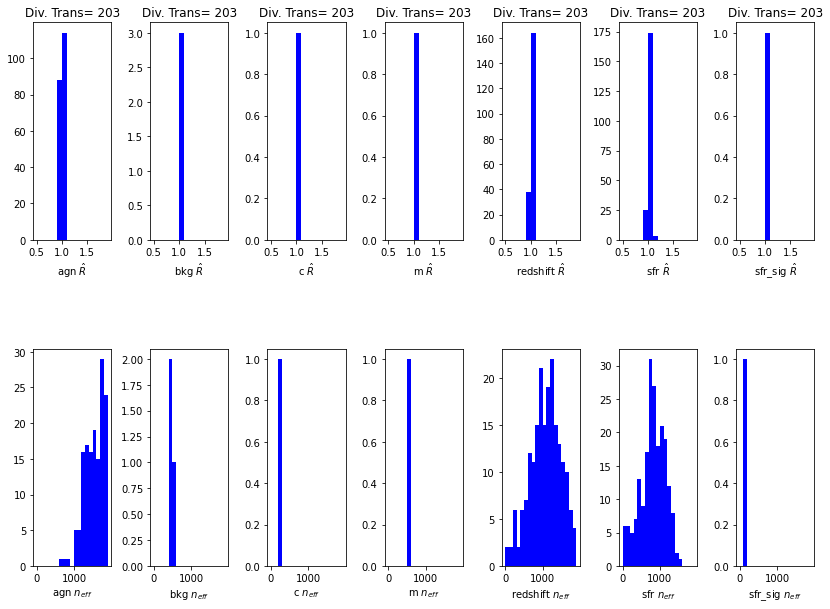

In [17]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

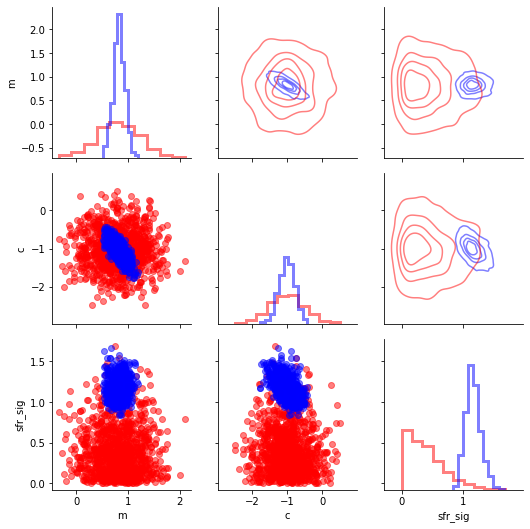

In [18]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

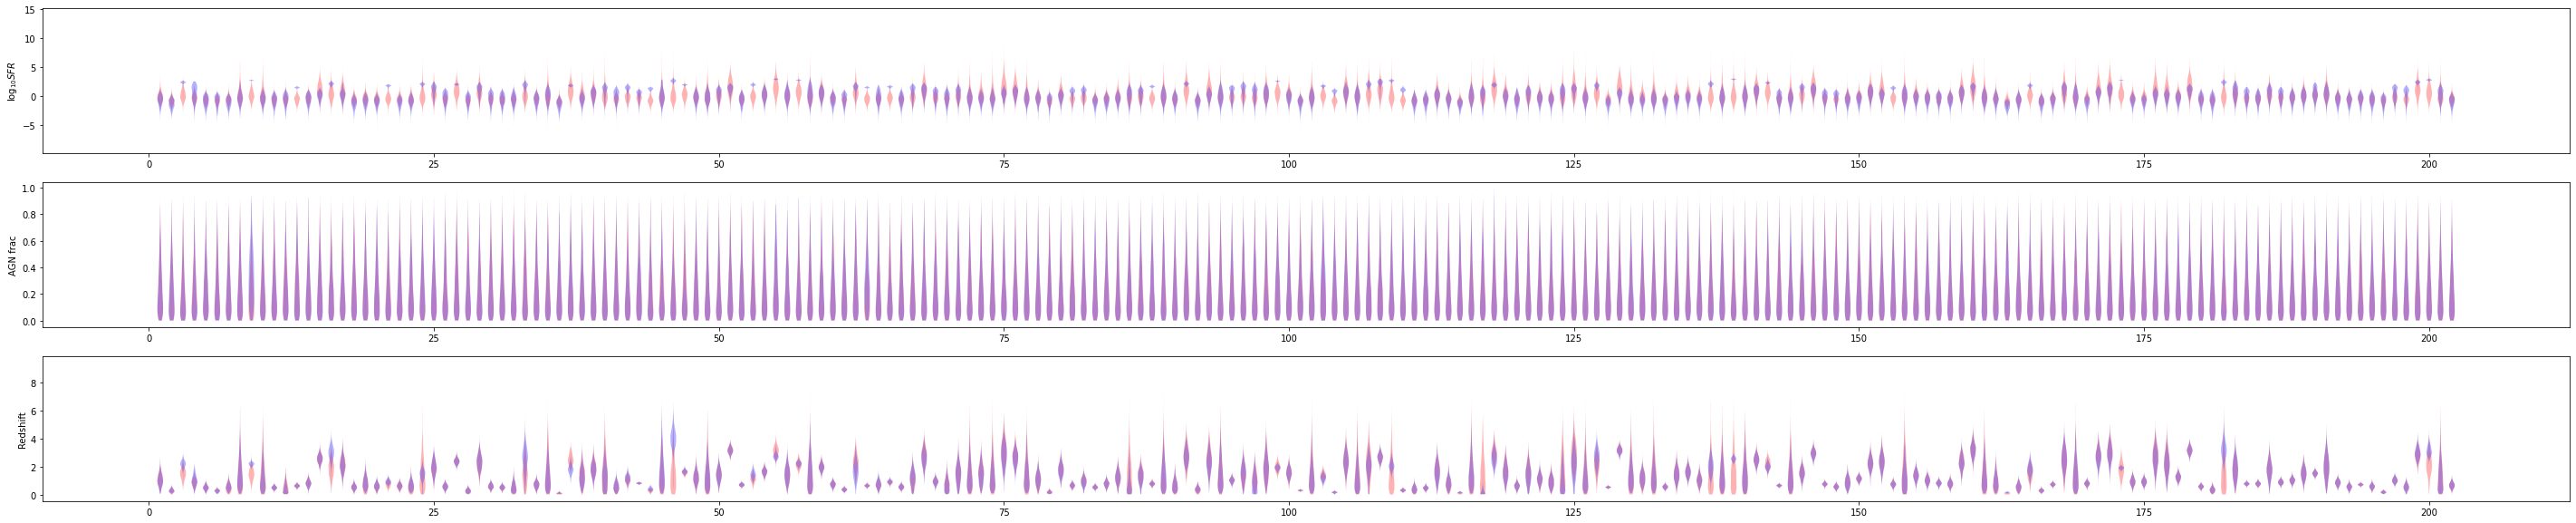

In [19]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [20]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 1.98 s, sys: 10.4 ms, total: 1.99 s
Wall time: 1.97 s


In [21]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

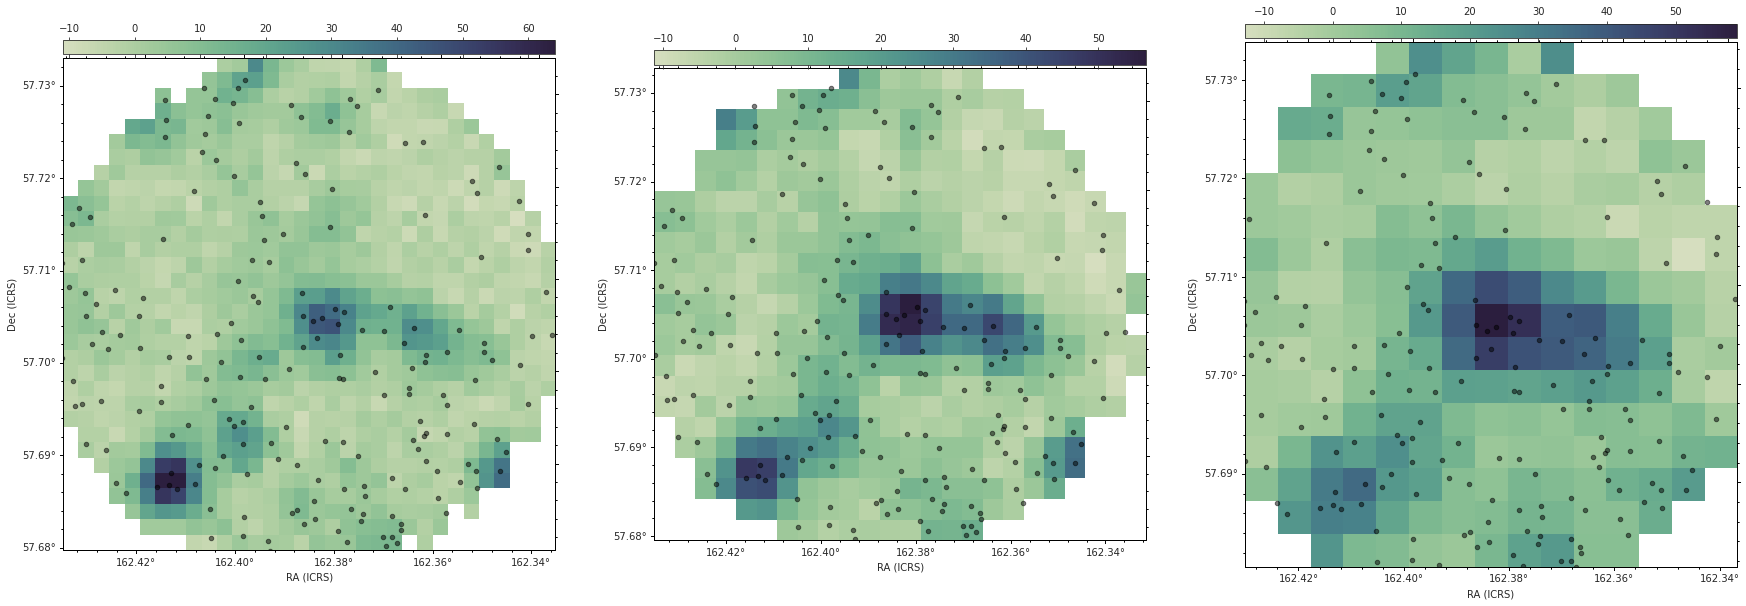

In [22]:
figures,fig=xidplus.plot_map(priors)

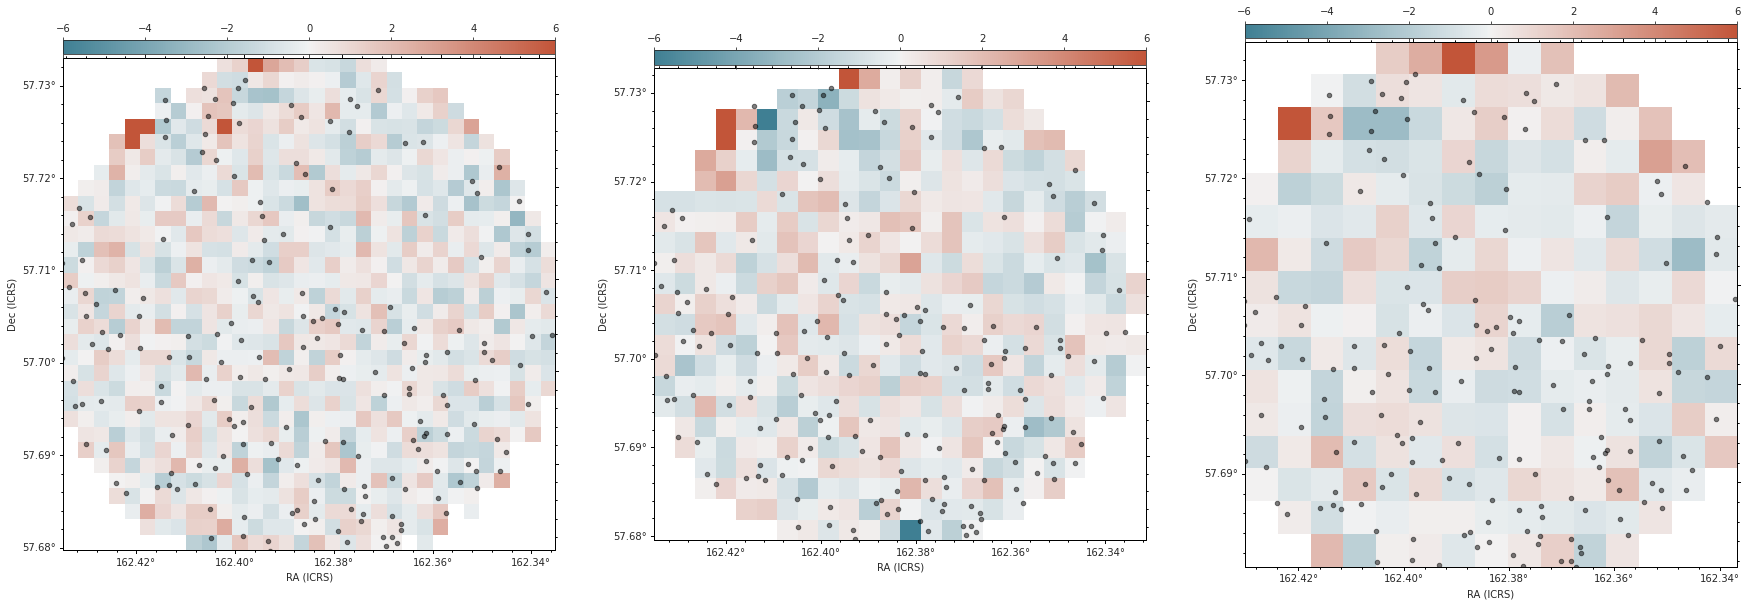

In [23]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [25]:
#Run the DAOstarfinder on the original maps for all SPIRE bands
from photutils import DAOStarFinder
fwhm=[17.6,23.9,35.2]
new_scat_flux=[]
new_scat_pos=[]
for b in range(0,len(priors)):
    tmp_fits=postmaps.make_fits_image(priors[b],priors[b].sim)
    wcs_temp = wcs.WCS(tmp_fits[1].header)
    daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5.0,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5)    
    new_scat = daofind(tmp_fits[1].data)
    new_scat_coords=wcs_temp.pixel_to_world(new_scat['xcentroid'],new_scat['ycentroid'])
    idx_new, d2d_new, d3d_new = c.match_to_catalog_sky(new_scat_coords)
    new_scat_flux.append(new_scat['peak'][idx_new])
    new_scat_pos.append(new_scat_coords[idx_new])


In [26]:
posterior_blind_source_coords=[]
posterior_blind_source_flux=[]
# Run starfinder on all posterior maps
for s in range(0,mod_map_array_samp[0].shape[-1]):
    if s%1000==0:
        print(s)
    tmp_posterior_blind_source_coords=[]
    tmp_posterior_blind_source_flux=[]
    for b in range(0,len(priors)):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array_samp[b][...,s])
        #need to widen constriants on roundness and sharpness constraints
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5) 
        sources = daofind(tmp_fits[1].data)
        #print(sources)
        wcs_temp = wcs.WCS(tmp_fits[1].header)
        new_coords=wcs_temp.pixel_to_world(sources['xcentroid'],sources['ycentroid'])
   
            
        idx_tmp, d2d_tmp, d3d_tmp = c.match_to_catalog_sky(new_coords)
        tmp_posterior_blind_source_coords.append(new_coords[idx_tmp])
        tmp_posterior_blind_source_flux.append(sources[idx_tmp]['peak'])
    posterior_blind_source_coords.append(tmp_posterior_blind_source_coords)
    posterior_blind_source_flux.append(tmp_posterior_blind_source_flux)
        
    

0


1000


In [27]:
 # get original fluxes from scat
band=[250,350,500]
scat_flux=[]
scat_pos=[]
for b in band:
    file=glob.glob('../../../data/*-{}_SCAT{}SXT_DR2.fits.gz'.format(field[0],b))
    scat=Table.read(file[0])
    orig_scat_coords=SkyCoord(scat['RA'],scat['Dec'])
    
    idx, d2d, d3d = c.match_to_catalog_sky(orig_scat_coords)
    scat_flux.append(scat['Flux'][idx].data)
    scat_pos.append(orig_scat_coords[idx])
scat_flux=np.array(scat_flux)

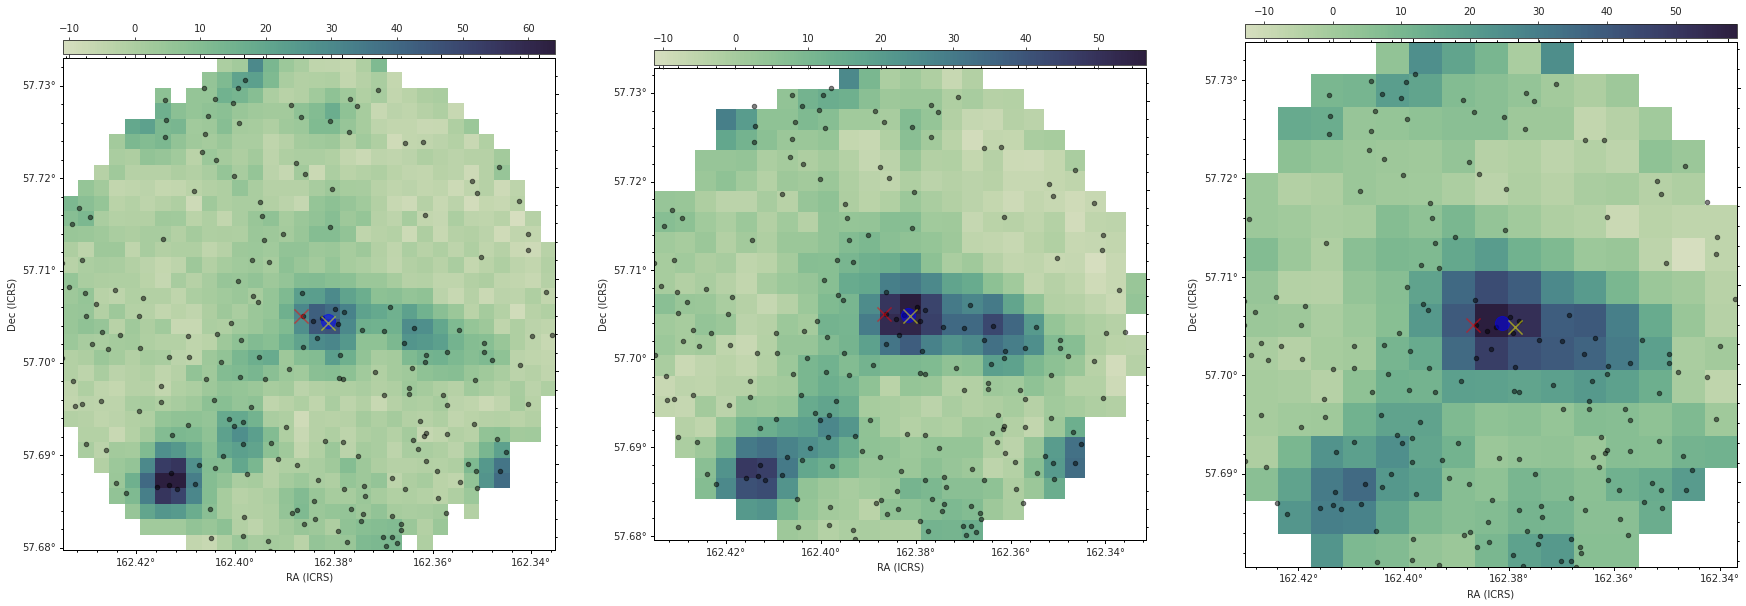

In [28]:
orig_map=xidplus.plot_map(priors)
for i in range(0,3):
    #plot new scat coords
    orig_map[0][i].show_markers(new_scat_pos[i].ra.value,new_scat_pos[i].dec.value,edgecolor='blue', facecolor='blue',
                marker='o', s=200, alpha=0.5)
    orig_map[0][i].show_markers(c.ra.value,c.dec.value, edgecolor='red', facecolor='red',
                marker='x', s=200, alpha=0.5)
    orig_map[0][i].show_markers(scat_pos[i].ra.value,scat_pos[i].dec.value,edgecolor='yellow', facecolor='yellow',
                marker='x', s=200, alpha=0.5)


In [29]:
#stack params and make vector ready to be used by emualator
params = jnp.stack((samples['sfr'].T, samples['agn'].T, samples['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((prior_pred['sfr'].T, prior_pred['agn'].T, prior_pred['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [30]:
src_f.shape

(2000, 202, 3)

In [31]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=new_scat_pos[0].separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J104932.903+574219.715
HELP_J104932.406+574217.927
HELP_J104931.368+574222.897
HELP_J104930.927+574221.627
HELP_J104931.972+574219.369
HELP_J104931.202+574217.038
HELP_J104932.206+574211.253 
 are possible contributers to flux of extreme starburst


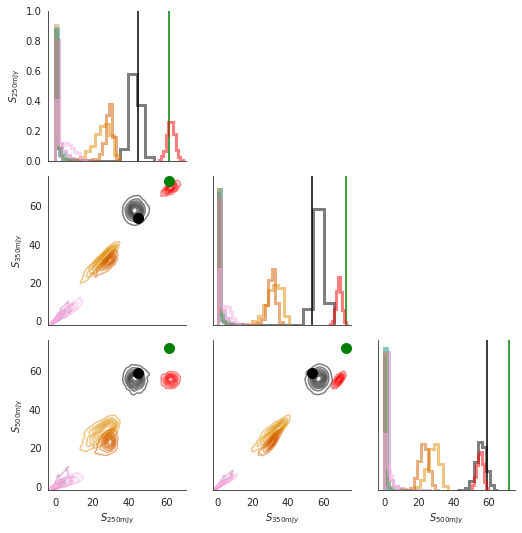

In [32]:
cmap=sns.color_palette('colorblind')
sns.set_style("white")
#set up Pairgrid plot and plot blind source flux
df_blind=pd.DataFrame(np.array(posterior_blind_source_flux)[:,:,0],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g=sns.PairGrid(df_blind)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='black')
#g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)

#plot the fluxes for the possible sources that could contribute
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    #g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

# plot the combination of flux from those sources
df_sum=pd.DataFrame(np.sum(src_f[:,contrib_sources,:],axis=1),columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df_sum
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')




g.data=df_blind
g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    #g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
g.data=df_sum
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
    
    
#turn off the axes not used
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[1,2].set_axis_off()

#plot the fluxes from new scat and orig scat
for i in range(0,len(priors)):
    g.axes[i,i].axvline(x=new_scat_flux[i],color='black')
    g.axes[i,i].axvline(x=scat_flux[i],color='green')
    for j in range(0,len(priors)):
        if j>i:
            g.axes[j,i].plot(new_scat_flux[i],new_scat_flux[j],'ko',ms=10)
            g.axes[j,i].plot(scat_flux[i],scat_flux[j],'go',ms=10)
#g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
#g.axes[3,0].plot(0.39,27.0,'ko',ms=10)


### Parameters of contributing sources
The physical parameters of our sources which could be contributing to the extreme starburst

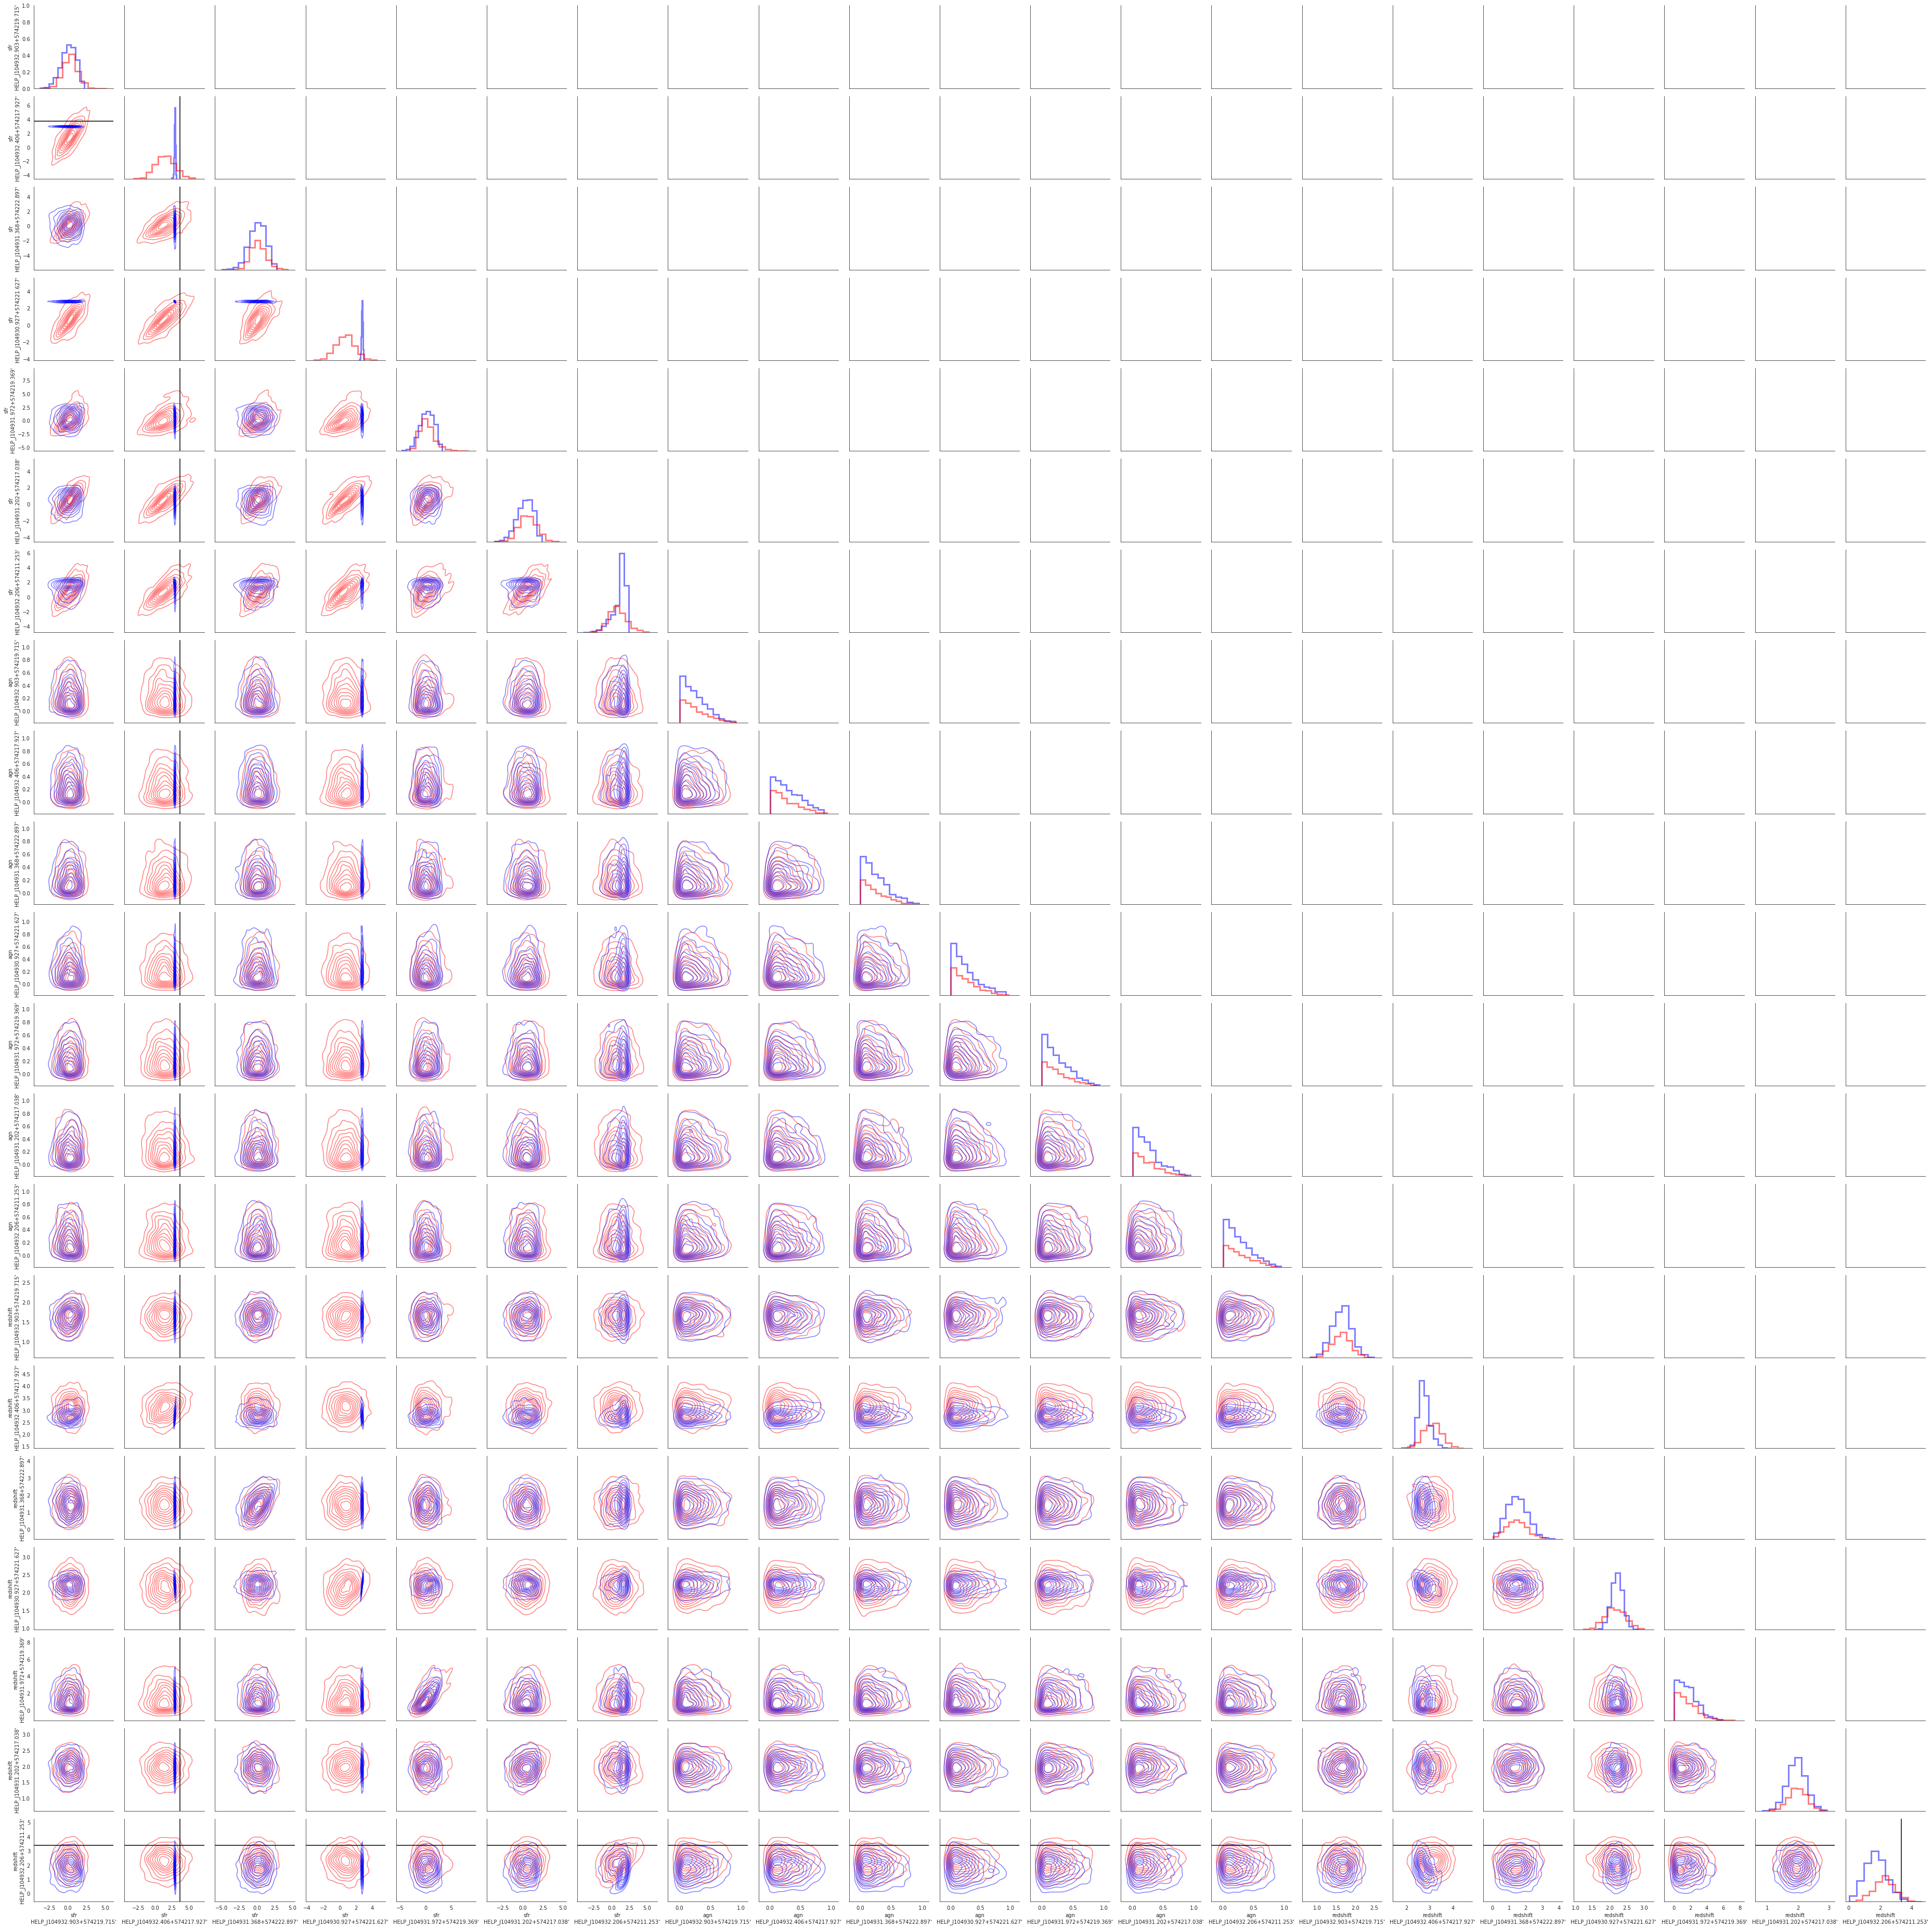

In [33]:
phys_params=['sfr','agn','redshift']
contrib_params=pd.DataFrame(np.array([samples[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
contrib_params_prior=pd.DataFrame(np.array([prior_pred[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
g=sns.PairGrid(contrib_params)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Blue')
g.data=contrib_params_prior
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

g.data=contrib_params
g.map_lower(sns.kdeplot, color='Blue',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

[a.axhline(y=esb[source[0]]['Z\xa0comb'],color='black') for a in g.axes[-1,:-1]]
g.axes[1,0].axhline(y=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') 

g.axes[-1,-1].axvline(x=esb[source[0]]['Z\xa0comb'],color='black')
[a.axvline(x=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') for a in g.axes[1:,1]]



update the webtable to identify issues

In [34]:
esb_web=Table.read('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',encoding='utf-8')
if np.sum(divergences)<1:
    esb_web['status'][source[0]]='[&#9745;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)
else:
    esb_web['status'][source[0]]='[&#9744;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)